<a href="https://colab.research.google.com/github/dekemarquardt/MyProjectAgain/blob/main/Global_Rose_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# print all the outputs in a cell
!pip install census us pandas
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from census import Census
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
#plt.style.use('seaborn-whitegrid')
from datetime import datetime,date
import matplotlib.transforms as mtransforms
from sklearn.cluster import KMeans
import numpy as np
from IPython.display import display
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
pd.options.display.float_format = '{:,.0f}'.format
import datetime
import re
from google.colab import files
import os
#!git config --global user.email "deke.marquardt@foreviewsolutions.com"
#!git config --global user.name "dekemarquard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 6.9 MB/s eta 0:00:00


In [ ]:
from census import Census
import pandas as pd
from us import states

API_KEY = "a5bee136937d46e1bf202659673bd41f334885f4"
c = Census(API_KEY, year=2022)

VARIABLES = ("B01003_001E", "B19013_001E")  # Total population

# Request for ALL ZIP Code Tabulation Areas at once (no state loop)
results = c.acs5.get(
    VARIABLES,
    {'for': 'zip code tabulation area:*'}
)

# Build DataFrame
df_zip = pd.DataFrame(results)

# Rename columns
df_zip = df_zip.rename(columns={
    'zip code tabulation area': 'zip_code',
    'B01003_001E': 'population',
    'B19013_001E': 'median_household_income'
})

# Clean data types
df_zip['population'] = df_zip['population'].astype(int)
df_zip['ship_zip'] = df_zip['zip_code'].astype(str)
df_zip.drop(columns='zip_code', inplace=True)
df_zip['median_household_income'] = pd.to_numeric(df_zip['median_household_income'], errors='coerce')
len(df_zip)

KeyboardInterrupt: 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/Global Rose/Global Rose - Sales Jan 1 - Feb 28, 2025.xls'
df_1_2_2025 = pd.read_excel(file_path)
file_path = '/content/drive/My Drive/Global Rose/Global Rose - Sales Mar 1 - Apr 18, 2025.xls'
df_3_4_2025 = pd.read_excel(file_path)
file_path = '/content/drive/My Drive/Global Rose/mar-abr.xls'
df_3_4_2024 = pd.read_excel(file_path)
file_path = '/content/drive/My Drive/Global Rose/ene-feb.xls'
df_1_2_2024 = pd.read_excel(file_path)
file_path = '/content/drive/My Drive/Global Rose/may-jun.xls'
df_5_6_2024 = pd.read_excel(file_path)

In [5]:
#There is a value in the 'quantity' column that is "quantity"
df_3_4_2025 = df_3_4_2025[df_3_4_2025['quantity']!='quantity']
df_3_4_2025['quantity'] = df_3_4_2025['quantity'].astype('float64')
df_3_4_2025['price'] = df_3_4_2025['price'].astype('float64')
df = df_1_2_2025.merge(df_3_4_2025, how='outer')
df = df.merge(df_3_4_2024, how='outer')
df = df.merge(df_1_2_2024, how='outer')
df = df.merge(df_5_6_2024, how='outer')

<ipython-input-5-a0764f24805f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3_4_2025['quantity'] = df_3_4_2025['quantity'].astype('float64')
<ipython-input-5-a0764f24805f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3_4_2025['price'] = df_3_4_2025['price'].astype('float64')


In [6]:
df_name = df.groupby(['order_id', 'order_date'])['price'].sum().reset_index()
df_name = df_name.rename(columns={'price':'Total Price'})
df2 = df.merge(df_name, how='outer')
#df2 = df.merge(df_zip, how='left', on='ship_zip')

In [7]:
df3 = df2[~df2['name'].str.contains('Tax|Shipping', case=False, na=False)]
df4 = df3[df3['ship_comp'].isna()==True]
df4 = df4 = df4[(df4['sku']!='Cancelled') | (df4['sku']!='Replacement Coupon')]

In [10]:
df_unique = df4.groupby(['ship_name', 'ship_email', 'ship_addr', 'bill_addr'])['order_id'].nunique().reset_index()

In [8]:
no_tax_shipping = (1 - (len(df4) / len(df3)))*100
print("No B2B and cancelled orders drops " + str(no_tax_shipping) + "% of the values.")

No B2B and cancelled orders drops 3.8409439475186713% of the values.


In [49]:
df_name2 = df4.groupby('name')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)[0:200]

In [8]:
df_name_path = '/content/drive/MyDrive/name.xlsx'

# Save to Drive
df_name2.to_excel(df_name_path, index=False)

In [ ]:
#df4.groupby('ship_state')['price'].sum().reset_index().sort_values(by='price', ascending=False)

In [50]:
#To determine D2C orders
df2_grouped = df3[df3['ship_comp'].isna()==True].groupby('order_id').agg(order_id_count=('order_id', 'count')).reset_index()
df2_grouped = df2_grouped.rename(columns={'order_id_count': 'order id count'})
#df2_grouped.sort_values(by='order id count', ascending=False)

In [ ]:
#df.groupby('code')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)

code  order_id
313                                       Out of State     51180
1507                                         mm-others     49017
1919                                         qty-roses      3198
292                                           Canceled      2227
319                                 Replacement Coupon      2162
1581                            next-day-100-red-roses      2098
1914                                    qty-carnations      1466
171                              50-next-day-red-roses      1241
1002                                     flower-filler       731
1019                    freedom-valentines-special-100       718
2090                                     roses-red-100       676
1918                                      qty-redroses       663
808                                          classy-50       660
167                         50-next-day-assorted-roses       616
2003                             rose-assorted-special       609
1572                       next-day-100-assorted-roses       606
1794                      pink-roses-assorted-next-day       571
234                                 50-solid-red-roses       537
1016                                freedom-medium-100       422
170                             50-next-day-pink-roses       404
192                                  50-roses-assorted       396
2553                     white-roses-assorted-next-day       391
805                                         classy-100       370
1215                          hydrangeas-blue-20-20-24       366
2093                               roses-red-200-short       364
172                            50-next-day-white-roses       355
1128                         gypso-perfecta-12-bunches       333
2097                                   roses-white-100       333
2083                                    roses-pink-100       332
2537                              white-carnations-100       327
552                            assorted-carnations-200       325
235                               50-solid-white-roses       314
1310                                    leather-leaf-6       310
1602                  next-day-50-roses-25-red-25-pink       305
2060                            rose-petals-white-2400       303
2422                          vday-2-dozen-red-roses-f       291
1511                                mom-carnations-200       284
1550                        mothers-day-carnations-100       284
551                            assorted-carnations-100       280
1920                                    qty-whiteroses       274
2053                              rose-petals-red-2400       270
2390                     valentines-day-carnations-100       265
1130                          gypso-perfecta-6-bunches       263
2442                               vday-carnations-200       255
2421                            vday-2-dozen-red-roses       250
1228                         hydrangeas-white-20-20-24       244
971                         eucalyptus-silver-dollar-5       242
789                                  charlotte-long-75       236
179                                 50-red-roses-short       221
236                              50-solid-yellow-roses       219
2279                                    sugar-doll-100       219
2604                        your-choice-carnations-100       216
998                                     floral-snipper       214
1571                  next-day-100-assorted-carnations       214
555                            assorted-carnations-std       212
2605                  your-choice-color-carnations-200       207
2538                              white-carnations-200       206
1603                 next-day-50-roses-25-red-25-white       204
1982                                red-carnations-100       199
177                               50-red-roses-freedom       194
1131                                    gypsophilia-30       192
995                 

In [29]:
df2['name'].nunique()

8130

In [27]:
df2['sku'].nunique()

2467

In [51]:
df_d2c = df3[df3['ship_comp'].isna()==True]
# Define conditions and corresponding choices
# Updated conditions (add ' Medium', and put it before ' Med')
conditions = [
    df_d2c['name'].str.contains(' Sht', na=False),
    df_d2c['name'].str.contains(' Std', na=False),
    df_d2c['name'].str.contains(' Medium', na=False),  # must go before ' Med'
    df_d2c['name'].str.contains(' Med', na=False),
    df_d2c['name'].str.contains(' Long', na=False)
]

choices = ['short', 'standard', 'medium', 'medium', 'long']  # map both ' Medium' and ' Med' to 'medium'

# Create the new column
df_d2c['length_category'] = np.select(conditions, choices, default=pd.NA)

# Remove all size indicators including ' Medium'
df_d2c['Product Name'] = df_d2c['name'].str.replace(r' (Sht|Std|Medium|Med|Long)', '', regex=True).str.strip()
#df_d2c['Product Name'] = df_d2c['Product Name'].where(~df_d2c['Product Name'].str.contains(r'DISCOUNT|canceled|COUPON', na=False, case=False),pd.NA)
#df_d2c['Product Name'] = df_d2c['Product Name'].where(~df_d2c['Product Name'].str.contains(r'\b(DISCOUNT|canceled|COUPON|delivery|DELIVERY)\b', na=False, case=False),pd.NA)
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(r' \b\d+\s+Bunches\b', '', regex=True).str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(r' \[Include Flower Food\]', '', regex=True).str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(r' \((QB|OM|OC|HB)\)', '', regex=True).str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(r'\((QB|OM|OC|HB)\)\s*', '', regex=True).str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(r'\bvase.*', '', regex=True).str.strip()
#df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(' 200', '', regex=False).str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(' Mothers Pack', '', regex=False).str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(' Val Pack', '', regex=False).str.strip()
#df_d2c['Product Name'] = df_d2c['Product Name'].str.replace('3500 ', '', regex=False).str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(r'\b\d+\b\s*|\s*\b\d+\b', '', regex=True).str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'] \
    .str.replace(r'Qty ', '', regex=True) \
    .str.replace(r'qty-.*', '', regex=True) \
    .str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'] \
    .str.replace(r'Dozen ', '', regex=False) \
    .str.replace(r' dozen', '', regex=False) \
    .str.replace(r'\(2HB\) BOXES ', '', regex=True) \
    .str.replace(r'Single ', '', regex=False) \
    .str.replace(r' Petite', '', regex=False) \
    .str.replace(r'of ', '', regex=False) \
    .str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace('Roses Red', 'Rose Red', regex=False)
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace('Red Roses', 'Rose Red', regex=False)
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(r'\s*\(2HB\)\s*', ' ', regex=True).str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(' Mothers Pack', '', regex=False).str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'].str.replace(
    r'\b(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\b,?|\s-\s?',
    '',
    regex=True
).str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'] \
    .str.replace(' Bunches', '', regex=False) \
    .str.replace('Dozens ', '', regex=False) \
    .str.strip()
df_d2c['Product Name'] = df_d2c['Product Name'] \
    .str.replace(r'\d+', '', regex=True) \
    .str.replace(r'\s{2,}', ' ', regex=True) \
    .str.strip()

df_d2c['Product Name'] = df_d2c['Product Name'] \
    .str.replace(r'\bcm\b', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

<ipython-input-51-701f434255ea>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d2c['length_category'] = np.select(conditions, choices, default=pd.NA)
<ipython-input-51-701f434255ea>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d2c['Product Name'] = df_d2c['name'].str.replace(r' (Sht|Std|Medium|Med|Long)', '', regex=True).str.strip()
<ipython-input-51-701f434255ea>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

KeyError: 'Type'

In [24]:
df_d2c[df_d2c['Product Name'].str.contains('Daisy')==True]['Product Name'].unique()

array(['Pom Daisy White', 'Poms Daisy Assorted', 'Pom Daisy Assort',
       'Pom Daisy Bronze', 'Pom Daisy Burgundy', 'Poms Daisy White',
       'Pom Daisy Yellow', 'Poms Daisy Yellow', 'Poms Daisy Bronze',
       'Pom Daisy WhiteMar,', 'Poms Daisy AssortedMay,',
       'Pom Daisy WhiteMay,', 'Pom Daisy YellowMay,',
       'Pom Daisy YellowJun,', 'Poms Daisy Burgundy',
       'Pom Daisy AssortJun,', 'Pom Daisy WhiteJul,',
       'Pom Daisy WhiteFeb,'], dtype=object)

In [76]:
# Mask for 'code' containing 'statice' (case-insensitive)
statice_mask = df_d2c['code'].str.contains('statice', case=False, na=False)

# Set 'Type' to 'Lavender'
df_d2c.loc[statice_mask, 'Type'] = 'Lavender'

# Mask for codes containing 'flower-filler' OR 'fillers-' (case-insensitive)
filler_mask = df_d2c['code'].str.contains(r'flower-filler|fillers-', case=False, na=False)

# Set 'Type' to 'Filler'
df_d2c.loc[filler_mask, 'Type'] = 'Filler'

# Set 'Subtype' as 'Product Name' with 'flower filler' removed (case-insensitive)
df_d2c.loc[filler_mask, 'Subtype'] = df_d2c.loc[filler_mask, 'Product Name'] \
    .str.replace(r'flower\s*filler', '', case=False, regex=True) \
    .str.strip()

# Set 'Subtype' to full 'Product Name'
df_d2c.loc[statice_mask, 'Subtype'] = df_d2c.loc[statice_mask, 'Product Name']

# Rose Petals logic (no boundaries, case-insensitive)
is_petals = df_d2c['Product Name'].str.contains('rose petals', case=False, na=False)
petals_split = df_d2c['Product Name'].str.split('(?i)rose petals', n=1, expand=True)

# Roses (plural) logic (no boundaries, case-insensitive)
is_roses = df_d2c['Product Name'].str.contains('roses', case=False, na=False)
roses_split = df_d2c['Product Name'].str.split('(?i)roses', n=1, expand=True)

# Rose (singular) logic (no boundaries, case-insensitive)
is_rose = df_d2c['Product Name'].str.contains('rose', case=False, na=False)
rose_split = df_d2c['Product Name'].str.split('(?i)rose', n=1, expand=True)

# Hydrangea logic (matches both 'hydrangea' and 'hydrangeas', case-insensitive)
is_hydrangea = df_d2c['Product Name'].str.contains(r'hydrangeas?', case=False, na=False)
hydrangea_split = df_d2c['Product Name'].str.split(r'(?i)hydrangeas?', n=1, expand=True)

# Create 'Type' column
df_d2c['Type'] = np.where(is_petals, 'Rose Petals',
                  np.where(is_roses, 'Rose',
                  np.where(is_rose, 'Rose',
                  np.where(is_hydrangea, 'Hydrangea', pd.NA))))





# Create 'Subtype' column
df_d2c['Subtype'] = np.where(is_petals, petals_split[1].str.strip(),
                     np.where(is_roses, roses_split[0].str.strip(),
                     np.where(is_rose,
                              rose_split[0].str.strip() + ' ' + rose_split[1].fillna('').str.strip(),
                     np.where(is_hydrangea,
                              hydrangea_split[0].str.strip() + ' ' + hydrangea_split[1].fillna('').str.strip(),
                              pd.NA))))


# Mask for rows where 'Product Name' contains 'Gypso' (case-insensitive, no boundaries)
gypso_mask = df_d2c['Product Name'].str.contains('Gypso', case=False, na=False)

# Set 'Type' to 'Gypso'
df_d2c.loc[gypso_mask, 'Type'] = "Baby's Breath"

# Extract everything before and after "Gypso" (drop just the word "Gypso")
df_d2c.loc[gypso_mask, 'Subtype'] = df_d2c.loc[gypso_mask, 'Product Name'] \
    .str.replace(r'Gypso', '', case=False, regex=True) \
    .str.strip()

# Mask where 'code' contains 'carnations' (case-insensitive)
carn_mask = df_d2c['code'].str.contains('carn', case=False, na=False)

# Set 'Type' to 'Carnations'
df_d2c.loc[carn_mask, 'Type'] = 'Carnations'

# Set 'Subtype' by removing 'Carn ' and 'Carnations ' from 'Product Name'
df_d2c.loc[carn_mask, 'Subtype'] = df_d2c.loc[carn_mask, 'Product Name'] \
    .str.replace(r'\bCarn(ations)?\s+', '', case=False, regex=True) \
    .str.strip()

# Updated mask: match 'leather-leaf', 'leatherleaf', or 'leather-leaves' (case-insensitive)
leather_mask = df_d2c['code'].str.contains('leather-leaf|leatherleaf|leather-leaves', case=False, na=False)

# Set 'Type' to 'Leather Leaf'
df_d2c.loc[leather_mask, 'Type'] = 'Leather Leaf'

# Remove 'leather leaf', 'leatherleaf', or 'leather-leaves' from 'Product Name' for Subtype
df_d2c.loc[leather_mask, 'Subtype'] = df_d2c.loc[leather_mask, 'Product Name'] \
    .str.replace(r'leather[-\s]?leaves?|leatherleaf', '', case=False, regex=True) \
    .str.strip()

# Mask: 'Product Name' contains 'leather leaf' or 'leatherleaf' (case-insensitive)
leather_name_mask = df_d2c['Product Name'].str.contains('leatherleaf|leather leaf', case=False, na=False)

# Set Type to 'Leather Leaf'
df_d2c.loc[leather_name_mask, 'Type'] = 'Leather Leaf'

# Remove 'leather leaf' or 'leatherleaf' from Product Name to create Subtype
df_d2c.loc[leather_name_mask, 'Subtype'] = df_d2c.loc[leather_name_mask, 'Product Name'] \
    .str.replace(r'leather[-\s]?leaf', '', case=False, regex=True) \
    .str.strip()




# Define 'Subtype' based on presence of "DC:"
df_d2c['Subtype'] = np.where(df_d2c['name'].str.contains('DC:', na=False), 'Designer Collection', df_d2c['Subtype'])

# Define 'Subtype' based on presence of "DC:"
df_d2c['Subtype'] = np.where(df_d2c['name'].str.contains('DC', na=False), 'Designer Collection', df_d2c['Subtype'])



# 1. Define 'Subscription Type' from 'frequency:'
df_d2c['Subscription Type'] = np.where(
    df_d2c['Product Name'].str.contains('Subscription', na=False),
    df_d2c['Product Name'].str.extract(r'frequency:(\w+)', expand=False),
    pd.NA
)

# 2. Set 'Type' to 'Roses' if 'roses' appears (case-insensitive) in rows with 'Subscription'
df_d2c['Type'] = np.where(
    df_d2c['Product Name'].str.contains('Subscription', na=False) &
    df_d2c['Product Name'].str.contains('roses', case=False, na=False),
    'Rose',
    df_d2c.get('Type', pd.NA)  # keep existing 'Type' if defined elsewhere
)

# 3. Set 'Subtype' based on 'roses-color:', capitalize the first letter
df_d2c['Subtype'] = np.where(
    df_d2c['Product Name'].str.contains('Subscription', na=False),
    df_d2c['Product Name']
        .str.extract(r'roses-color:([a-zA-Z\-]+)', expand=False)
        .str.capitalize(),
    df_d2c.get('Subtype', pd.NA)  # keep existing 'Subtype' if defined elsewhere
)
# 1. Filter condition for "Rose Variety"
is_rose_variety = df_d2c['Product Name'].str.contains('Rose Variety', na=False)

# 2. Rose Variety Program Frequency: extract after 'frequency:'
df_d2c['Rose Variety Program Frequency'] = np.where(
    is_rose_variety,
    df_d2c['Product Name'].str.extract(r'frequency:(\w+)', expand=False),
    pd.NA
)

# 3. Type = 'Rose' for these rows
df_d2c['Type'] = np.where(
    is_rose_variety,
    'Rose',
    df_d2c.get('Type', pd.NA)  # retain existing if already populated
)

# 4. Subtype = value after 'variety:', capitalized
df_d2c['Subtype'] = np.where(
    is_rose_variety,
    df_d2c['Product Name']
        .str.extract(r'variety:([a-zA-Z\-]+)', expand=False)
        .str.capitalize(),
    df_d2c.get('Subtype', pd.NA)
)
df_d2c.loc[df_d2c['sku'] == 'GLO003546', 'Product Name'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO003546', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO003546', 'Subtype'] = 'Red'
df_d2c['Subtype'] = df_d2c['Subtype'].str.replace(
    r'(Assorted \(Different Colors, No Red Color\)).*',
    r'\1',
    regex=True
).str.strip()
df_d2c.loc[df_d2c['sku'] == 'GLO004782', 'Subtype'] = 'Red'
df_d2c.loc[df_d2c['sku'] == 'GLO000377', 'Product Name'] = 'Rose Pink'
df_d2c.loc[df_d2c['sku'] == 'GLO000377', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO000377', 'Subtype'] = 'Pink'
df_d2c.loc[
    (df_d2c['sku'] == 'GLO000484') &
    (df_d2c['Subtype'] == 'Pink Saturday Delivery Fee:*Additional Fee'),
    'Subtype'
] = 'Pink'
df_d2c.loc[df_d2c['sku'] == 'GLO006315', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO006168', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO006315', 'Subtype'] = 'Solid White'
df_d2c.loc[df_d2c['sku'] == 'GLO005011', 'Subtype'] = 'Red'
df_d2c.loc[df_d2c['sku'] == 'GLO000485', 'Subtype'] = 'Red'
df_d2c.loc[df_d2c['sku'] == 'GLO002751', 'Subtype'] = 'Hot Princess'
df_d2c.loc[df_d2c['sku'] == 'GLO000484', 'Subtype'] = 'Pink'
df_d2c.loc[df_d2c['sku'] == 'GLO003601', 'Subtype'] = 'Hot Pink'
df_d2c.loc[df_d2c['sku'] == 'GLO004504', 'Subtype'] = 'Red'
df_d2c.loc[df_d2c['sku'] == 'GLO002655', 'Subtype'] = 'High and Bonita'
df_d2c.loc[df_d2c['sku'] == 'GLO002322', 'Subtype'] = 'Faith'
df_d2c.loc[df_d2c['sku'] == 'GLO004779', 'Subtype'] = 'Red'
#df_d2c.loc[df_d2c['sku'] == 'GLO004686', 'Subtype'] = 'Assorted (Gypo and Green)'
df_d2c.loc[df_d2c['sku'] == 'GLO005213', 'Subtype'] = 'Sweetness'
df_d2c.loc[df_d2c['sku'] == 'GLO002468', 'Subtype'] = 'Freedom'
df_d2c.loc[df_d2c['sku'] == 'GLO002468', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO002468']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO006301', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO006301', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO006301']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO006172', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO006172', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO006172']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO006171', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO006171', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO006171']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO000673', 'Type'] = 'Lilies'
df_d2c.loc[df_d2c['sku'] == 'GLO000673', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO000673']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO006319', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO006319', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO006319']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO006729', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO006729', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO006729']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO006827', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO006827', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO006827']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO006166', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO006166', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO006166']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO001118', 'Type'] = 'Assorted'
df_d2c.loc[df_d2c['sku'] == 'GLO001118', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO001118']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO006162', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO006162', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO006162']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO006155', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO006155', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO006155']['Product Name']
df_d2c.loc[df_d2c['sku'] == 'GLO002903', 'Type'] = 'Rose'
df_d2c.loc[df_d2c['sku'] == 'GLO002903', 'Subtype'] = df_d2c.loc[df_d2c['sku'] == 'GLO002903']['Product Name']

# Match any instance where 'Mixed Greens Combo' appears (case-insensitive, no word boundaries)
mixed_mask = df_d2c['Product Name'].str.contains('Mixed Greens Combo', case=False, na=False)

# Set Type
df_d2c.loc[mixed_mask, 'Type'] = 'Mixed Greens Combo'


# Extract everything after 'Mixed Green Combo ' (note: singular 'Green', as you specified)
df_d2c.loc[mixed_mask, 'Subtype'] = df_d2c.loc[mixed_mask, 'Product Name'] \
    .str.extract(r'Mixed Green Combo (.*)', expand=False) \
    .str.replace(r'^:\s*', '', regex=True) \
    .str.strip()

tinted_mask = (df_d2c['Type'] == 'Hydrangea') & df_d2c['code'].str.startswith('hydrangea-tinted', na=False)

# Set Subtype to 'Tinted' for those rows
df_d2c.loc[tinted_mask, 'Subtype'] = 'Tinted'

df_d2c.loc[df_d2c['Product Name'] == 'Floral Snipper', 'Type'] = 'Floral Snipper'

# Mask where 'code' contains 'fillers-combo-pack' (case-insensitive)
fillers_combo_mask = df_d2c['code'].str.contains('fillers-combo-pack', case=False, na=False)

# Set 'Type' to 'Fillers'
df_d2c.loc[fillers_combo_mask, 'Type'] = 'Fillers'

# Set 'Subtype' to 'Combo Pack'
df_d2c.loc[fillers_combo_mask, 'Subtype'] = 'Combo Pack'

# Mask: 'code' contains 'eucalyptus' (case-insensitive, no boundaries)
eucalyptus_mask = df_d2c['code'].str.contains('eucalyptus', case=False, na=False)

# Set 'Type' to 'Eucalyptus'
df_d2c.loc[eucalyptus_mask, 'Type'] = 'Eucalyptus'

# Set 'Subtype' to 'Product Name' with 'eucalyptus' removed (case-insensitive)
df_d2c.loc[eucalyptus_mask, 'Subtype'] = df_d2c.loc[eucalyptus_mask, 'Product Name'] \
    .str.replace(r'eucalyptus', '', case=False, regex=True) \
    .str.strip()

# Mask for 'code' containing 'ruscus-' (case-insensitive)
ruscus_mask = df_d2c['code'].str.contains('ruscus-', case=False, na=False)

# Set 'Type' to 'Ruscus'
df_d2c.loc[ruscus_mask, 'Type'] = 'Ruscus'

# Remove 'Ruscus ' from 'Product Name' to create 'Subtype'
df_d2c.loc[ruscus_mask, 'Subtype'] = df_d2c.loc[ruscus_mask, 'Product Name'] \
    .str.replace(r'ruscus\s+', '', case=False, regex=True) \
    .str.strip()

# Mask: 'Product Name' or 'code' contains 'lillies' or 'lilies' (case-insensitive)
lily_mask = (
    df_d2c['Product Name'].str.contains(r'lilies|lillies', case=False, na=False) |
    df_d2c['code'].str.contains(r'lilies|lillies', case=False, na=False)
)

# Set 'Type' to 'Lilies'
df_d2c.loc[lily_mask, 'Type'] = 'Lilies'

# Remove 'lilies' and 'lillies', normalize spacing, and set 'Subtype'
df_d2c.loc[lily_mask, 'Subtype'] = df_d2c.loc[lily_mask, 'Product Name'] \
    .str.replace(r'lilies|lillies', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for codes containing 'gerberas-' (case-insensitive)
gerbera_mask = df_d2c['code'].str.contains('gerberas-', case=False, na=False)

# Set 'Type' to 'Gerbera'
df_d2c.loc[gerbera_mask, 'Type'] = 'Gerbera'

# Remove 'Gerbera ', normalize spacing, and set 'Subtype'
df_d2c.loc[gerbera_mask, 'Subtype'] = df_d2c.loc[gerbera_mask, 'Product Name'] \
    .str.replace(r'gerbera\s+', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for codes containing 'gerberas-' (case-insensitive)
gerbera_mask = df_d2c['code'].str.contains('gerbera-', case=False, na=False)

# Set 'Type' to 'Gerbera'
df_d2c.loc[gerbera_mask, 'Type'] = 'Gerbera'

# Remove 'Gerbera ', normalize spacing, and set 'Subtype'
df_d2c.loc[gerbera_mask, 'Subtype'] = df_d2c.loc[gerbera_mask, 'Product Name'] \
    .str.replace(r'gerbera', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()


# Mask for 'code' containing 'snapdragon-' (case-insensitive)
snap_mask = df_d2c['code'].str.contains('snapdragon-', case=False, na=False)

# Set 'Type' to 'Snapdragon'
df_d2c.loc[snap_mask, 'Type'] = 'Snapdragon'

# Remove 'snapdragon', normalize spacing, and set 'Subtype'
df_d2c.loc[snap_mask, 'Subtype'] = df_d2c.loc[snap_mask, 'Product Name'] \
    .str.replace(r'snapdragon', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()


# Mask for 'code' containing 'ball-' (case-insensitive)
ball_mask = df_d2c['code'].str.contains('ball-', case=False, na=False)

# Set 'Type' to 'Ball'
df_d2c.loc[ball_mask, 'Type'] = 'Ball'

# Remove 'Ball', normalize spacing, and set 'Subtype'
df_d2c.loc[ball_mask, 'Subtype'] = df_d2c.loc[ball_mask, 'Product Name'] \
    .str.replace(r'Ball', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for 'code' containing 'sunflowers-' (case-insensitive)
sunflowers_mask = df_d2c['code'].str.contains('sunflowers-', case=False, na=False)

# Set 'Type' to 'Sunflowers'
df_d2c.loc[sunflowers_mask, 'Type'] = 'Sunflowers'

# Remove 'sunflowers', normalize spacing, and set 'Subtype'
df_d2c.loc[sunflowers_mask, 'Subtype'] = df_d2c.loc[sunflowers_mask, 'Product Name'] \
    .str.replace(r'sunflowers', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for code exactly equal to 'cocculus-laurifolius' (case-insensitive)
cocculus_mask = df_d2c['code'].str.contains('cocculus-laurifolius', case=False, na=False)

# Set 'Type' to 'Cocculus Laurifolius'
df_d2c.loc[cocculus_mask, 'Type'] = 'Cocculus Laurifolius'

# Mask: 'code' contains '-lily' (case-insensitive)
lily_code_mask = df_d2c['code'].str.contains('lily', case=False, na=False)

# Mask: 'Product Name' does NOT contain 'lillies', 'lilies', or 'lily' (case-insensitive)
no_lily_in_name_mask = ~df_d2c['Product Name'].str.contains(r'lillies|lilies|lily', case=False, na=False)

# Set 'Type' to 'Lilies'
df_d2c.loc[lily_code_mask, 'Type'] = 'Lilies'

# Set 'Subtype' to 'Product Name' only if Product Name does NOT contain those lily terms
df_d2c.loc[lily_code_mask & no_lily_in_name_mask, 'Subtype'] = df_d2c.loc[lily_code_mask & no_lily_in_name_mask, 'Product Name']

# Mask for 'code' containing 'delphinium' (case-insensitive)
delphinium_mask = df_d2c['code'].str.contains('delphinium', case=False, na=False)

# Set 'Type' to 'Delphinium'
df_d2c.loc[delphinium_mask, 'Type'] = 'Delphinium'

# Extract everything after 'Delphinium ' (case-insensitive) for 'Subtype'
df_d2c.loc[delphinium_mask, 'Subtype'] = df_d2c.loc[delphinium_mask, 'Product Name'] \
    .str.extract(r'(?i)delphinium\s+(.*)', expand=False) \
    .str.strip()

# Mask: 'code' contains 'lisianthus-' (case-insensitive)
lisianthus_mask = df_d2c['code'].str.contains('lisianthus-', case=False, na=False)

# Set Type
df_d2c.loc[lisianthus_mask, 'Type'] = 'Lisianthus'

# Set Subtype: everything after 'Lisianthus '
df_d2c.loc[lisianthus_mask, 'Subtype'] = df_d2c.loc[lisianthus_mask, 'Product Name'] \
    .str.extract(r'(?i)Lisianthus\s+(.*)', expand=False) \
    .str.strip()

# Mask for 'code' containing 'pompoms-' (case-insensitive)
pom_mask = df_d2c['code'].str.contains('pompoms-', case=False, na=False)

# Set 'Type' to 'Pom'
df_d2c.loc[pom_mask, 'Type'] = 'Pom'

# Set 'Subtype' to 'Product Name' with 'Pom ' removed (case-insensitive), clean spacing
df_d2c.loc[pom_mask, 'Subtype'] = df_d2c.loc[pom_mask, 'Product Name'] \
    .str.replace(r'pom\s+', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for 'code' containing 'star-of-bethlehem' (case-insensitive)
star_mask = df_d2c['code'].str.contains('star-of-bethlehem', case=False, na=False)

# Set 'Type' to 'Star of Bethlehem'
df_d2c.loc[star_mask, 'Type'] = 'Star of Bethlehem'

# Remove 'Star of Bethlehem' from 'Product Name' (case-insensitive), normalize spacing
df_d2c.loc[star_mask, 'Subtype'] = df_d2c.loc[star_mask, 'Product Name'] \
    .str.replace(r'star of bethlehem', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for 'code' containing 'Iris' (case-insensitive)
iris_mask = df_d2c['code'].str.contains('iris-', case=False, na=False)

# Set 'Type' to 'Iris'
df_d2c.loc[iris_mask, 'Type'] = 'Iris'

# Remove 'Iris' from 'Product Name' (case-insensitive), normalize spacing
df_d2c.loc[iris_mask, 'Subtype'] = df_d2c.loc[iris_mask, 'Product Name'] \
    .str.replace(r'Iris', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for 'code' containing 'Dahlias' (case-insensitive)
dahlias_mask = df_d2c['code'].str.contains('dahlias', case=False, na=False)

# Set 'Type' to 'Iris'
df_d2c.loc[dahlias_mask, 'Type'] = 'Dahlias'

# Remove 'Dahlias' from 'Product Name' (case-insensitive), normalize spacing
df_d2c.loc[dahlias_mask, 'Subtype'] = df_d2c.loc[dahlias_mask, 'Product Name'] \
    .str.replace(r'Dahlias', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for 'code' containing 'ranunculus' (case-insensitive)
ranunculus_mask = df_d2c['code'].str.contains('ranunculus', case=False, na=False)

# Set 'Type' to 'Ranunculus'
df_d2c.loc[ranunculus_mask, 'Type'] = 'Ranunculus'

# Remove 'Ranunculus ', normalize spacing, and set 'Subtype'
df_d2c.loc[ranunculus_mask, 'Subtype'] = df_d2c.loc[ranunculus_mask, 'Product Name'] \
    .str.replace(r'ranunculus\s+', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()


# Mask for 'code' containing 'eryngium' (case-insensitive)
eryngium_mask = df_d2c['code'].str.contains('eryngium', case=False, na=False)

# Set 'Type' to 'Eryngium'
df_d2c.loc[eryngium_mask, 'Type'] = 'Eryngium'

# Remove 'Eryngium ', normalize spacing, and set 'Subtype'
df_d2c.loc[eryngium_mask, 'Subtype'] = df_d2c.loc[eryngium_mask, 'Product Name'] \
    .str.replace(r'eryngium\s+', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for 'code' containing 'viburnum' (case-insensitive)
viburnum_mask = df_d2c['code'].str.contains('viburnum', case=False, na=False)

# Set 'Type' to 'viburnum'
df_d2c.loc[viburnum_mask, 'Type'] = 'Viburnum'

# Remove 'viburnum ', normalize spacing, and set 'Subtype'
df_d2c.loc[viburnum_mask, 'Subtype'] = df_d2c.loc[viburnum_mask, 'Product Name'] \
    .str.replace(r'viburnum\s+', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for 'code' containing 'aster' (case-insensitive)
aster_mask = df_d2c['code'].str.contains('aster', case=False, na=False)

# Set 'Type' to 'aster'
df_d2c.loc[aster_mask, 'Type'] = 'Aster'

# Remove 'aster ', normalize spacing, and set 'Subtype'
df_d2c.loc[aster_mask, 'Subtype'] = df_d2c.loc[aster_mask, 'Product Name'] \
    .str.replace(r'aster\s+', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for 'Product Name' containing 'million-star' (case-insensitive)
million_star_mask = df_d2c['code'].str.contains('million-star', case=False, na=False)

# Set 'Type' to 'Million Star'
df_d2c.loc[million_star_mask, 'Type'] = "Million Star"


# Remove 'million-star ', normalize spacing, and set 'Subtype'
df_d2c.loc[million_star_mask, 'Subtype'] = df_d2c.loc[million_star_mask, 'Product Name'] \
    .str.replace(r'million-star\s*', '', case=False, regex=True) \
    .str.replace(r'\s{2,}', ' ', regex=True) \
    .str.strip()


# Set Subtype to 'Million Star' wherever the mask is true
df_d2c.loc[million_star_mask, 'Subtype'] = 'Million Star'

# Mask for 'code' containing 'alstroemeria' (case-insensitive)
alstro_mask = df_d2c['code'].str.contains('alstroemeria', case=False, na=False)

# Set 'Type' to 'Lilies'
df_d2c.loc[alstro_mask, 'Type'] = 'Lilies'

# Remove 'Alstro ' from 'Product Name' for 'Subtype'
df_d2c.loc[alstro_mask, 'Subtype'] = df_d2c.loc[alstro_mask, 'Product Name'] \
    .str.replace(r'\bAlstro\s+', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for 'code' containing 'phoenix-roebelenii' (case-insensitive)
phoenix_mask = df_d2c['code'].str.contains('phoenix-roebelenii', case=False, na=False)

# Set 'Type' to 'Palm'
df_d2c.loc[phoenix_mask, 'Type'] = 'Palm'

# Remove 'Phoenix Roebelenii ' from 'Product Name', normalize spacing, and set 'Subtype'
df_d2c.loc[phoenix_mask, 'Subtype'] = df_d2c.loc[phoenix_mask, 'Product Name'] \
    .str.replace(r'phoenix roebelenii\s+', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for 'code' containing 'peony' (case-insensitive)
peony_mask = df_d2c['code'].str.contains('peony', case=False, na=False)

# Set 'Type' to 'Peony'
df_d2c.loc[peony_mask, 'Type'] = 'Peony'

# Remove 'Peony' or 'Peonies', clean spaces, and set 'Subtype'
df_d2c.loc[peony_mask, 'Subtype'] = df_d2c.loc[peony_mask, 'Product Name'] \
    .str.replace(r'\bpeonies?\b', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()

# Mask for 'code' containing 'tulip' (case-insensitive)
tulip_mask = df_d2c['code'].str.contains('tulip', case=False, na=False)

# Set 'Type' to 'Tulip'
df_d2c.loc[tulip_mask, 'Type'] = 'Tulip'

# Remove 'tulips' or 'tulip flowers', normalize spacing, and set 'Subtype'
df_d2c.loc[tulip_mask, 'Subtype'] = df_d2c.loc[tulip_mask, 'Product Name'] \
    .str.replace(r'tulip flowers|tulips', '', case=False, regex=True) \
    .str.replace(r'\s+', ' ', regex=True) \
    .str.strip()



# Mask for 'code' containing 'bells-of-ireland' (case-insensitive)
bells_mask = df_d2c['code'].str.contains('bells-of-ireland', case=False, na=False)

# Set 'Type' to 'Bells of Ireland'
df_d2c.loc[bells_mask, 'Type'] = 'Bells of Ireland'

# Extract everything after 'Bells Of Ireland ' in 'Product Name'
df_d2c.loc[bells_mask, 'Subtype'] = df_d2c.loc[bells_mask, 'Product Name'] \
    .str.extract(r'(?i)bells of ireland\s+(.*)', expand=False) \
    .str.strip()

# Mask for 'code' containing 'star-bethlehem' (case-insensitive)
star_b_mask = df_d2c['code'].str.contains('star-bethlehem', case=False, na=False)

# Set 'Type' to 'Star Bethlehem'
df_d2c.loc[star_b_mask, 'Type'] = 'Star Bethlehem'

# Extract everything after 'Star Bethlehem' from 'Product Name'
df_d2c.loc[star_b_mask, 'Subtype'] = df_d2c.loc[star_b_mask, 'Product Name'] \
    .str.extract(r'(?i)star bethlehem\s*(.*)', expand=False) \
    .str.strip()

# Mask for 'code' containing 'babys-breath' (case-insensitive)
babys_breath_mask = df_d2c['code'].str.contains('babys-breath', case=False, na=False)

# Set 'Type' to "Baby's Breath"
df_d2c.loc[babys_breath_mask, 'Type'] = "Baby's Breath"

# Extract everything after "Babys Breath" in 'Product Name'
df_d2c.loc[babys_breath_mask, 'Subtype'] = df_d2c.loc[babys_breath_mask, 'Product Name'] \
    .str.extract(r'(?i)babys breath\s*(.*)', expand=False) \
    .str.strip()

# Mask for 'code' containing 'ligustrum' (case-insensitive)
ligustrum_mask = df_d2c['code'].str.contains('ligustrum', case=False, na=False)

# Set 'Type' to 'Ligustrum'
df_d2c.loc[ligustrum_mask, 'Type'] = 'Ligustrum'

# Extract everything after 'Ligustrum' in 'Product Name'
df_d2c.loc[ligustrum_mask, 'Subtype'] = df_d2c.loc[ligustrum_mask, 'Product Name'] \
    .str.extract(r'(?i)ligustrum\s*(.*)', expand=False) \
    .str.strip()

# Mask for 'code' containing 'hypericum' (case-insensitive)
hypericum_mask = df_d2c['code'].str.contains('hypericum', case=False, na=False)

# Set 'Type' to 'Hypericum'
df_d2c.loc[hypericum_mask, 'Type'] = 'Hypericum'

# Extract everything after 'Hypericum ' in 'Product Name'
df_d2c.loc[hypericum_mask, 'Subtype'] = df_d2c.loc[hypericum_mask, 'Product Name'] \
    .str.extract(r'(?i)hypericum\s+(.*)', expand=False) \
    .str.strip()

# Create mask for 'Specialty Combo Pack' (case-insensitive, no boundaries)
specialty_mask = df_d2c['Product Name'].str.contains('Specialty Combo Pack', case=False, na=False)

# Set 'Type'
df_d2c.loc[specialty_mask, 'Type'] = 'Combo Pack'

# Extract 'Subtype' as everything after 'Specialty Combo Pack '
df_d2c.loc[specialty_mask, 'Subtype'] = df_d2c.loc[specialty_mask, 'Product Name'] \
    .str.extract(r'Specialty Combo Pack\s*(.*)', expand=False) \
    .str.strip()

# Create mask for 'Specialty Combo Pack' (case-insensitive, no boundaries)
novelty_mask = df_d2c['Product Name'].str.contains('Novelty Combo Pack', case=False, na=False)

# Set 'Type'
df_d2c.loc[novelty_mask, 'Type'] = 'Combo Pack'

# Extract 'Subtype' as everything after 'Novelty Combo Pack '
df_d2c.loc[novelty_mask, 'Subtype'] = df_d2c.loc[novelty_mask, 'Product Name'] \
    .str.extract(r'Novelty Combo Pack\s*(.*)', expand=False) \
    .str.strip()

# Mask: contains both 'Rose' and 'Gypso' anywhere (case-insensitive, no boundaries)
assorted_mask = (
    df_d2c['Product Name'].str.contains('Rose', case=False, na=False) &
    df_d2c['Product Name'].str.contains('Gypso', case=False, na=False)
)

# Set 'Type' to 'Assorted' and 'Subtype' to full 'Product Name'
df_d2c.loc[assorted_mask, 'Type'] = 'Assorted'
df_d2c.loc[assorted_mask, 'Subtype'] = df_d2c.loc[assorted_mask, 'Product Name']


# Mask: contains both 'Rose' and 'Gypso' anywhere (case-insensitive, no boundaries)
assorted_mask = (
    df_d2c['Product Name'].str.contains('Ruskus', case=False, na=False) &
    df_d2c['Product Name'].str.contains('Gypso,', case=False, na=False)
)

# Set 'Type' to 'Assorted' and 'Subtype' to full 'Product Name'
df_d2c.loc[assorted_mask, 'Type'] = 'Assorted'
df_d2c.loc[assorted_mask, 'Subtype'] = df_d2c.loc[assorted_mask, 'Product Name']

# Set 'Type' to 'Assorted' and 'Subtype' to full 'Product Name'
df_d2c.loc[assorted_mask, 'Type'] = 'Assorted'
df_d2c.loc[assorted_mask, 'Subtype'] = df_d2c.loc[assorted_mask, 'Product Name']

# Step 1: Create the mask
assorted_mask = (
    df_d2c['name'].str.contains(r'\(Gypso and Greens\)', na=False) &
    df_d2c['code'].str.endswith('-roses', na=False)
)

# Step 2: Set 'Type' to 'Assorted'
df_d2c.loc[assorted_mask, 'Type'] = 'Assorted'

# Step 3: Insert "Roses " before "(Gypso and Greens)" in 'Product Name'
df_d2c.loc[assorted_mask, 'Subtype'] = df_d2c.loc[assorted_mask, 'Product Name'] \
    .str.replace(r'\(Gypso and Greens\)', r'Roses (Gypso and Greens)', regex=True)


# Mask for 'Product Name' containing 'Assorted' (case-insensitive)
assorted_mask = df_d2c['Product Name'].str.contains('Assort', case=False, na=False)


# Set 'Type' to 'Assorted'
df_d2c.loc[assorted_mask, 'Type'] = 'Assorted'

# Set 'Subtype' to the full 'Product Name'
df_d2c.loc[assorted_mask, 'Subtype'] = df_d2c.loc[assorted_mask, 'Product Name']

df_d2c.loc[df_d2c['Subtype'].str.contains('Your Choice', case=False, na=False), 'Subtype'] = 'Consumer Choice'

df_d2c['Choice'] = np.where(
    df_d2c['code'].str.contains('choice', case=False, na=False),
    'Y',
    'N'
)
# Match any instance where 'Mixed Greens Combo' appears (case-insensitive, no word boundaries)
mixed_mask = df_d2c['Product Name'].str.contains('Mixed Green Combo', case=False, na=False)

# Set Type
df_d2c.loc[mixed_mask, 'Type'] = 'Mixed Greens Combo'

# Extract everything after 'Mixed Green Combo ' (note: singular 'Green', as you specified)
df_d2c.loc[mixed_mask, 'Subtype'] = df_d2c.loc[mixed_mask, 'Product Name'] \
    .str.extract(r'Mixed Green Combo (.*)', expand=False) \
    .str.replace(r'^:\s*', '', regex=True) \
    .str.strip()

df_d2c['Type'].replace({'Star Bethlehem':'Star of Bethlehem'}, inplace=True)

mask = (
    df_d2c['Product Name'].str.contains('Rose', case=False, na=False) &
    df_d2c['Product Name'].str.contains('Lilies', case=False, na=False) &
    df_d2c['Product Name'].str.contains('Bqt', case=False, na=False)
)

# Apply the assignments
df_d2c.loc[mask, 'Type'] = 'Assorted'
df_d2c.loc[mask, 'SubType'] = 'Lillies and Rose Bouquet'

# If 'Product Name' contains 'D.I.Y' (no boundaries)
diy_mask = df_d2c['Product Name'].str.contains('D.I.Y', case=False, na=False)

# Set 'Type' to 'D.I.Y'
df_d2c.loc[diy_mask, 'Type'] = 'D.I.Y'

# Set 'Subtype' to 'Wedding Combo' if 'name' contains 'Wedding Combo', else use 'Product Name'
df_d2c.loc[diy_mask, 'Subtype'] = np.where(
    df_d2c.loc[diy_mask, 'name'].str.contains('Wedding Combo', case=False, na=False),
    'Wedding Combo',
    df_d2c.loc[diy_mask, 'Product Name']
)

<ipython-input-76-995d8ab98d52>:695: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_d2c['Type'].replace({'Star Bethlehem':'Star of Bethlehem'}, inplace=True)


In [ ]:
df_d2c['Type'].unique()

Below is a test to see if any values with multiple types of flowers come up so we can either redefine or change order of operations above

In [40]:
# List of flower/product keywords
flowers = [
    'Rose', 'Gypso', 'Pom', 'Carnations', 'Hydrangea', 'Eucalyptus',
    'Leather Leaf', 'Lilies', 'Filler', 'Hypericum', 'Tulip',
    "Baby's Breath", 'Gerbera', 'Snapdragon', 'Ranunculus',
    'Floral Snipper', 'Ruscus', 'Star of Bethlehem',
    'Ball', 'Bells of Ireland', 'Aster', 'Viburnum',
    'Eryngium', 'Million Star', 'Sunflowers', 'Delphinium',
    'Cocculus Laurifolius', 'Iris', 'Peony', 'Lisianthus',
    'Lavender', 'Dahlias', 'Ligustrum', 'Palm'
]

# Function to count how many flower keywords are in a product name
def count_flower_matches(product_name):
    return sum(1 for word in flowers if pd.notna(product_name) and word.lower() in product_name.lower())

# Filter rows where 2+ flower keywords appear in the same 'Product Name'
df_d2c['Keyword Count'] = df_d2c['Product Name'].apply(count_flower_matches)
filtered_df = df_d2c[df_d2c['Keyword Count'] >= 2]

# Count occurrences of each 'Product Name' that meets this condition
top_100 = (
    filtered_df['Product Name']
    .value_counts()
    .head(100)
    .reset_index()
)

top_100.columns = ['Product Name', 'Count']

# Display the result
print(top_100)


                                         Product Name  Count
0                                       Rose Lavender    256
1                                  Asst Roses Fillers    185
2   Roses red X (Gypso And Greens) (Gypso And Greens)    180
3                                    Rose Red Fillers    148
4                          Rose Red (Gypso and Green)    139
5                     Rose Assorted (Gypso and Green)    124
6                    Roses white X (Gypso And Greens)     73
7   Roses red X Bunch (Gypso And Greens) (Gypso An...     69
8                   Roses yellow X (Gypso And Greens)     62
9                                      Roses Lavender     57
10                  Roses orange X (Gypso And Greens)     41
11                Roses hot pink X (Gypso And Greens)     41
12                           Pom Fuji Spider Lavender     38
13                        Rose Pink (Gypso and Green)     38
14            Roses yellow X Bunch (Gypso And Greens)     35
15             Roses whi

<ipython-input-40-79128b38e7a6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d2c['Keyword Count'] = df_d2c['Product Name'].apply(count_flower_matches)


In [58]:
df_d2c['Type'].unique()

array(['Rose', 'Rose Petals', <NA>, 'Assorted', "Baby's Breath", 'D.I.Y',
       'Carnations', 'Mixed Greens Combo', 'Hydrangea', 'Eucalyptus',
       'Leather Leaf', 'Lilies', 'Hypericum', 'Tulip', 'Gerbera',
       'Snapdragon', 'Ranunculus', 'Pom', 'Floral Snipper', 'Ruscus',
       'Star of Bethlehem', 'Ball', 'Fillers', 'Bells of Ireland',
       'Combo Pack', 'Aster', 'Viburnum', 'Eryngium', 'Asst',
       'Million Star', 'Sunflowers', 'Delphinium', 'Cocculus Laurifolius',
       'Iris', 'Peony', 'Lisianthus', 'Dahlias', 'Ligustrum', 'Palm'],
      dtype=object)

In [77]:
type_list = df_d2c.groupby('Type')['price'].sum().reset_index().sort_values(by='price', ascending=False)
type_list.rename(columns={'price':'Total Revenue'}, inplace=True)
type_list

Type  Total Revenue
29                  Rose      5,473,905
0               Assorted      1,212,545
5             Carnations      1,060,930
21                Lilies        249,301
16             Hydrangea        240,997
2          Baby's Breath        202,629
30           Rose Petals        144,904
12            Eucalyptus        130,339
24    Mixed Greens Combo         76,303
19          Leather Leaf         71,429
8                  D.I.Y         62,228
31                Ruscus         61,368
34            Sunflowers         58,642
28            Ranunculus         55,132
13               Fillers         46,832
27                   Pom         46,683
35                 Tulip         41,094
26                 Peony         34,853
22            Lisianthus         34,302
1                  Aster         33,049
7             Combo Pack         30,015
15               Gerbera         28,248
6   Cocculus Laurifolius         23,169
9                Dahlias         22,420
32            Snapdragon         21,814
23          Million Star         20,888
10            Delphinium         20,413
18                  Iris         14,955
25                  Palm         11,291
4       Bells of Ireland         11,251
3                   Ball          9,142
17             Hypericum          8,608
33     Star of Bethlehem          7,753
11              Eryngium          7,748
36              Viburnum          7,621
20             Ligustrum          7,466
14        Floral Snipper          7,429

In [71]:
df_d2c['Type'].nunique()

38

In [78]:
df_others = df_d2c[df_d2c['code'] == 'mm-others'].groupby(['order_id', 'name']).agg(discount_coupon=('order_id', 'count'), net_price=('price', 'first')).reset_index()
cond_y = df_others['discount_coupon'] = 1
cond_dis = df_others['name'].str.contains('Discount', case=False, na=False)
cond_coup = df_others['name'].str.contains('Coupon', case=False, na=False)
df_others['Discount/Coupon Applied'] = np.where((cond_y) & (cond_dis), 'Discount', pd.NA)
df_others['Discount/Coupon Applied'] = np.where((cond_y) & (cond_coup), 'Coupon', df_others['Discount/Coupon Applied'])
df_others = df_others[['order_id', 'Discount/Coupon Applied']]
df_d2c = df_d2c.merge(df_others, how='outer')

In [79]:
# Ensure datetime
df_d2c['order_date'] = pd.to_datetime(df_d2c['order_date'])

# Create a month-year column for grouping
df_d2c['month_year'] = df_d2c['order_date'].dt.to_period('M').dt.to_timestamp()

Below we are going to get rid of any records where the "ship_name" does not match any records with another "ship_name" with either a completely different ship phone number, bill phone number, billing address, ship email or bill email

In [80]:
cols_to_compare = ['ship_addr', 'ship_phone', 'bill_phone', 'bill_addr', 'ship_email', 'bill_email']

# Step 1: Group by 'ship_name'
grouped = df_d2c.groupby('ship_name')

# Step 2: Define a function to check for shared values across rows
def is_all_unique_across_group(group):
    for col in cols_to_compare:
        # If there is any duplicate value in this column within the group, it's not all unique
        if group[col].nunique(dropna=False) < len(group):
            return False
    return True

# Step 3: Filter groups where all comparison fields are unique
valid_ship_names = [name for name, group in grouped if len(group) > 1 and is_all_unique_across_group(group)]

# Step 4: Filter original dataframe for only those ship_names, then drop duplicates by ship_name (keep one)
result_df = df_d2c[df_d2c['ship_name'].isin(valid_ship_names)].drop_duplicates(subset='ship_name')
df_d2c = df_d2c[~df_d2c['ship_name'].isin(result_df['ship_name'])]

In [62]:
len(df_d2c)

85680

In [81]:
df_d2c['First Order Date'] = df_d2c.groupby('ship_name')['order_date'].transform('first')
df_d2c['Last Order Date'] = df_d2c.groupby('ship_name')['order_date'].transform('last')
df_d2c['Tenure'] = (df_d2c['Last Order Date'] - df_d2c['First Order Date']).dt.days
df_d2c['Order Date Delta'] = (df_d2c['order_date'] - df_d2c['First Order Date']).dt.days
cond_fo = df_d2c['Order Date Delta'] == 0
df_d2c['First Order'] = np.where(cond_fo, 'Y', 'N')

In [60]:
percent = len(df_d2c[df_d2c['Tenure']!=0])/len(df_d2c) * 100
print(f"The % of purchases that are reorders is {round(percent, 2)}%")

The % of purchases that are reorders is 28.06%


Groupby 'ship_name' and 'order_id' and then get the sum of 'Total Price'. Then merge back and then do the 'sum

In [65]:
df_ltv = df_d2c.groupby(['order_id', 'Type', 'First Order', 'Total Price']).agg({'price':'sum'}).reset_index()
df_ltv = df_ltv[['order_id', 'Type', 'First Order', 'price', 'Total Price']]
df_ltv['First Purchase Exclusion'] = np.where(df_ltv['First Order'] == 'Y', df_ltv['Total Price'] - df_ltv['price'], pd.NA)
df_stype = df_d2c.groupby(['ship_name', 'First Order', 'Type'])['price'].sum().reset_index()
df_stype.rename(columns={'price':'Subsequent Purchase Total'}, inplace=True)
df_stype = df_stype[df_stype['First Order']=='N']
df5 = df_d2c.merge(df_stype, how='right', on=['ship_name', 'Type'])
df6 = df5.groupby(['order_id', 'Type'])['Subsequent Purchase Total'].sum().reset_index()
df6 = df6[['order_id', 'Type', 'Subsequent Purchase Total']]
df_ltv = df_ltv.merge(df6, how='outer')
df_ltv['Subsequent Purchase Total'].fillna(0, inplace=True)
#df_ltv['Total Amount paid following First Purchase'] = df_ltv['Total']

<ipython-input-65-371ccd4bc00f>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ltv['Subsequent Purchase Total'].fillna(0, inplace=True)


In [67]:
df_ltv['Type'].unique()

array(['Rose', 'Rose Petals', 'Assorted', "Baby's Breath", 'D.I.Y',
       'Carnations', 'Mixed Greens Combo', 'Hydrangea', 'Eucalyptus',
       'Leather Leaf', 'Lilies', 'Hypericum', 'Tulip', 'Gerbera',
       'Snapdragon', 'Ranunculus', 'Pom', 'Floral Snipper', 'Ruscus',
       'Star of Bethlehem', 'Ball', 'Fillers', 'Bells of Ireland',
       'Combo Pack', 'Aster', 'Viburnum', 'Eryngium', 'Asst',
       'Million Star', 'Sunflowers', 'Delphinium', 'Cocculus Laurifolius',
       'Iris', 'Peony', 'Lisianthus', 'Dahlias', 'Ligustrum', 'Palm'],
      dtype=object)

Text(0.5, 0, 'Type')

Text(0, 0.5, 'Mean Initial AOV')

Text(0.5, 1.0, 'Mean Initial Purchase vs. Average Subsequent Purchase Total by Type')

[Text(0, 0, 'Assorted'),
 Text(1, 0, 'Asst'),
 Text(2, 0, 'Aster'),
 Text(3, 0, "Baby's Breath"),
 Text(4, 0, 'Ball'),
 Text(5, 0, 'Bells of Ireland'),
 Text(6, 0, 'Carnations'),
 Text(7, 0, 'Cocculus Laurifolius'),
 Text(8, 0, 'Combo Pack'),
 Text(9, 0, 'D.I.Y'),
 Text(10, 0, 'Dahlias'),
 Text(11, 0, 'Delphinium'),
 Text(12, 0, 'Eryngium'),
 Text(13, 0, 'Eucalyptus'),
 Text(14, 0, 'Fillers'),
 Text(15, 0, 'Floral Snipper'),
 Text(16, 0, 'Gerbera'),
 Text(17, 0, 'Hydrangea'),
 Text(18, 0, 'Hypericum'),
 Text(19, 0, 'Iris'),
 Text(20, 0, 'Leather Leaf'),
 Text(21, 0, 'Ligustrum'),
 Text(22, 0, 'Lilies'),
 Text(23, 0, 'Lisianthus'),
 Text(24, 0, 'Million Star'),
 Text(25, 0, 'Mixed Greens Combo'),
 Text(26, 0, 'Palm'),
 Text(27, 0, 'Peony'),
 Text(28, 0, 'Pom'),
 Text(29, 0, 'Ranunculus'),
 Text(30, 0, 'Rose'),
 Text(31, 0, 'Rose Petals'),
 Text(32, 0, 'Ruscus'),
 Text(33, 0, 'Snapdragon'),
 Text(34, 0, 'Star of Bethlehem'),
 Text(35, 0, 'Sunflowers'),
 Text(36, 0, 'Tulip'),
 Text(37, 0,

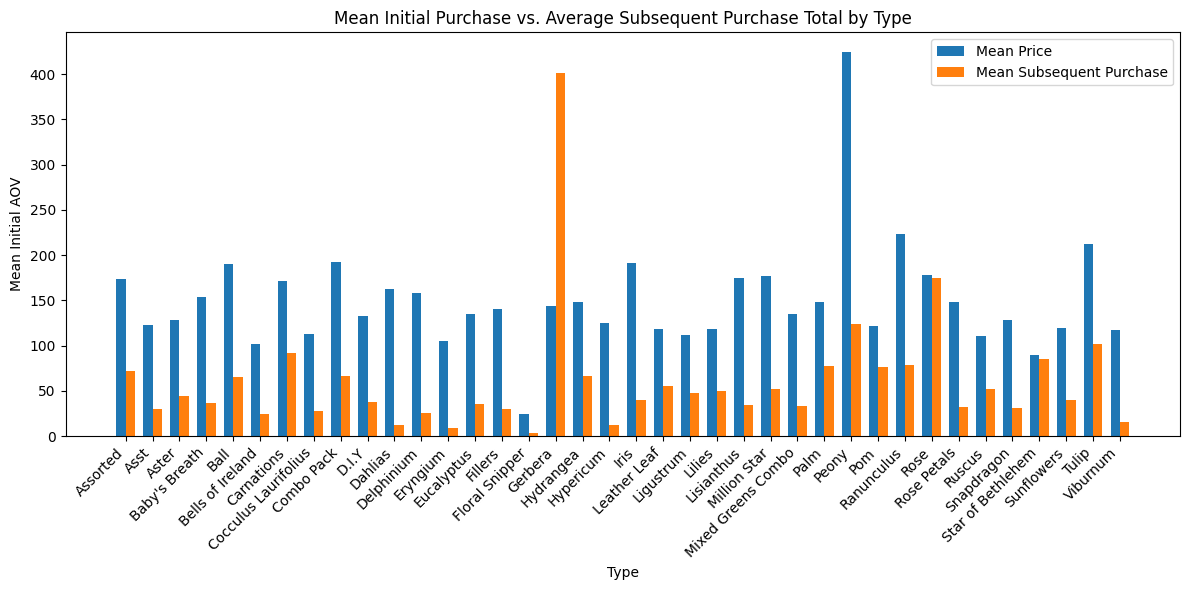

In [91]:
# Step 1: Group by 'Type' and calculate means
grouped = df_ltv.groupby('Type')[['price', 'Subsequent Purchase Total']].mean()
grouped.rename(columns={'Subsequent Purchase Total':'Average Subsequent Purchase Total'}, inplace=True)
# Step 2: Setup bar positions
types = grouped.index
x = np.arange(len(types))  # the label locations
width = 0.35  # width of the bars

# Step 3: Plot bars
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, grouped['price'], width, label='Mean Price')
bars2 = ax.bar(x + width/2, grouped['Average Subsequent Purchase Total'], width, label='Mean Subsequent Purchase')

# Step 4: Labels and formatting
ax.set_xlabel('Type')
ax.set_ylabel('Mean Initial AOV')
ax.set_title('Mean Initial Purchase vs. Average Subsequent Purchase Total by Type')
ax.set_xticks(x)
ax.set_xticklabels(types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [93]:
df_d2c.columns

Index(['order_id', 'order_date', 'ship_name', 'ship_email', 'ship_comp',
       'ship_phone', 'ship_addr', 'ship_addr2', 'ship_city', 'ship_state',
       'ship_zip', 'bill_name', 'bill_email', 'bill_comp', 'bill_phone',
       'bill_addr', 'bill_addr2', 'bill_city', 'bill_state', 'bill_zip',
       'code', 'name', 'sku', 'attr', 'quantity', 'price', 'Temple Reference',
       'Rep', 'Total Price', 'length_category', 'Product Name', 'Type',
       'Subtype', 'Subscription Type', 'Rose Variety Program Frequency',
       'Choice', 'SubType', 'Discount/Coupon Applied', 'month_year',
       'First Order Date', 'Last Order Date', 'Tenure', 'Order Date Delta',
       'First Order'],
      dtype='object')

In [94]:
len(df_d2c[(df_d2c['Type']=='Gerbera') & (df_d2c['First Order']=='Y')])

139

In [96]:
df_d2c[(df_d2c['Type']=='Gerbera') & (df_d2c['First Order']=='Y')]['ship_name'].nunique()

130

In [ ]:
grouped

In [70]:
grouped[0:20]

price  Average Subsequent Purchase Total
Type                                                          
Assorted                174                                 72
Asst                    123                                 30
Aster                   129                                 44
Baby's Breath           153                                 37
Ball                    190                                 66
Bells of Ireland        102                                 24
Carnations              172                                 92
Cocculus Laurifolius    113                                 28
Combo Pack              192                                 66
D.I.Y                   133                                 38
Dahlias                 162                                 12
Delphinium              158                                 26
Eryngium                105                                  9
Eucalyptus              135                                 36
Fillers                 140                                 29
Floral Snipper           24                                  4
Gerbera                 144                                401
Hydrangea               148                                 66
Hypericum               125                                 13
Iris                    192                                 40

Text(0.5, 0, 'Type')

Text(0, 0.5, 'Mean Values')

Text(0.5, 1.0, 'Mean Price vs. Average Subsequent Purchase Total by Type')

[Text(0, 0, 'Assorted'),
 Text(1, 0, 'Asst'),
 Text(2, 0, 'Aster'),
 Text(3, 0, "Baby's Breath"),
 Text(4, 0, 'Ball'),
 Text(5, 0, 'Bells of Ireland'),
 Text(6, 0, 'Carnations'),
 Text(7, 0, 'Cocculus Laurifolius'),
 Text(8, 0, 'Combo Pack'),
 Text(9, 0, 'D.I.Y'),
 Text(10, 0, 'Dahlias'),
 Text(11, 0, 'Delphinium'),
 Text(12, 0, 'Eryngium'),
 Text(13, 0, 'Eucalyptus'),
 Text(14, 0, 'Fillers'),
 Text(15, 0, 'Floral Snipper'),
 Text(16, 0, 'Gerbera'),
 Text(17, 0, 'Hydrangea'),
 Text(18, 0, 'Hypericum'),
 Text(19, 0, 'Iris'),
 Text(20, 0, 'Leather Leaf'),
 Text(21, 0, 'Ligustrum'),
 Text(22, 0, 'Lilies'),
 Text(23, 0, 'Lisianthus'),
 Text(24, 0, 'Million Star'),
 Text(25, 0, 'Mixed Greens Combo'),
 Text(26, 0, 'Palm'),
 Text(27, 0, 'Peony'),
 Text(28, 0, 'Pom'),
 Text(29, 0, 'Ranunculus'),
 Text(30, 0, 'Rose'),
 Text(31, 0, 'Rose Petals'),
 Text(32, 0, 'Ruscus'),
 Text(33, 0, 'Snapdragon'),
 Text(34, 0, 'Star of Bethlehem'),
 Text(35, 0, 'Sunflowers'),
 Text(36, 0, 'Tulip'),
 Text(37, 0,

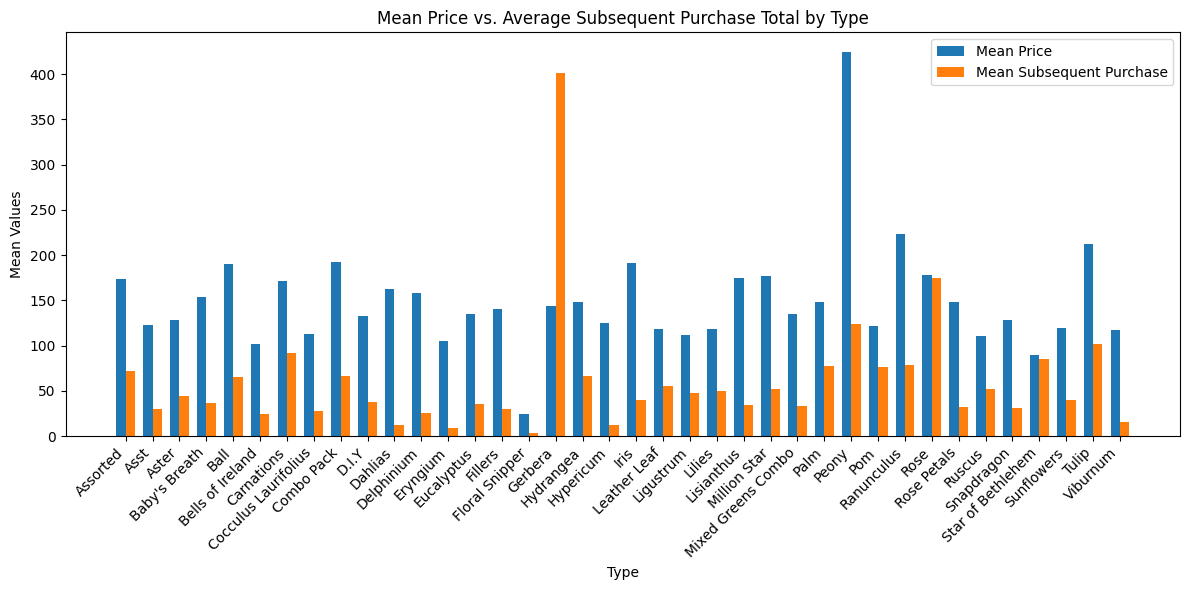

In [71]:
# Step 1: Group by 'Type' and calculate means
grouped = df_ltv.groupby('Type')[['price', 'Subsequent Purchase Total']].mean()
grouped.rename(columns={'Subsequent Purchase Total':'Average Subsequent Purchase Total'}, inplace=True)
# Step 2: Setup bar positions
types = grouped.index
x = np.arange(len(types))  # the label locations
width = 0.35  # width of the bars

# Step 3: Plot bars
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, grouped['price'], width, label='Mean Price')
bars2 = ax.bar(x + width/2, grouped['Average Subsequent Purchase Total'], width, label='Mean Subsequent Purchase')

# Step 4: Labels and formatting
ax.set_xlabel('Type')
ax.set_ylabel('Mean Values')
ax.set_title('Mean Price vs. Average Subsequent Purchase Total by Type')
ax.set_xticks(x)
ax.set_xticklabels(types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [97]:
df_ltv.columns

Index(['order_id', 'Type', 'First Order', 'price', 'Total Price',
       'First Purchase Exclusion', 'Subsequent Purchase Total'],
      dtype='object')

In [98]:
df_ltv[0:10]

order_id           Type First Order  price  Total Price  \
0   655436           Rose           Y     81           86   
1   655438           Rose           Y     82           87   
2   655445    Rose Petals           Y    106          106   
3   655454           Rose           Y    156          160   
4   655456       Assorted           Y     74           78   
5   655458           Rose           Y     83           89   
6   655459  Baby's Breath           Y     72          141   
7   655459          D.I.Y           Y     69          141   
8   655462           Rose           Y     89           97   
9   655464           Rose           Y    121          125   

  First Purchase Exclusion  Subsequent Purchase Total  
0                        5                          0  
1                        5                          0  
2                        0                          0  
3                        4                          0  
4                        4                          0  
5                        6                      1,238  
6                       69                          0  
7                       72                          0  
8                        8                          0  
9                        4                        130

In [104]:
grouped.columns

Index(['price', 'Average Subsequent Purchase Total'], dtype='object')

In [111]:
df_aq = df_d2c.groupby(['Type', 'First Order']).agg({'price':'sum'}).reset_index()
df_aq = df_aq[df_aq['First Order']=='Y']
df_aq.rename(columns={'price':'Total Revenue from First Purchase'}, inplace=True)
df_aq = df_aq[['Type', 'Total Revenue from First Purchase']]
grouped2 = grouped.reset_index()
grouped2 = grouped2[['Type', 'Average Subsequent Purchase Total']]
df_merge = df_aq.merge(grouped2, how='outer')

<Figure size 1000x800 with 0 Axes>

<Axes: xlabel='Average Subsequent Purchase Total', ylabel='Total Revenue from First Purchase'>

(-16.33822006472492, 143.9598780487805)

(-14768.51, 1033983.39)

Text(71.88582135076253, 1013983.39, 'Assorted')

Text(30.005409836065574, nan, 'Asst')

Text(43.91509727626459, 26045.59, 'Aster')

Text(36.794599092284415, 173195.78, "Baby's Breath")

Text(65.53854166666667, 7162.6, 'Ball')

Text(24.406363636363636, 9289.07, 'Bells of Ireland')

Text(91.77515465587044, 891905.25, 'Carnations')

Text(27.51434146341463, 19054.22, 'Cocculus Laurifolius')

Text(66.28423076923077, 24538.65, 'Combo Pack')

Text(37.624123931623934, 52044.45, 'D.I.Y')

Text(12.39753623188406, 21060.46, 'Dahlias')

Text(25.858759689922483, 17493.89, 'Delphinium')

Text(9.134054054054053, 7072.32, 'Eryngium')

Text(36.014239917269904, 111994.8, 'Eucalyptus')

Text(29.384041916167664, 39612.16, 'Fillers')

Text(3.661779935275081, 6341.129999999999, 'Floral Snipper')

Text(66.39842234499693, 202193.81, 'Hydrangea')

Text(12.679855072463768, 7733.34, 'Hypericum')

Text(40.292692307692306, 12811.29, 'Iris')

Text(54.923853820598, 55612.75, 'Leather Leaf')

Text(47.90507462686567, 5231.49, 'Ligustrum')

Text(49.49147212958551, 205594.31, 'Lilies')

Text(34.095051020408164, 28286.2, 'Lisianthus')

Text(52.02186440677966, 16935.89, 'Million Star')

Text(32.95143362831859, 64079.83, 'Mixed Greens Combo')

Text(77.17921052631579, 7475.39, 'Palm')

Text(123.9598780487805, 28172.28, 'Peony')

Text(76.18829842931937, 36611.27, 'Pom')

Text(78.65955465587045, 46317.57, 'Ranunculus')

Text(32.32225409836066, 129982.1, 'Rose Petals')

Text(52.479385171790234, 47235.369999999995, 'Ruscus')

Text(31.462176470588233, 17981.5, 'Snapdragon')

Text(85.04860465116279, 5737.33, 'Star of Bethlehem')

Text(40.41728016359918, 45561.909999999996, 'Sunflowers')

Text(102.05, 32652.38, 'Tulip')

Text(15.736769230769228, 6744.38, 'Viburnum')

Text(-16.33822006472492, 1033983.39, 'Q2')

Text(143.9598780487805, 1033983.39, 'Q1')

Text(-16.33822006472492, -14768.51, 'Q3')

Text(143.9598780487805, -14768.51, 'Q4')

Text(0.5, 1.0, 'Scatter Matrix of Value by Type')

Text(0.5, 0, 'Average Subsequent Purchase Total')

Text(0, 0.5, 'Total Revenue from First Purchase')

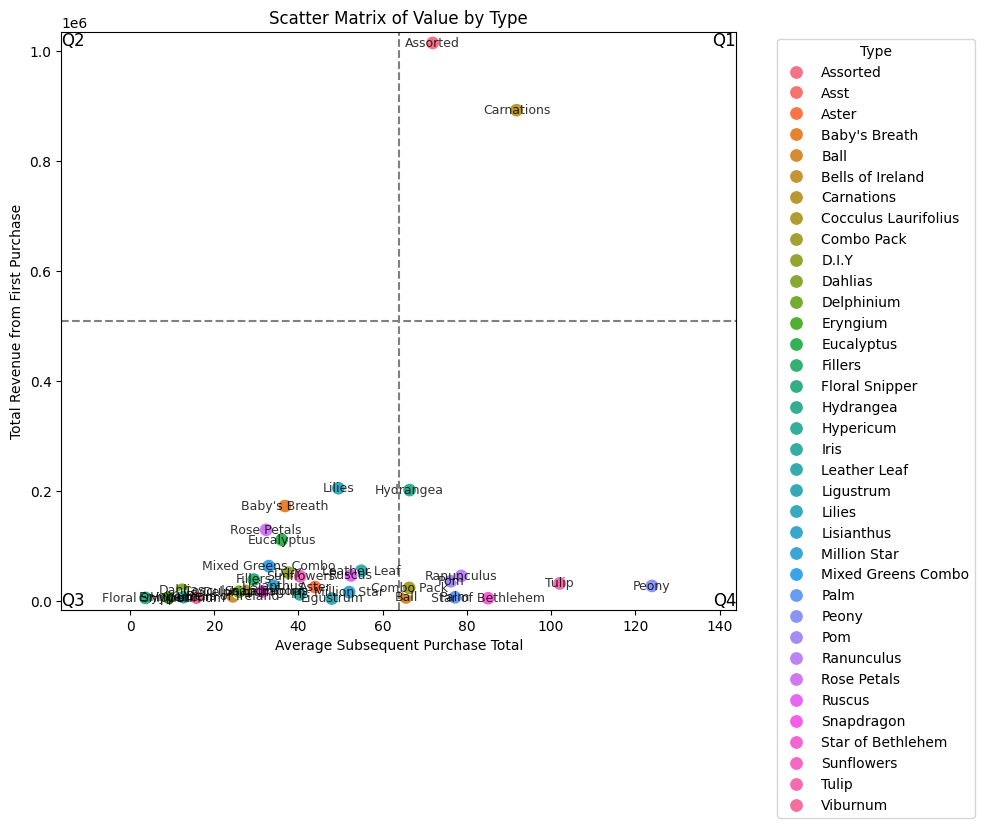

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

df_merge2 = df_merge[(df_merge['Type'] != 'Rose') & (df_merge['Type'] != 'Gerbera')]

# Set axis variables
x = 'Average Subsequent Purchase Total'
y = 'Total Revenue from First Purchase'

# Calculate min, max, and padding
x_min, x_max = df_merge2[x].min() - 20, df_merge2[x].max() + 20
y_min, y_max = df_merge2[y].min() - 20000, df_merge2[y].max() + 20000

# Get midpoints for quadrant lines
x_mid = (x_min + x_max) / 2
y_mid = (y_min + y_max) / 2

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_merge2, x=x, y=y, hue='Type', s=100)

# Draw quadrant lines
plt.axvline(x=x_mid, color='gray', linestyle='--')
plt.axhline(y=y_mid, color='gray', linestyle='--')

# Set axis limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add labels to each dot
for i in range(len(df_merge2)):
    plt.text(
        df_merge2[x].iloc[i],
        df_merge2[y].iloc[i],
        str(df_merge2['Type'].iloc[i]),
        fontsize=9,
        ha='center',
        va='center',
        color='black',
        alpha=0.8
    )

# Add quadrant labels
plt.text(x_min, y_max, 'Q2', fontsize=12, verticalalignment='top')
plt.text(x_max, y_max, 'Q1', fontsize=12, verticalalignment='top', horizontalalignment='right')
plt.text(x_min, y_min, 'Q3', fontsize=12, verticalalignment='bottom')
plt.text(x_max, y_min, 'Q4', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

# Final formatting
plt.title('Scatter Matrix of Value by Type')
plt.xlabel(x)
plt.ylabel(y)
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

<Axes: xlabel='Average Subsequent Purchase Total', ylabel='Total Revenue from First Purchase'>

(-16.33822006472492, 143.9598780487805)

(-14768.51, 1033983.39)

Text(-16.33822006472492, 1033983.39, 'Q2')

Text(143.9598780487805, 1033983.39, 'Q1')

Text(-16.33822006472492, -14768.51, 'Q3')

Text(143.9598780487805, -14768.51, 'Q4')

Text(0.5, 1.0, 'Scatter Plot with Quadrants by Type (excluding Roses and Gerbera)')

Text(0.5, 0, 'Average Subsequent Purchase Total')

Text(0, 0.5, 'Total Revenue from First Purchase (in millions)')

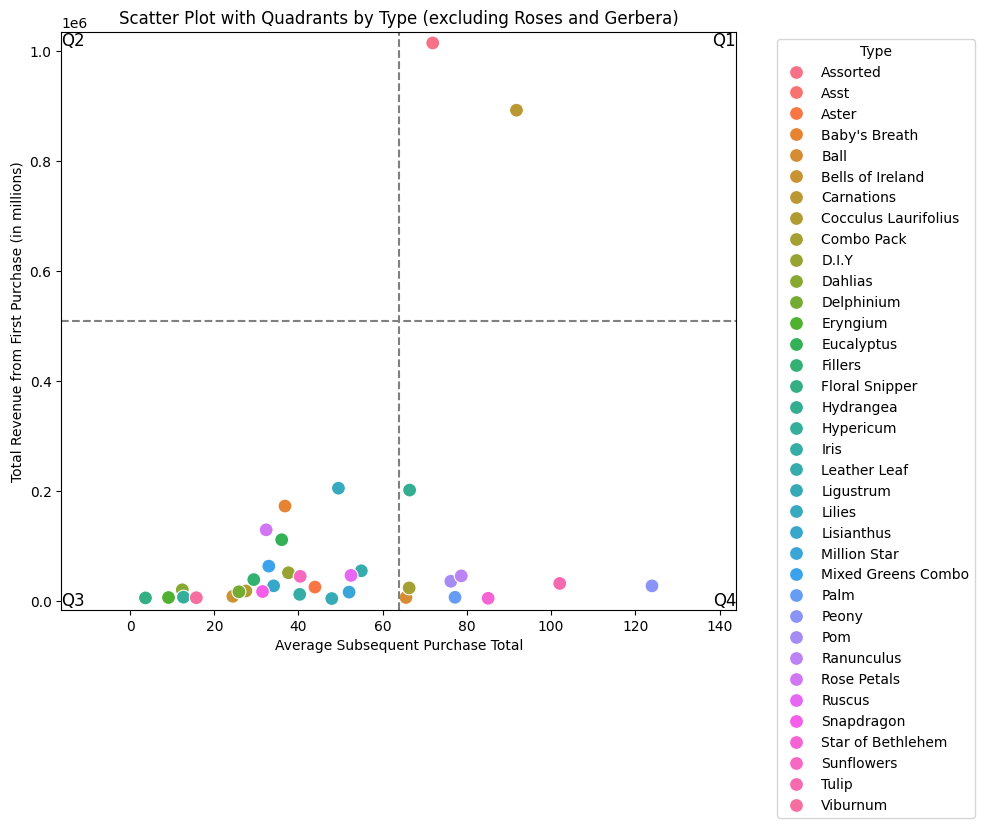

In [129]:
df_merge2 = df_merge[(df_merge['Type']!='Rose')&(df_merge['Type']!='Gerbera')]
# Set axis variables
x = 'Average Subsequent Purchase Total'
y = 'Total Revenue from First Purchase'

# Calculate min, max, and padding
x_min, x_max = df_merge2[x].min() - 20, df_merge2[x].max() + 20
y_min, y_max = df_merge2[y].min() - 20000, df_merge2[y].max() + 20000

# Get midpoints for quadrant lines
x_mid = (x_min + x_max) / 2
y_mid = (y_min + y_max) / 2

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_merge2, x=x, y=y, hue='Type', s=100)

# Draw quadrant lines
plt.axvline(x=x_mid, color='gray', linestyle='--')
plt.axhline(y=y_mid, color='gray', linestyle='--')

# Set axis limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add quadrant labels if needed
plt.text(x_min, y_max, 'Q2', fontsize=12, verticalalignment='top')
plt.text(x_max, y_max, 'Q1', fontsize=12, verticalalignment='top', horizontalalignment='right')
plt.text(x_min, y_min, 'Q3', fontsize=12, verticalalignment='bottom')
plt.text(x_max, y_min, 'Q4', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

plt.title('Scatter Plot with Quadrants by Type (excluding Roses and Gerbera)')
plt.xlabel(x)
plt.ylabel('Total Revenue from First Purchase (in millions)')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

<Axes: xlabel='Average Subsequent Purchase Total', ylabel='Total Revenue from First Purchase'>

(-16.33822006472492, 420.8175)

(5231.29, 4620407.5600000005)

Text(-16.33822006472492, 4620407.5600000005, 'Q2')

Text(420.8175, 4620407.5600000005, 'Q1')

Text(-16.33822006472492, 5231.29, 'Q3')

Text(420.8175, 5231.29, 'Q4')

Text(0.5, 1.0, 'Scatter Plot with Quadrants by Type')

Text(0.5, 0, 'Average Subsequent Purchase Total')

Text(0, 0.5, 'Total Revenue from First Purchase')

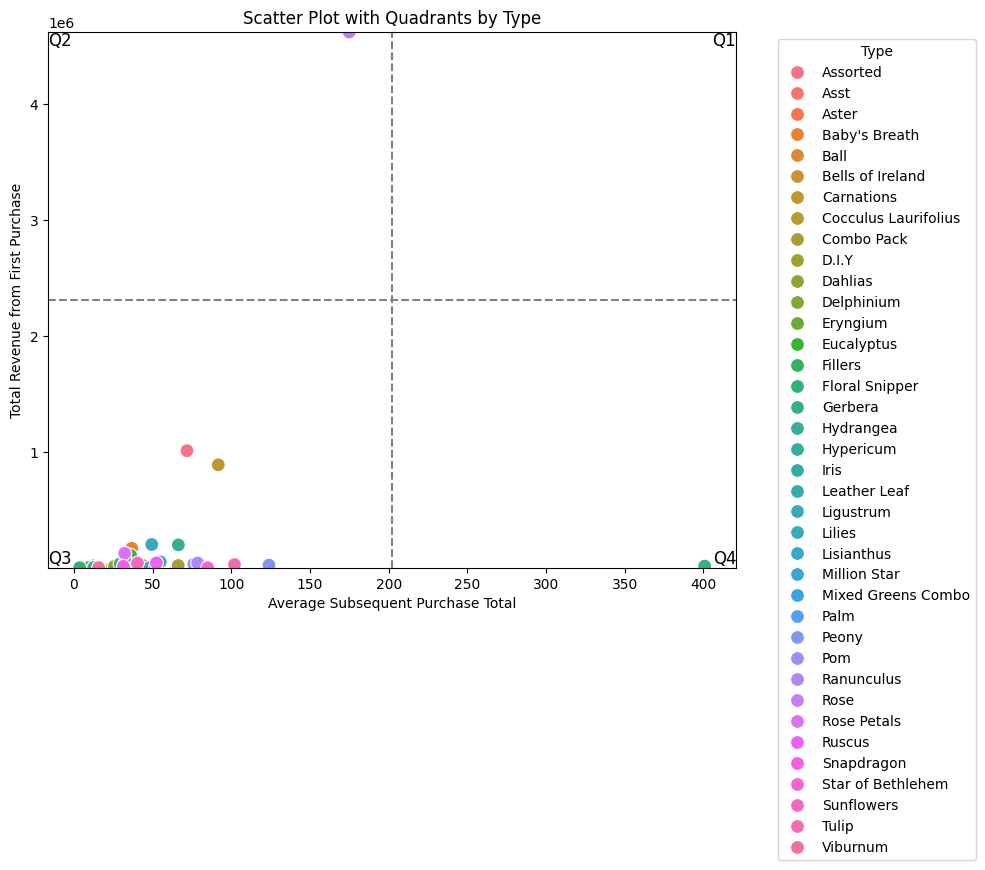

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set axis variables
x = 'Average Subsequent Purchase Total'
y = 'Total Revenue from First Purchase'

# Calculate min, max, and padding
x_min, x_max = df_merge2[x].min() - 20, df_merge[x].max() + 20
y_min, y_max = df_merge2[y].min() - 0.2, df_merge[y].max() + 0.2

# Midpoints for quadrant lines
x_mid = (df_merge[x].min() + df_merge[x].max()) / 2
y_mid = (df_merge[y].min() + df_merge[y].max()) / 2

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_merge, x=x, y=y, hue='Type', s=100)

# Draw quadrant lines
plt.axvline(x=x_mid, color='gray', linestyle='--')
plt.axhline(y=y_mid, color='gray', linestyle='--')

# Set padded axis limits
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Add quadrant labels
plt.text(x_min, y_max, 'Q2', fontsize=12, verticalalignment='top')
plt.text(x_max, y_max, 'Q1', fontsize=12, verticalalignment='top', horizontalalignment='right')
plt.text(x_min, y_min, 'Q3', fontsize=12, verticalalignment='bottom')
plt.text(x_max, y_min, 'Q4', fontsize=12, verticalalignment='bottom', horizontalalignment='right')

plt.title('Scatter Plot with Quadrants by Type')
plt.xlabel(x)
plt.ylabel(y)
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

Text(71.88582135076253, 1013983.39, 'Assorted')

Text(30.005409836065574, nan, 'Asst')

Text(43.91509727626459, 26045.59, 'Aster')

Text(36.794599092284415, 173195.78, "Baby's Breath")

Text(65.53854166666667, 7162.6, 'Ball')

Text(24.406363636363636, 9289.07, 'Bells of Ireland')

Text(91.77515465587044, 891905.25, 'Carnations')

Text(27.51434146341463, 19054.22, 'Cocculus Laurifolius')

Text(66.28423076923077, 24538.65, 'Combo Pack')

Text(37.624123931623934, 52044.45, 'D.I.Y')

Text(12.39753623188406, 21060.46, 'Dahlias')

Text(25.858759689922483, 17493.89, 'Delphinium')

Text(9.134054054054053, 7072.32, 'Eryngium')

Text(36.014239917269904, 111994.8, 'Eucalyptus')

Text(29.384041916167664, 39612.16, 'Fillers')

Text(3.661779935275081, 6341.129999999999, 'Floral Snipper')

Text(400.8175, 19725.54, 'Gerbera')

Text(66.39842234499693, 202193.81, 'Hydrangea')

Text(12.679855072463768, 7733.34, 'Hypericum')

Text(40.292692307692306, 12811.29, 'Iris')

Text(54.923853820598, 55612.75, 'Leather Leaf')

Text(47.90507462686567, 5231.49, 'Ligustrum')

Text(49.49147212958551, 205594.31, 'Lilies')

Text(34.095051020408164, 28286.2, 'Lisianthus')

Text(52.02186440677966, 16935.89, 'Million Star')

Text(32.95143362831859, 64079.83, 'Mixed Greens Combo')

Text(77.17921052631579, 7475.39, 'Palm')

Text(123.9598780487805, 28172.28, 'Peony')

Text(76.18829842931937, 36611.27, 'Pom')

Text(78.65955465587045, 46317.57, 'Ranunculus')

Text(174.932204007286, 4620407.36, 'Rose')

Text(32.32225409836066, 129982.1, 'Rose Petals')

Text(52.479385171790234, 47235.369999999995, 'Ruscus')

Text(31.462176470588233, 17981.5, 'Snapdragon')

Text(85.04860465116279, 5737.33, 'Star of Bethlehem')

Text(40.41728016359918, 45561.909999999996, 'Sunflowers')

Text(102.05, 32652.38, 'Tulip')

Text(15.736769230769228, 6744.38, 'Viburnum')

Text(0.5, 0, 'Average Subsequent Purchase Total')

Text(0, 0.5, 'Total Revenue from First Purchase')

Text(0.5, 1.0, 'Quadrant Analysis of Flower Type Performance')

Text(60.37386658512294, 4620407.36, 'Mean X: 60.37')

Text(3.661779935275081, 217942.62297297298, 'Mean Y: 217942.62')

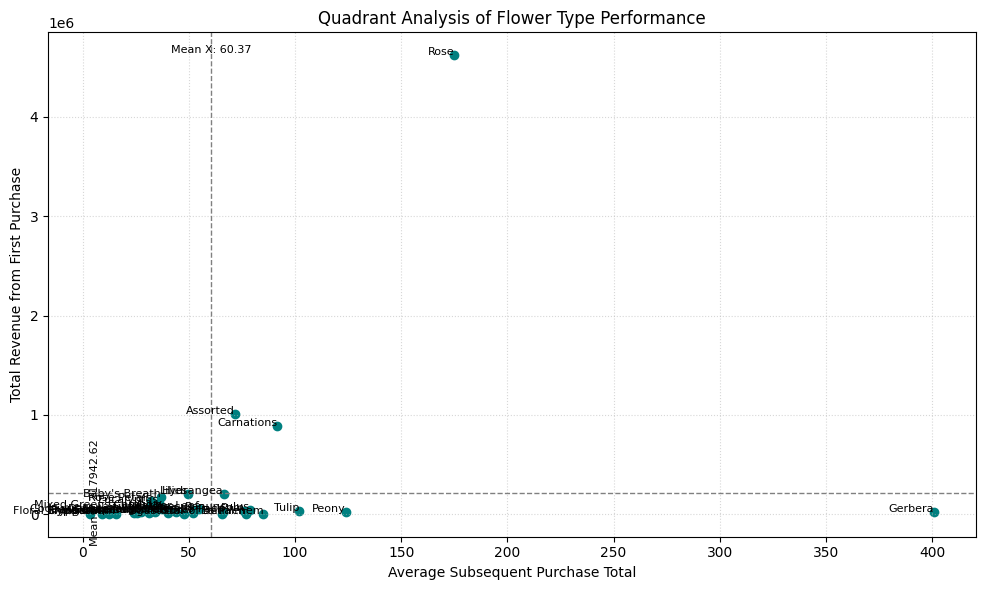

In [114]:
# Define axes from df_merge
x = df_merge['Average Subsequent Purchase Total']
y = df_merge['Total Revenue from First Purchase']

# Compute midpoints for quadrant dividers
x_mid = x.mean()
y_mid = y.mean()

plt.figure(figsize=(10, 6))
plt.grid(True, linestyle=':', alpha=0.5)

# Plot scatter points
plt.scatter(x, y, color='teal')

# Add horizontal and vertical lines to form quadrants
plt.axhline(y=y_mid, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=x_mid, color='gray', linestyle='--', linewidth=1)

# Annotate each point with 'Type'
for i, row in df_merge.iterrows():
    plt.text(
        row['Average Subsequent Purchase Total'],
        row['Total Revenue from First Purchase'],
        row['Type'], fontsize=8, ha='right'
    )

# Label axes and chart
plt.xlabel('Average Subsequent Purchase Total')
plt.ylabel('Total Revenue from First Purchase')
plt.title('Quadrant Analysis of Flower Type Performance')

# Optional: show axis midpoints as text
plt.text(x_mid, y.max(), f'Mean X: {x_mid:.2f}', va='bottom', ha='center', fontsize=8)
plt.text(x.min(), y_mid, f'Mean Y: {y_mid:.2f}', va='center', ha='left', fontsize=8, rotation=90)

plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>

Text(71.88582135076253, 1013983.39, 'Assorted')

Text(30.005409836065574, nan, 'Asst')

Text(43.91509727626459, 26045.59, 'Aster')

Text(36.794599092284415, 173195.78, "Baby's Breath")

Text(65.53854166666667, 7162.6, 'Ball')

Text(24.406363636363636, 9289.07, 'Bells of Ireland')

Text(91.77515465587044, 891905.25, 'Carnations')

Text(27.51434146341463, 19054.22, 'Cocculus Laurifolius')

Text(66.28423076923077, 24538.65, 'Combo Pack')

Text(37.624123931623934, 52044.45, 'D.I.Y')

Text(12.39753623188406, 21060.46, 'Dahlias')

Text(25.858759689922483, 17493.89, 'Delphinium')

Text(9.134054054054053, 7072.32, 'Eryngium')

Text(36.014239917269904, 111994.8, 'Eucalyptus')

Text(29.384041916167664, 39612.16, 'Fillers')

Text(3.661779935275081, 6341.129999999999, 'Floral Snipper')

Text(400.8175, 19725.54, 'Gerbera')

Text(66.39842234499693, 202193.81, 'Hydrangea')

Text(12.679855072463768, 7733.34, 'Hypericum')

Text(40.292692307692306, 12811.29, 'Iris')

Text(54.923853820598, 55612.75, 'Leather Leaf')

Text(47.90507462686567, 5231.49, 'Ligustrum')

Text(49.49147212958551, 205594.31, 'Lilies')

Text(34.095051020408164, 28286.2, 'Lisianthus')

Text(52.02186440677966, 16935.89, 'Million Star')

Text(32.95143362831859, 64079.83, 'Mixed Greens Combo')

Text(77.17921052631579, 7475.39, 'Palm')

Text(123.9598780487805, 28172.28, 'Peony')

Text(76.18829842931937, 36611.27, 'Pom')

Text(78.65955465587045, 46317.57, 'Ranunculus')

Text(174.932204007286, 4620407.36, 'Rose')

Text(32.32225409836066, 129982.1, 'Rose Petals')

Text(52.479385171790234, 47235.369999999995, 'Ruscus')

Text(31.462176470588233, 17981.5, 'Snapdragon')

Text(85.04860465116279, 5737.33, 'Star of Bethlehem')

Text(40.41728016359918, 45561.909999999996, 'Sunflowers')

Text(102.05, 32652.38, 'Tulip')

Text(15.736769230769228, 6744.38, 'Viburnum')

(-16.196006067961164, 420.67528600323624)

(-225527.30350000004, 4851166.1535)

Text(0.5, 0, 'Average Subsequent Purchase Total')

Text(0, 0.5, 'Total Revenue from First Purchase')

Text(0.5, 1.0, '4-Quadrant Analysis (Axes Centered at Means)')

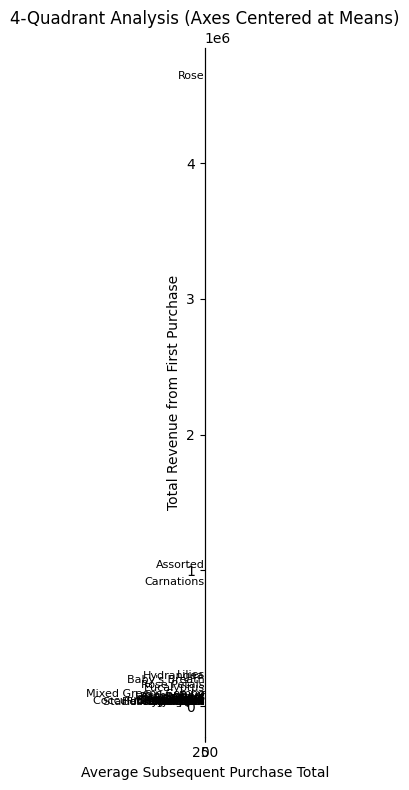

In [118]:
# Define axes
x = df_merge['Average Subsequent Purchase Total']
y = df_merge['Total Revenue from First Purchase']

# Get real min/max ranges
x_min, x_max = x.min(), x.max()
y_min, y_max = y.min(), y.max()

# Get midpoints (means) for quadrant lines
x_mid = x.mean()
y_mid = y.mean()

# Create the figure
plt.figure(figsize=(8, 8))
plt.grid(True, linestyle=':', alpha=0.5)

# Plot points
plt.scatter(x, y, color='teal')

# Label points
for i, row in df_merge.iterrows():
    plt.text(row['Average Subsequent Purchase Total'],
             row['Total Revenue from First Purchase'],
             row['Type'],
             fontsize=8, ha='right')

# Draw quadrant lines at mean values
plt.axhline(y=y_mid, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=x_mid, color='gray', linestyle='--', linewidth=1)

# Set actual full data range
plt.xlim(x_min - (x_max - x_min)*0.05, x_max + (x_max - x_min)*0.05)
plt.ylim(y_min - (y_max - y_min)*0.05, y_max + (y_max - y_min)*0.05)

# Ensure equal aspect ratio for balanced layout
plt.gca().set_aspect('equal', adjustable='box')

# Labels and title
plt.xlabel('Average Subsequent Purchase Total')
plt.ylabel('Total Revenue from First Purchase')
plt.title('4-Quadrant Analysis (Axes Centered at Means)')

plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>

Text(71.88582135076253, 1013983.39, 'Assorted')

Text(30.005409836065574, nan, 'Asst')

Text(43.91509727626459, 26045.59, 'Aster')

Text(36.794599092284415, 173195.78, "Baby's Breath")

Text(65.53854166666667, 7162.6, 'Ball')

Text(24.406363636363636, 9289.07, 'Bells of Ireland')

Text(91.77515465587044, 891905.25, 'Carnations')

Text(27.51434146341463, 19054.22, 'Cocculus Laurifolius')

Text(66.28423076923077, 24538.65, 'Combo Pack')

Text(37.624123931623934, 52044.45, 'D.I.Y')

Text(12.39753623188406, 21060.46, 'Dahlias')

Text(25.858759689922483, 17493.89, 'Delphinium')

Text(9.134054054054053, 7072.32, 'Eryngium')

Text(36.014239917269904, 111994.8, 'Eucalyptus')

Text(29.384041916167664, 39612.16, 'Fillers')

Text(3.661779935275081, 6341.129999999999, 'Floral Snipper')

Text(400.8175, 19725.54, 'Gerbera')

Text(66.39842234499693, 202193.81, 'Hydrangea')

Text(12.679855072463768, 7733.34, 'Hypericum')

Text(40.292692307692306, 12811.29, 'Iris')

Text(54.923853820598, 55612.75, 'Leather Leaf')

Text(47.90507462686567, 5231.49, 'Ligustrum')

Text(49.49147212958551, 205594.31, 'Lilies')

Text(34.095051020408164, 28286.2, 'Lisianthus')

Text(52.02186440677966, 16935.89, 'Million Star')

Text(32.95143362831859, 64079.83, 'Mixed Greens Combo')

Text(77.17921052631579, 7475.39, 'Palm')

Text(123.9598780487805, 28172.28, 'Peony')

Text(76.18829842931937, 36611.27, 'Pom')

Text(78.65955465587045, 46317.57, 'Ranunculus')

Text(174.932204007286, 4620407.36, 'Rose')

Text(32.32225409836066, 129982.1, 'Rose Petals')

Text(52.479385171790234, 47235.369999999995, 'Ruscus')

Text(31.462176470588233, 17981.5, 'Snapdragon')

Text(85.04860465116279, 5737.33, 'Star of Bethlehem')

Text(40.41728016359918, 45561.909999999996, 'Sunflowers')

Text(102.05, 32652.38, 'Tulip')

Text(15.736769230769228, 6744.38, 'Viburnum')

(-4620407.36, 4620407.36)

(-4620407.36, 4620407.36)

Text(0.5, 0, 'Average Subsequent Purchase Total')

Text(0, 0.5, 'Total Revenue from First Purchase')

Text(0.5, 1.0, '4-Quadrant Scatter Plot with Equal Scaling')

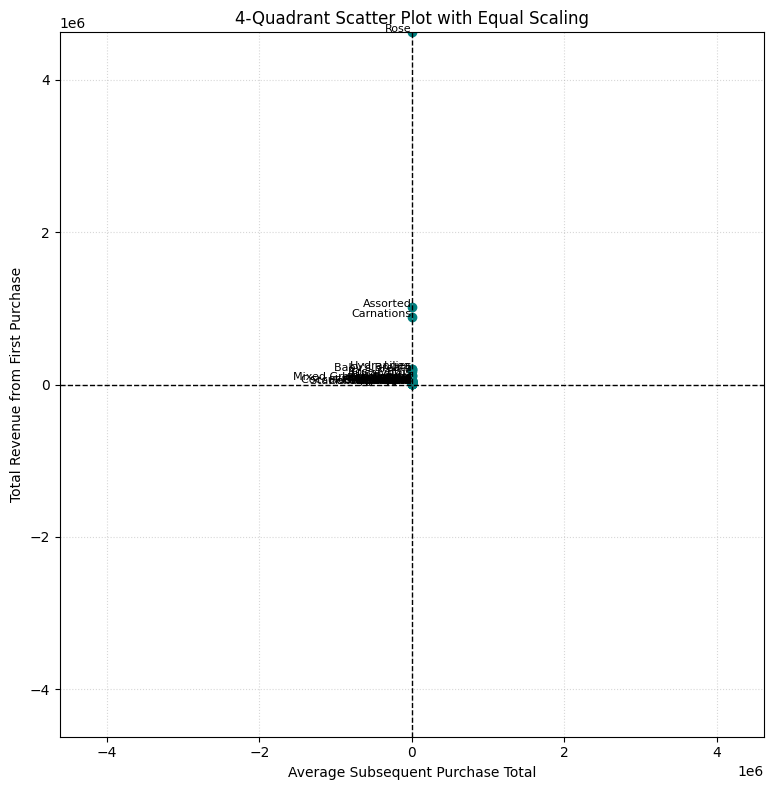

In [117]:
# Define x and y from your DataFrame
x = df_merge['Average Subsequent Purchase Total']
y = df_merge['Total Revenue from First Purchase']

# Calculate the symmetric max range for both axes
max_range = max(abs(x.min()), abs(x.max()), abs(y.min()), abs(y.max()))

# Create square figure
plt.figure(figsize=(8, 8))
plt.grid(True, linestyle=':', alpha=0.5)

# Plot the points
plt.scatter(x, y, color='teal')

# Draw the quadrant lines at x=0 and y=0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

# Label each point with its 'Type'
for i, row in df_merge.iterrows():
    plt.text(row['Average Subsequent Purchase Total'],
             row['Total Revenue from First Purchase'],
             row['Type'],
             fontsize=8, ha='right')

# Force both x and y axes to use the same symmetric range
plt.xlim(-max_range, max_range)
plt.ylim(-max_range, max_range)

# Lock the aspect ratio so the plot is square
plt.gca().set_aspect('equal', adjustable='box')

# Add labels
plt.xlabel('Average Subsequent Purchase Total')
plt.ylabel('Total Revenue from First Purchase')
plt.title('4-Quadrant Scatter Plot with Equal Scaling')

plt.tight_layout()
plt.show()

<Figure size 800x800 with 0 Axes>

Text(71.88582135076253, 1013983.39, 'Assorted')

Text(30.005409836065574, nan, 'Asst')

Text(43.91509727626459, 26045.59, 'Aster')

Text(36.794599092284415, 173195.78, "Baby's Breath")

Text(65.53854166666667, 7162.6, 'Ball')

Text(24.406363636363636, 9289.07, 'Bells of Ireland')

Text(91.77515465587044, 891905.25, 'Carnations')

Text(27.51434146341463, 19054.22, 'Cocculus Laurifolius')

Text(66.28423076923077, 24538.65, 'Combo Pack')

Text(37.624123931623934, 52044.45, 'D.I.Y')

Text(12.39753623188406, 21060.46, 'Dahlias')

Text(25.858759689922483, 17493.89, 'Delphinium')

Text(9.134054054054053, 7072.32, 'Eryngium')

Text(36.014239917269904, 111994.8, 'Eucalyptus')

Text(29.384041916167664, 39612.16, 'Fillers')

Text(3.661779935275081, 6341.129999999999, 'Floral Snipper')

Text(400.8175, 19725.54, 'Gerbera')

Text(66.39842234499693, 202193.81, 'Hydrangea')

Text(12.679855072463768, 7733.34, 'Hypericum')

Text(40.292692307692306, 12811.29, 'Iris')

Text(54.923853820598, 55612.75, 'Leather Leaf')

Text(47.90507462686567, 5231.49, 'Ligustrum')

Text(49.49147212958551, 205594.31, 'Lilies')

Text(34.095051020408164, 28286.2, 'Lisianthus')

Text(52.02186440677966, 16935.89, 'Million Star')

Text(32.95143362831859, 64079.83, 'Mixed Greens Combo')

Text(77.17921052631579, 7475.39, 'Palm')

Text(123.9598780487805, 28172.28, 'Peony')

Text(76.18829842931937, 36611.27, 'Pom')

Text(78.65955465587045, 46317.57, 'Ranunculus')

Text(174.932204007286, 4620407.36, 'Rose')

Text(32.32225409836066, 129982.1, 'Rose Petals')

Text(52.479385171790234, 47235.369999999995, 'Ruscus')

Text(31.462176470588233, 17981.5, 'Snapdragon')

Text(85.04860465116279, 5737.33, 'Star of Bethlehem')

Text(40.41728016359918, 45561.909999999996, 'Sunflowers')

Text(102.05, 32652.38, 'Tulip')

Text(15.736769230769228, 6744.38, 'Viburnum')

(-4620407.36, 4620407.36)

(-4620407.36, 4620407.36)

Text(0.5, 0, 'Average Subsequent Purchase Total')

Text(0, 0.5, 'Total Revenue from First Purchase')

Text(0.5, 1.0, 'True 4-Quadrant Scatter Plot')

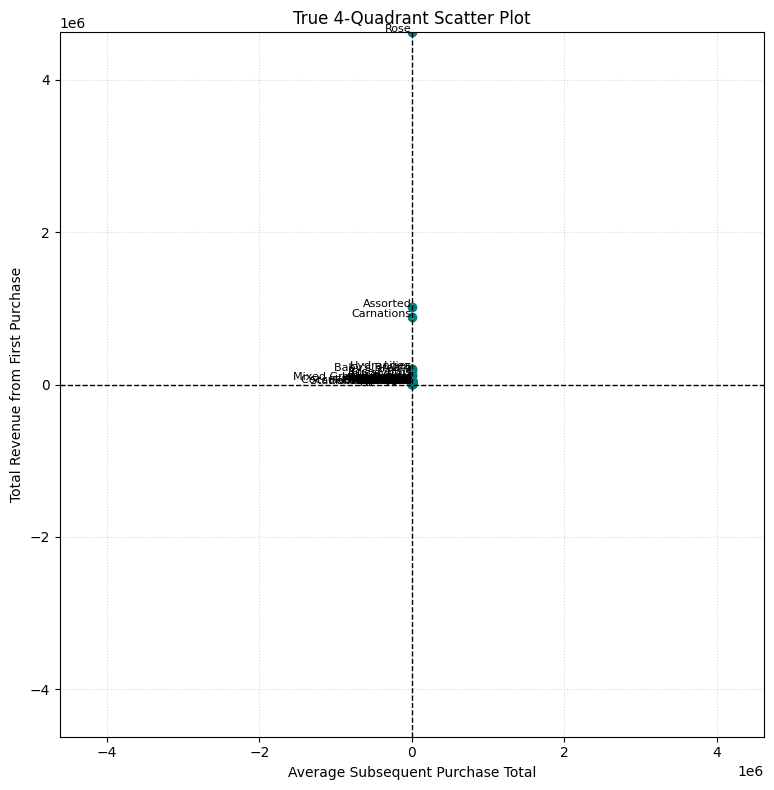

In [116]:
# Pull your x and y values
x = df_merge['Average Subsequent Purchase Total']
y = df_merge['Total Revenue from First Purchase']

# Determine max range to make square aspect
range_limit = max(abs(x.min()), abs(x.max()), abs(y.min()), abs(y.max()))

plt.figure(figsize=(8, 8))  # Make figure square
plt.grid(True, linestyle=':', alpha=0.5)

# Scatter plot
plt.scatter(x, y, color='teal')

# Draw quadrant lines at x=0 and y=0
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Label each point
for i, row in df_merge.iterrows():
    plt.text(row['Average Subsequent Purchase Total'],
             row['Total Revenue from First Purchase'],
             row['Type'],
             fontsize=8, ha='right')

# Force axes to have same limits so quadrants are equal in size
plt.xlim(-range_limit, range_limit)
plt.ylim(-range_limit, range_limit)

# Make the aspect ratio square
plt.gca().set_aspect('equal', adjustable='box')

# Axis labels and title
plt.xlabel('Average Subsequent Purchase Total')
plt.ylabel('Total Revenue from First Purchase')
plt.title('True 4-Quadrant Scatter Plot')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

Text(71.88582135076253, 1013983.39, 'Assorted')

Text(30.005409836065574, nan, 'Asst')

Text(43.91509727626459, 26045.59, 'Aster')

Text(36.794599092284415, 173195.78, "Baby's Breath")

Text(65.53854166666667, 7162.6, 'Ball')

Text(24.406363636363636, 9289.07, 'Bells of Ireland')

Text(91.77515465587044, 891905.25, 'Carnations')

Text(27.51434146341463, 19054.22, 'Cocculus Laurifolius')

Text(66.28423076923077, 24538.65, 'Combo Pack')

Text(37.624123931623934, 52044.45, 'D.I.Y')

Text(12.39753623188406, 21060.46, 'Dahlias')

Text(25.858759689922483, 17493.89, 'Delphinium')

Text(9.134054054054053, 7072.32, 'Eryngium')

Text(36.014239917269904, 111994.8, 'Eucalyptus')

Text(29.384041916167664, 39612.16, 'Fillers')

Text(3.661779935275081, 6341.129999999999, 'Floral Snipper')

Text(400.8175, 19725.54, 'Gerbera')

Text(66.39842234499693, 202193.81, 'Hydrangea')

Text(12.679855072463768, 7733.34, 'Hypericum')

Text(40.292692307692306, 12811.29, 'Iris')

Text(54.923853820598, 55612.75, 'Leather Leaf')

Text(47.90507462686567, 5231.49, 'Ligustrum')

Text(49.49147212958551, 205594.31, 'Lilies')

Text(34.095051020408164, 28286.2, 'Lisianthus')

Text(52.02186440677966, 16935.89, 'Million Star')

Text(32.95143362831859, 64079.83, 'Mixed Greens Combo')

Text(77.17921052631579, 7475.39, 'Palm')

Text(123.9598780487805, 28172.28, 'Peony')

Text(76.18829842931937, 36611.27, 'Pom')

Text(78.65955465587045, 46317.57, 'Ranunculus')

Text(174.932204007286, 4620407.36, 'Rose')

Text(32.32225409836066, 129982.1, 'Rose Petals')

Text(52.479385171790234, 47235.369999999995, 'Ruscus')

Text(31.462176470588233, 17981.5, 'Snapdragon')

Text(85.04860465116279, 5737.33, 'Star of Bethlehem')

Text(40.41728016359918, 45561.909999999996, 'Sunflowers')

Text(102.05, 32652.38, 'Tulip')

Text(15.736769230769228, 6744.38, 'Viburnum')

Text(0.5, 0, 'Average Subsequent Purchase Total')

Text(0, 0.5, 'Total Revenue from First Purchase')

Text(0.5, 1.0, '4-Quadrant Cartesian Scatter Plot: Flower Type Performance')

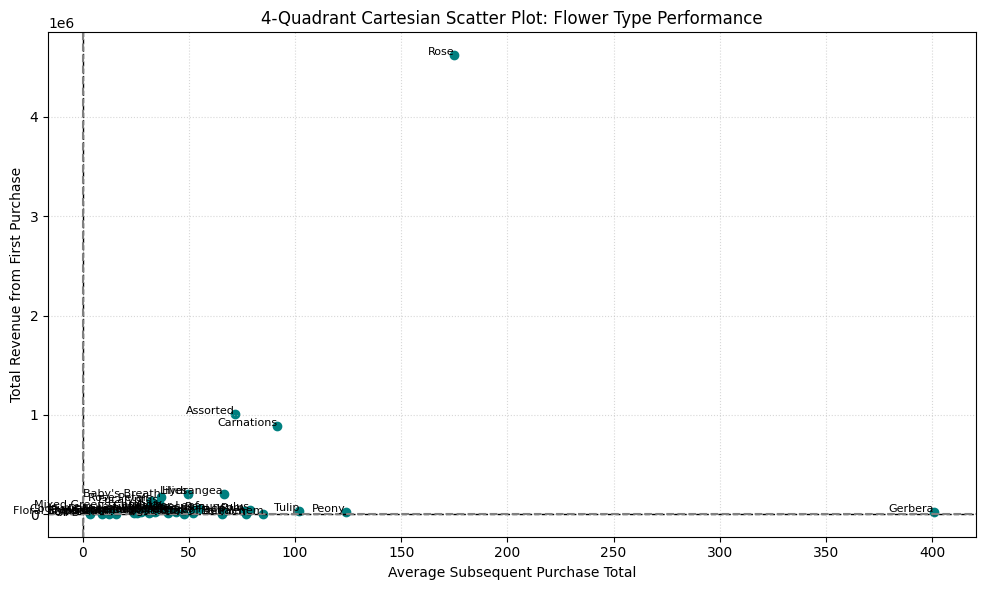

In [115]:
# Define x and y from df_merge
x = df_merge['Average Subsequent Purchase Total']
y = df_merge['Total Revenue from First Purchase']

plt.figure(figsize=(10, 6))
plt.grid(True, linestyle=':', alpha=0.5)

# Plot scatter points
plt.scatter(x, y, color='teal')

# Draw vertical and horizontal lines at x=0 and y=0 for real quadrants
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)

# Label each dot with 'Type'
for i, row in df_merge.iterrows():
    plt.text(
        row['Average Subsequent Purchase Total'],
        row['Total Revenue from First Purchase'],
        row['Type'], fontsize=8, ha='right'
    )

# Set axis labels and title
plt.xlabel('Average Subsequent Purchase Total')
plt.ylabel('Total Revenue from First Purchase')
plt.title('4-Quadrant Cartesian Scatter Plot: Flower Type Performance')

# Optionally force axis to start from negative values if needed
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

Text(71.88582135076253, 1013983.39, 'Assorted')

Text(30.005409836065574, nan, 'Asst')

Text(43.91509727626459, 26045.59, 'Aster')

Text(36.794599092284415, 173195.78, "Baby's Breath")

Text(65.53854166666667, 7162.6, 'Ball')

Text(24.406363636363636, 9289.07, 'Bells of Ireland')

Text(91.77515465587044, 891905.25, 'Carnations')

Text(27.51434146341463, 19054.22, 'Cocculus Laurifolius')

Text(66.28423076923077, 24538.65, 'Combo Pack')

Text(37.624123931623934, 52044.45, 'D.I.Y')

Text(12.39753623188406, 21060.46, 'Dahlias')

Text(25.858759689922483, 17493.89, 'Delphinium')

Text(9.134054054054053, 7072.32, 'Eryngium')

Text(36.014239917269904, 111994.8, 'Eucalyptus')

Text(29.384041916167664, 39612.16, 'Fillers')

Text(3.661779935275081, 6341.129999999999, 'Floral Snipper')

Text(400.8175, 19725.54, 'Gerbera')

Text(66.39842234499693, 202193.81, 'Hydrangea')

Text(12.679855072463768, 7733.34, 'Hypericum')

Text(40.292692307692306, 12811.29, 'Iris')

Text(54.923853820598, 55612.75, 'Leather Leaf')

Text(47.90507462686567, 5231.49, 'Ligustrum')

Text(49.49147212958551, 205594.31, 'Lilies')

Text(34.095051020408164, 28286.2, 'Lisianthus')

Text(52.02186440677966, 16935.89, 'Million Star')

Text(32.95143362831859, 64079.83, 'Mixed Greens Combo')

Text(77.17921052631579, 7475.39, 'Palm')

Text(123.9598780487805, 28172.28, 'Peony')

Text(76.18829842931937, 36611.27, 'Pom')

Text(78.65955465587045, 46317.57, 'Ranunculus')

Text(174.932204007286, 4620407.36, 'Rose')

Text(32.32225409836066, 129982.1, 'Rose Petals')

Text(52.479385171790234, 47235.369999999995, 'Ruscus')

Text(31.462176470588233, 17981.5, 'Snapdragon')

Text(85.04860465116279, 5737.33, 'Star of Bethlehem')

Text(40.41728016359918, 45561.909999999996, 'Sunflowers')

Text(102.05, 32652.38, 'Tulip')

Text(15.736769230769228, 6744.38, 'Viburnum')

Text(0.5, 0, 'Average Subsequent Purchase Total')

Text(0, 0.5, 'Total Revenue from First Purchase')

Text(0.5, 1.0, 'Flower Type Performance Scatter Plot')

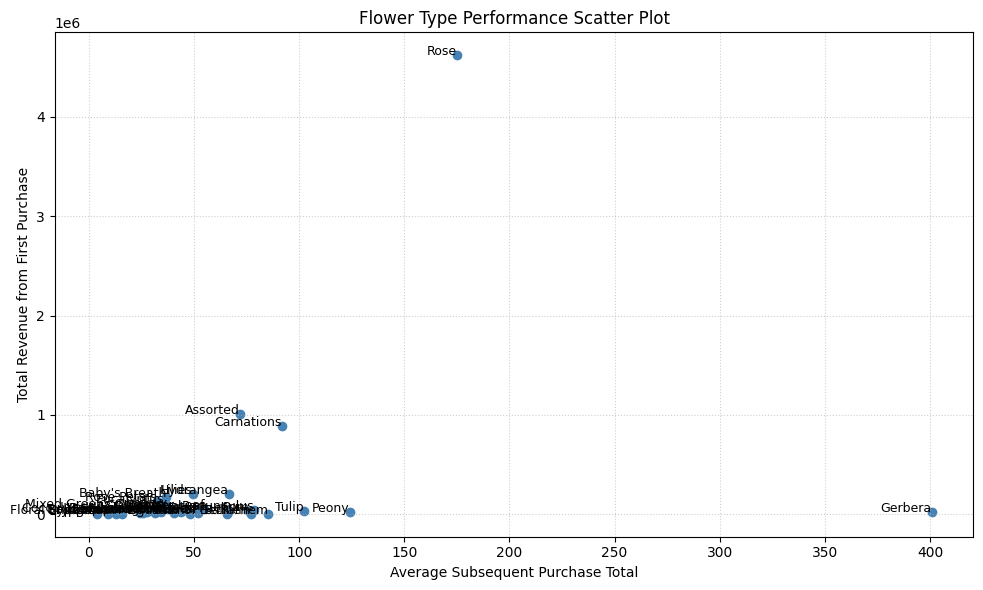

In [113]:
plt.figure(figsize=(10, 6))
plt.grid(True, linestyle=':', alpha=0.6)

# Plot dots
plt.scatter(
    df_merge['Average Subsequent Purchase Total'],
    df_merge['Total Revenue from First Purchase'],
    color='steelblue'
)

# Add labels for each dot
for i, row in df_merge.iterrows():
    plt.text(
        row['Average Subsequent Purchase Total'],
        row['Total Revenue from First Purchase'],
        row['Type'],
        fontsize=9,
        ha='right'
    )

# Set axis labels and title
plt.xlabel('Average Subsequent Purchase Total')
plt.ylabel('Total Revenue from First Purchase')
plt.title('Flower Type Performance Scatter Plot')
plt.tight_layout()
plt.show()

In [108]:
from google.colab import files

# Save Excel file locally in the Colab environment
df_merge.to_excel('acquisition_and_retention_GR.xlsx', index=False)

# Download it to your local computer (e.g., desktop)
files.download('acquisition_and_retention_GR.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [107]:
df_merge_path = '/content/drive/MyDrive/acquisition_and_retention_GR.xlsx'

# Save to Drive
df_merge.to_excel(df_merge_path, index=False)

In [106]:
df_merge

Type  Total Revenue from First Purchases  \
0               Assorted                           1,013,983   
1                   Asst                                 NaN   
2                  Aster                              26,046   
3          Baby's Breath                             173,196   
4                   Ball                               7,163   
5       Bells of Ireland                               9,289   
6             Carnations                             891,905   
7   Cocculus Laurifolius                              19,054   
8             Combo Pack                              24,539   
9                  D.I.Y                              52,044   
10               Dahlias                              21,060   
11            Delphinium                              17,494   
12              Eryngium                               7,072   
13            Eucalyptus                             111,995   
14               Fillers                              39,612   
15        Floral Snipper                               6,341   
16               Gerbera                              19,726   
17             Hydrangea                             202,194   
18             Hypericum                               7,733   
19                  Iris                              12,811   
20          Leather Leaf                              55,613   
21             Ligustrum                               5,231   
22                Lilies                             205,594   
23            Lisianthus                              28,286   
24          Million Star                              16,936   
25    Mixed Greens Combo                              64,080   
26                  Palm                               7,475   
27                 Peony                              28,172   
28                   Pom                              36,611   
29            Ranunculus                              46,318   
30                  Rose                           4,620,407   
31           Rose Petals                             129,982   
32                Ruscus                              47,235   
33            Snapdragon                              17,982   
34     Star of Bethlehem                               5,737   
35            Sunflowers                              45,562   
36                 Tulip                              32,652   
37              Viburnum                               6,744   

    Average Subsequent Purchase Total  
0                                  72  
1                                  30  
2                                  44  
3                                  37  
4                                  66  
5                                  24  
6                                  92  
7                                  28  
8                                  66  
9                                  38  
10                                 12  
11                                 26  
12                                  9  
13                                 36  
14                                 29  
15                                  4  
16                                401  
17                                 66  
18                                 13  
19                                 40  
20                                 55  
21                                 48  
22                                 49  
23                                 34  
24                                 52  
25                                 33  
26                                 77  
27                                124  
28                                 76  
29                                 79  
30                                175  
31                                 32  
32                                 52  
33                                 31  
34                                 85  
35                                 40  
36                                102  
37 

In [67]:
df_aq = df_d2c.groupby(['Type', 'First Order']).agg({'price':'sum'}).reset_index()
df_aq = df_aq[df_aq['First Order']=='Y']
df_aq.rename(columns={'price':'Total Revenue from First Purchases'})
df_aq = df_aq[['Type', 'Total Revenue from First Purchases']]
grouped2 = grouped.reset_index()
grouped2 = grouped2[['Type', 'Subsequent Purchase Total']]
df_ltv2 = df_ltv[df_ltv['First Order']=='Y'].groupby('Type')['price'].mean().reset_index()
df_ltv2.rename(columns={'price':'Initial AOV'})
df_merge = df_ltv.merge

Type First Order     price
0       Assorted           N   195,335
1       Assorted           Y 1,002,229
2           Asst           N     3,227
3           Asst           Y    11,754
4          Aster           N     7,003
5          Aster           Y    26,046
6  Baby's Breath           N    29,433
7  Baby's Breath           Y   173,196
8           Ball           N     1,980
9           Ball           Y     7,163

In [39]:
df_roses = df_d2c[df_d2c['Type']=='Rose']
df_roses['Rose Order'] = 1
df_roses = df_roses[['order_id', 'Rose Order']]
df_roses = df_roses.drop_duplicates(subset='order_id', keep='first')
df_d2c = df_d2c.merge(df_roses, how='outer')

<ipython-input-39-35f301cf4007>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_roses['Rose Order'] = 1


In [40]:
len(df_d2c)

85680

In [56]:
df_d2c['Rose Order'].fillna(value=0, inplace=True)
# Step 3: Group by month_year, Type, and Rose Order
grouped = df_d2c.groupby(['month_year', 'Type', 'Rose Order'])['price'].sum().reset_index()

# Step 4: Pivot so you get two columns: with Rose and without Rose
pivoted = grouped.pivot_table(index=['month_year', 'Type'],
                               columns='Rose Order',
                               values='price',
                               fill_value=0).reset_index()

# Step 5: Rename the columns for clarity
pivoted.columns.name = None  # remove the name of the columns index
pivoted = pivoted.rename(columns={
    0: 'Revenue without Rose',
    1: 'Revenue with Rose'
})
pivoted['% Surplus/(Deficit) Delta'] = (pivoted['Revenue without Rose'] - pivoted['Revenue with Rose']) / (pivoted['Revenue with Rose'] + pivoted['Revenue without Rose']) * 100

<ipython-input-56-eb1895691b9d>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_d2c['Rose Order'].fillna(value=0, inplace=True)


In [58]:
df_d2c['Rose Order'].fillna(value=0, inplace=True)
# Step 3: Group by month_year, Type, and Rose Order
grouped = df_d2c.groupby(['Type', 'Rose Order'])['price'].sum().reset_index()

# Step 4: Pivot so you get two columns: with Rose and without Rose
pivoted = grouped.pivot_table(index=['Type'],
                               columns='Rose Order',
                               values='price',
                               fill_value=0).reset_index()

# Step 5: Rename the columns for clarity
pivoted.columns.name = None  # remove the name of the columns index
pivoted = pivoted.rename(columns={
    0: 'Revenue without Rose',
    1: 'Revenue with Rose'
})
pivoted['% Surplus/(Deficit) Delta'] = (pivoted['Revenue without Rose'] - pivoted['Revenue with Rose']) / (pivoted['Revenue with Rose'] + pivoted['Revenue without Rose']) * 100

<ipython-input-58-7157fa2641c7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_d2c['Rose Order'].fillna(value=0, inplace=True)


In [60]:
pivoted['Type'].unique()

array(['Assorted', 'Aster', "Baby's Breath", 'Ball', 'Bells of Ireland',
       'Carnations', 'Cocculus Laurifolius', 'Combo Pack', 'D.I.Y',
       'Dahlias', 'Delphinium', 'Eryngium', 'Eucalyptus', 'Filler',
       'Floral Snipper', 'Gerbera', 'Gypso', 'Hydrangea', 'Hypericum',
       'Iris', 'Lavender', 'Leather Leaf', 'Ligustrum', 'Lilies',
       'Lisianthus', 'Million Star', 'Mixed Greens Combo', 'Palm',
       'Peony', 'Pom', 'Ranunculus', 'Rose', 'Rose Petals', 'Ruscus',
       'Snapdragon', 'Star Bethlehem', 'Star of Bethlehem', 'Sunflowers',
       'Tulip', 'Viburnum'], dtype=object)

In [ ]:
pivoted.groupby(

In [59]:
pivoted.sort_values(by="% Surplus/(Deficit) Delta", ascending=False)

Type  Revenue without Rose  Revenue with Rose  \
0               Assorted             1,087,797            102,700   
32           Rose Petals               129,164             15,740   
5             Carnations               931,045            129,885   
8                  D.I.Y                16,304              2,731   
15               Gerbera                23,543              4,705   
38                 Tulip                34,141              6,953   
7             Combo Pack                24,934              5,082   
19                  Iris                12,137              2,818   
23                Lilies               200,557             50,036   
9                Dahlias                17,881              4,540   
37            Sunflowers                46,064             12,578   
28                 Peony                26,935              7,918   
27                  Palm                 8,553              2,738   
4       Bells of Ireland                 8,021              3,230   
29                   Pom                66,319             28,560   
36     Star of Bethlehem                 4,160              1,855   
20              Lavender                 4,684              2,362   
17             Hydrangea               154,488             86,509   
35        Star Bethlehem                 1,110                629   
1                  Aster                20,171             12,878   
2          Baby's Breath                12,312              8,620   
10            Delphinium                11,619              8,793   
34            Snapdragon                12,132              9,682   
26    Mixed Greens Combo                42,414             33,889   
39              Viburnum                 4,183              3,439   
30            Ranunculus                29,762             25,370   
16                 Gypso                91,518             90,178   
33                Ruscus                29,749             31,619   
6   Cocculus Laurifolius                11,203             11,966   
12            Eucalyptus                62,215             68,124   
13                Filler                86,189             97,824   
21          Leather Leaf                32,627             38,802   
3                   Ball                 4,111              5,032   
24            Lisianthus                15,327             18,975   
18             Hypericum                 4,128              5,253   
11              Eryngium                 3,241              4,508   
14        Floral Snipper                 2,742              4,687   
25          Million Star                 7,300             13,587   
22             Ligustrum                 2,439              5,028   
31                  Rose                     0          5,466,190   

    % Surplus/(Deficit) Delta  
0                          83  
32                         78  
5                          76  
8                          71  
15                         67  
38                         66  
7                          66  
19                         62  
23                         60  
9                          60  
37                         57  
28                         55  
27                         52  
4                          43  
29                         40  
36                         38  
20                         33  
17                         28  
35                         28  
1                          22  
2                          18  
10                         14  
34                         11  
26                         11  
39                         10  
30                          8  
16                          1  
33                         -3  
6                          -3  
12                         -5  
13                         -6  
21                         -9  
3                         -10  
24                        -11  
18                        -12  
11                        -16  
14    

Text(0.5, 0, 'Type')

Text(0, 0.5, 'Mean Values')

Text(0.5, 1.0, 'Mean Price vs. Subsequent Same Purchase Total by Type')

[Text(0, 0, 'Assorted'),
 Text(1, 0, 'Aster'),
 Text(2, 0, "Baby's Breath"),
 Text(3, 0, 'Ball'),
 Text(4, 0, 'Bells of Ireland'),
 Text(5, 0, 'Carnations'),
 Text(6, 0, 'Cocculus Laurifolius'),
 Text(7, 0, 'Combo Pack'),
 Text(8, 0, 'D.I.Y'),
 Text(9, 0, 'Dahlias'),
 Text(10, 0, 'Delphinium'),
 Text(11, 0, 'Eryngium'),
 Text(12, 0, 'Eucalyptus'),
 Text(13, 0, 'Filler'),
 Text(14, 0, 'Floral Snipper'),
 Text(15, 0, 'Gerbera'),
 Text(16, 0, 'Gypso'),
 Text(17, 0, 'Hydrangea'),
 Text(18, 0, 'Hypericum'),
 Text(19, 0, 'Iris'),
 Text(20, 0, 'Lavender'),
 Text(21, 0, 'Leather Leaf'),
 Text(22, 0, 'Ligustrum'),
 Text(23, 0, 'Lilies'),
 Text(24, 0, 'Lisianthus'),
 Text(25, 0, 'Million Star'),
 Text(26, 0, 'Mixed Greens Combo'),
 Text(27, 0, 'Palm'),
 Text(28, 0, 'Peony'),
 Text(29, 0, 'Pom'),
 Text(30, 0, 'Ranunculus'),
 Text(31, 0, 'Rose'),
 Text(32, 0, 'Rose Petals'),
 Text(33, 0, 'Ruscus'),
 Text(34, 0, 'Snapdragon'),
 Text(35, 0, 'Star Bethlehem'),
 Text(36, 0, 'Star of Bethlehem'),
 Text

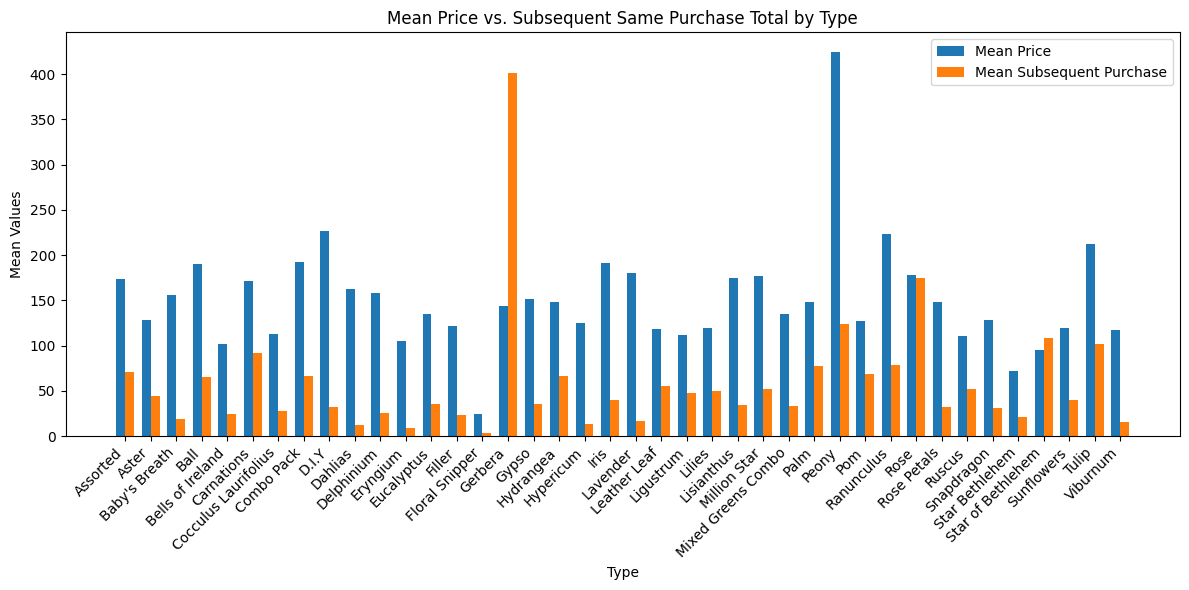

In [ ]:
# Step 1: Group by 'Type' and calculate means
grouped = df_ltv.groupby('Type')[['price', 'Subsequent Same Purchase Total']].mean()

# Step 2: Setup bar positions
types = grouped.index
x = np.arange(len(types))  # the label locations
width = 0.35  # width of the bars

# Step 3: Plot bars
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, grouped['price'], width, label='Mean Price')
bars2 = ax.bar(x + width/2, grouped['Subsequent Same Purchase Total'], width, label='Mean Subsequent Purchase')

# Step 4: Labels and formatting
ax.set_xlabel('Type')
ax.set_ylabel('Mean Values')
ax.set_title('Mean Price vs. Subsequent Same Purchase Total by Type')
ax.set_xticks(x)
ax.set_xticklabels(types, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
df_d2c[df_d2c['Type']=='Gerbera']

order_id order_date                          ship_name  \
193     655645 2024-01-02                     Jacob Gonzalez   
194    655645A 2024-01-02                     Jacob Gonzalez   
195    655645B 2024-01-02                     Jacob Gonzalez   
196    655645C 2024-01-02                     Jacob Gonzalez   
1623    656802 2024-01-09                   Onesima Castillo   
4406    659173 2024-01-19                      Jacalyn BAUER   
5798    660495 2024-01-24                         Maria Diaz   
8831    663308 2024-01-31                      Sharyl Hofpar   
10341   664595 2024-02-02                        Haylee Bare   
12733   666929 2024-02-05                     Sabrina Crouse   
15026   669055 2024-02-06                Samantha Vigliaturo   
20579   674151 2024-02-21               Amy Campbell-Fleming   
20846   674379 2024-02-22                    Marisa Renteria   
20968   674472 2024-02-23                    Colette Reardon   
21503   674936 2024-02-26                     Jacob Gonzalez   
21504  674936A 2024-02-26                     Jacob Gonzalez   
21505  674936B 2024-02-26                     Jacob Gonzalez   
21506  674936C 2024-02-26                     Jacob Gonzalez   
21507  674936D 2024-02-26                     Jacob Gonzalez   
21508  674936E 2024-02-26                     Jacob Gonzalez   
23193   676308 2024-03-05                      Alfredo Arcos   
23259   676400 2024-03-06                    Christina Braga   
23308   676442 2024-03-06               Shondalette Randolph   
23660   676766 2024-03-08                      Justin Betzer   
23661   676766 2024-03-08                      Justin Betzer   
23760   676833 2024-03-09                      Samuel Wallis   
24281   677263 2024-03-12                   Marsha Younglove   
25172   677942 2024-03-18                   Melessa Hazelton   
25476  678207A 2024-03-19                  Jane Milaschewski   
25866   678526 2024-03-21                   Deborah Urbinati   
26464   679062 2024-03-25                        Emily Gomez   
26465   679062 2024-03-25                        Emily Gomez   
26576   679126 2024-03-25                        Kelly Abram   
26577   679126 2024-03-25                        Kelly Abram   
26900   679408 2024-03-26                     Anna Elizabeth   
27626   679992 2024-03-31                 Nancy Rehker-Heard   
27966   680327 2024-04-01                   Suzanne Spinazze   
28238   680534 2024-04-02      Robert  or kathleen Slaughter   
28440   680712 2024-04-03                      Holly Fancher   
28677   680883 2024-04-04                        Debra Gould   
28678   680884 2024-04-04                Katharine Staveland   
28868  681080A 2024-04-05                Stephanie Morefield   
29933   681996 2024-04-09                      Peggy Hassett   
30120   682166 2024-04-09                    Joanne  Winters   
30928   682878 2024-04-12                       Megan Wilson   
31107   683038 2024-04-13                        Susan  Baum   
31533   683357 2024-04-14                 Alejandra Carrillo   
32146   683865 2024-04-16                      JEFFERY BIGGS   
32669   684286 2024-04-17                       Ashley Moody   
32777   684373 2024-04-18                             K Lane   
33447   684899 2024-04-19                    lessly aparicio   
33734  685094A 2024-04-20                    Cinthia Sanchez   
33900   685269 2024-04-21                     Crystal Garcia   
34488  685746A 2024-04-22                     Patricia Perry   
34593   685818 2024-04-22                    Carly Marksbury   
35103  686233A 2024-04-23                    Ashley Williams   
35123   686247 2024-04-23                     Maria Alvarado   
35358   686453 2024-04-24                    Lupita Sandoval   
35896   686868 2024-04-25                   Lindsay Schragel   
36002   686946 2024-04-25                    Angie Schimmels   
36124   687040 2024-04-25                    jennifer roland   
36339  687218A 2024-04-26             

In [ ]:
df_ltv.groupby(['order_id', 'Type'])['price'].nunique().reset_index().sort_values(by='price', ascending=False)[0:10]

order_id                Type  price
58451   765449  Mixed Greens Combo      1
0       655436                Rose      1
1       655438                Rose      1
2       655445         Rose Petals      1
58435   765434                Rose      1
58434   765431            Assorted      1
58433   765427                Rose      1
58432   765427              Lilies      1
58431   765427              Filler      1
58430   765427          Carnations      1

In [ ]:
df_ltv.

order_id                Type First Order  price  Total Price  \
0    655436                Rose           Y     81           86   
1    655438                Rose           Y     82           87   
2    655445         Rose Petals           Y    106          106   
3    655454                Rose           Y    156          160   
4    655456            Assorted           Y     74           78   
5    655458                Rose           Y     83           89   
6    655459               Gypso           Y     72          141   
7    655459                 Pom           Y     69          141   
8    655462                Rose           Y     89           97   
9    655464                Rose           Y    121          125   
10   655465          Carnations           Y    148          149   
11   655467                Rose           Y    121          129   
12   655470                Rose           Y    143          154   
13   655471                Rose           Y     71           77   
14   655472                Rose           Y     71           77   
15   655474                Rose           Y    147          156   
16   655476               Gypso           Y     88          236   
17   655476  Mixed Greens Combo           Y    134          236   
18   655479                Rose           Y    130          137   
19   655484                Rose           Y    137          140   
20   655488                Rose           Y     97          105   
21   655489           Hydrangea           Y     82           88   
22   655490                Rose           Y     89           94   
23   655491          Eucalyptus           Y     75          435   
24   655491        Leather Leaf           Y    105          435   
25   655491                Rose           Y    246          435   
26   655493              Lilies           Y     65           68   
27   655496          Carnations           Y    178        1,077   
28   655496          Eucalyptus           Y    119        1,077   
29   655496                Rose           Y    789        1,077   
30   655497          Carnations           Y     62           62   
31   655500                Rose           Y     83           89   
32   655502                Rose           Y     82           87   
33   655504                Rose           Y    103          106   
34   655507                Rose           Y    499          541   
35   655510                Rose           Y    247          266   
36   655513                Rose           Y    137          149   
37   655514           Hydrangea           Y     60           64   
38   655516                Rose           Y     87           57   
39   655517                Rose           Y    123          134   
40   655519                Rose           Y    100          106   
41   655521                Rose           Y    112          119   
42   655526                Rose           Y    121          115   
43   655527                Rose           Y    125          134   
44   655531                Rose           Y    117          128   
45   655532                Rose           Y    149          165   
46   655535                Rose           Y     69           73   
47   655537          Carnations           Y    254          280   
48   655538                Rose           Y    109          121   
49   655541              Filler           Y     82          174   
50   655541                Rose           Y     82          174   
51   655544           Hypericum           Y     85          273   
52   655544                Rose           Y    169          273   
53   655546                Rose           Y    137          149   
54   655548                Rose           Y    137          150   
55   655555           Hypericum           Y     85          236   
56   655556                Rose           Y     79           84   
57   655560                Rose           Y    148          161   
58   655561            Assorted           Y    100

In [ ]:
df_d2c[df_d2c['ship_name']=='Larisa Lavrentyev'][['order_id', 'ship_name', 'name', 'Type', 'price', 'order_date', 'ship_addr']]

order_id          ship_name                                  name  Type  \
60      655532  Larisa Lavrentyev         (QB) Rose Med Classic Cezanne  Rose   
62389   737541  Larisa Lavrentyev                   (QB) Rose Med Blush  Rose   
62390   737541  Larisa Lavrentyev  zinrelo_reward_dd251 $50 OFF COUPON   <NA>   

       price order_date          ship_addr  
60       149 2024-01-01   2433 238th Pl Se  
62389    136 2025-01-27  2433 238 Place SE  
62390    -50 2025-01-27  2433 238 Place SE

In [ ]:
df_same = df_d2c.groupby(['ship_name', 'order_date', 'order_id', 'name', 'Type', 'First Order', 'Total Price']).agg({'price':'sum'}).reset_index()
df_same = df_same.drop_duplicates(subset=['order_id', 'name', 'order_date'], keep=False)
df_same2 = df_same.groupby(['ship_name', 'name'])['price'].sum().reset_index()
df_same3 = df_same2.merge(df_same, how='outer')
df_same3.rename(columns={'price':'Repurchase Total - Same Item'}, inplace=True)
df_same3 = df_same3[['order_id', 'Repurchase Total - Same Item']]

In [ ]:
df_same[df_same.duplicated(subset=['ship_name', 'name'], keep=False)==True].sort_values(by='ship_name')[0:100]

ship_name order_date order_id  \
153     AMANDA HENDERSON 2025-02-28   753540   
154     AMANDA HENDERSON 2025-03-04   754198   
197      ANIRUDDHA MITRA 2024-01-27   661442   
198      ANIRUDDHA MITRA 2025-01-16   734798   
231      ASHLEY BLUBAUGH 2025-01-14   734448   
232      ASHLEY BLUBAUGH 2025-01-14   734456   
242         ASSUMPTA FOY 2024-01-15   657930   
244         ASSUMPTA FOY 2025-01-24   736925   
336       Aaron Thompson 2024-02-07   669240   
337       Aaron Thompson 2025-01-23   736670   
345         Aarron Clark 2025-04-14   763175   
344         Aarron Clark 2024-04-18   684469   
350        Aayanna Gomez 2024-02-02   664658   
351        Aayanna Gomez 2024-02-05   667274   
463    Abigail Fernandez 2024-02-05   666937   
464    Abigail Fernandez 2025-03-03   753905   
619      Adelina Lindsay 2024-05-02   690107   
622      Adelina Lindsay 2024-05-02  690107A   
845      Afton Blu Salon 2024-03-22   678641   
846      Afton Blu Salon 2024-03-28   679675   
847      Afton Blu Salon 2024-06-08   701944   
861         Agnes Okotie 2024-02-03   665588   
863         Agnes Okotie 2024-04-22   685769   
937          Ailie Chang 2024-04-10   682295   
936          Ailie Chang 2024-03-29   679849   
1193    Alejandra Huerta 2024-04-22   685697   
1194    Alejandra Huerta 2024-04-22   685697   
1195    Alejandra Huerta 2024-04-22   685868   
1197    Alejandra Huerta 2024-04-22   685868   
1247             Alena Q 2025-02-03   741113   
1248             Alena Q 2025-02-03   741145   
1249   Alena Shapovalova 2024-04-08   681551   
1250   Alena Shapovalova 2024-04-08   681554   
1493  Alexandra Martinez 2024-05-08   695356   
1492  Alexandra Martinez 2024-05-06   693601   
1547      Alexey Chesnok 2024-05-29   700087   
1546      Alexey Chesnok 2024-05-29   700080   
1651   Alexis Villalobos 2024-03-03   675891   
1652   Alexis Villalobos 2024-03-04   676027   
1687        Alfred Evans 2024-02-06   668201   
1688        Alfred Evans 2024-05-07   694164   
1734            Alice Ai 2024-02-10   671901   
1737            Alice Ai 2025-02-18   751900   
1740        Alice Aumack 2025-02-15   751045   
1739        Alice Aumack 2025-02-01   739783   
1751      Alice McDaniel 2024-01-30   662771   
1752      Alice McDaniel 2024-02-06   668869   
1750      Alice McDaniel 2024-01-17   658529   
1798          Alicia Lee 2024-03-28   679718   
1799          Alicia Lee 2024-05-08   694884   
1797          Alicia Lee 2024-02-07   669792   
1832    Alicia Templeton 2024-03-12   677235   
1833    Alicia Templeton 2025-04-16   764651   
1893        Alisha McCoy 2024-06-18   703415   
1894        Alisha McCoy 2025-04-05   760832   
1913      Alison Barenas 2024-01-25   660693   
1914      Alison Barenas 2024-01-25   660693   
1916      Alison Barenas 2024-01-25   660758   
1917      Alison Barenas 2024-01-25   660758   
1961       Alissa Taylor 2024-04-10   682435   
1962       Alissa Taylor 2025-03-26   757982   
2066   Allison Carpenter 2025-01-26   737449   
2065   Allison Carpenter 2024-01-26   661178   
2128       Allison Welch 2024-02-01   663710   
2129       Allison Welch 2025-01-12   733647   
2151     Allyson Jimenez 2024-02-22   674253   
2152     Allyson Jimenez 2024-02-22   674253   
2153     Allyson Jimenez 2025-02-25   753058   
2154     Allyson Jimenez 2025-02-25   753058   
2220    Alondra Figueroa 2024-05-24   699292   
2221    Alondra Figueroa 2024-06-04   701247   
2273         Aly Koehnke 2025-04-17   765098   
2272         Aly Koehnke 2025-04-17   765097   
2271         Aly Koehnke 2025-04-17   765096   
2269         Aly Koehnke 2025-04-17   765088   
2268         Aly Koehnke 2025-04-17   765087   
2270         Aly Koehnke 2025-04-17   765092   
2297          Alys Romer 2025-01-28   738176   
2298          Alys Romer 2025-01-30   739221   
2337        Alyssa Gerke 2024-01-23   660110   
2338        Alyssa Gerke 2025-01-23   736516   
2502       Amanda Epling 2025-02-10   747299   
2503       Amanda Epling 2025-0

In [ ]:
# Step 1: Filter df_d2c for Tenure < 400
df_filtered = df_d2c[(df_d2c['Tenure'] < 400) & (df_d2c['Tenure'] != 0) & (df_d2c['Tenure'] > 300)]

# Step 2: Group by Tenure and count unique ship_names (or total if duplicates allowed)
tenure_counts = df_filtered.groupby('Tenure')['ship_name'].count()

# Step 3: Plot the bar chart
plt.figure(figsize=(12, 6))
tenure_counts.plot(kind='bar')
plt.xlabel('Tenure (days)')
plt.ylabel('Number of Ship Names')
plt.title('Count of Ship Names by Tenure (< 400 days)')
plt.tight_layout()
plt.show()

In [ ]:
len(df_d2c)

85896

In [ ]:
name_phone = df_d2c.groupby(['ship_name'])['ship_phone'].nunique().reset_index().sort_values(by='ship_phone', ascending=False)
len(name_phone[name_phone['ship_phone']>1])

1103

In [ ]:
name_phone[name_phone['ship_phone']>1]['ship_phone'].sum()

np.int64(2318)

In [83]:
df_d2c.groupby(['month_year', 'Type']).size()

month_year  Type                
2024-01-01  Assorted                 657
            Aster                     23
            Baby's Breath            103
            Ball                       3
            Bells of Ireland           4
            Carnations               696
            Cocculus Laurifolius      11
            Combo Pack                10
            D.I.Y                     28
            Dahlias                    6
            Delphinium                 8
            Eryngium                   3
            Eucalyptus                80
            Fillers                   24
            Floral Snipper            26
            Gerbera                    8
            Hydrangea                108
            Hypericum                  8
            Iris                      14
            Leather Leaf              82
            Ligustrum                  5
            Lilies                   196
            Lisianthus                 7
            Million Star              13
            Mixed Greens Combo        49
            Palm                       3
            Peony                      6
            Pom                       20
            Ranunculus                19
            Rose                    4138
            Rose Petals               79
            Ruscus                    43
            Snapdragon                 9
            Star of Bethlehem          7
            Sunflowers                34
            Tulip                     20
            Viburnum                   1
2024-02-01  Assorted                1201
            Aster                     30
            Baby's Breath            134
            Ball                       6
            Bells of Ireland          22
            Carnations              1011
            Cocculus Laurifolius      23
            Combo Pack                20
            D.I.Y                     26
            Dahlias                   11
            Delphinium                10
            Eryngium                   5
            Eucalyptus               115
            Fillers                   37
            Floral Snipper            17
            Gerbera                   12
            Hydrangea                175
            Hypericum                  3
            Iris                       7
            Leather Leaf              68
            Ligustrum                  6
            Lilies                   279
            Lisianthus                22
            Million Star              13
            Mixed Greens Combo        50
            Palm                      13
            Peony                      4
            Pom                       29
            Ranunculus                19
            Rose                    6192
            Rose Petals               86
            Ruscus                    57
            Snapdragon                14
            Star of Bethlehem          8
            Sunflowers                57
            Tulip                     20
            Viburnum                   9
2024-03-01  Assorted                 476
            Aster                     24
            Baby's Breath            111
            Ball                       5
            Bells of Ireland          13
            Carnations               458
            Cocculus Laurifolius      20
            Combo Pack                16
            D.I.Y                     60
            Dahlias                    9
            Delphinium                16
            Eryngium                   7
            Eucalyptus               114
            Fillers                   50
            Floral Snipper            22
            Gerbera                   16
            Hydrangea                186
            Hypericum                  6
            Iris                      10
            Leather Leaf              47
            Ligustrum                  9
            Lilies                   211
            Lisianthus         

In [88]:
df_d2c[(df_d2c['Type']=='Rose') & (df_d2c['month_year']=='2024-01')]['order_id'].nunique()

3617

Text(0, 0.5, 'Number of Purchases')

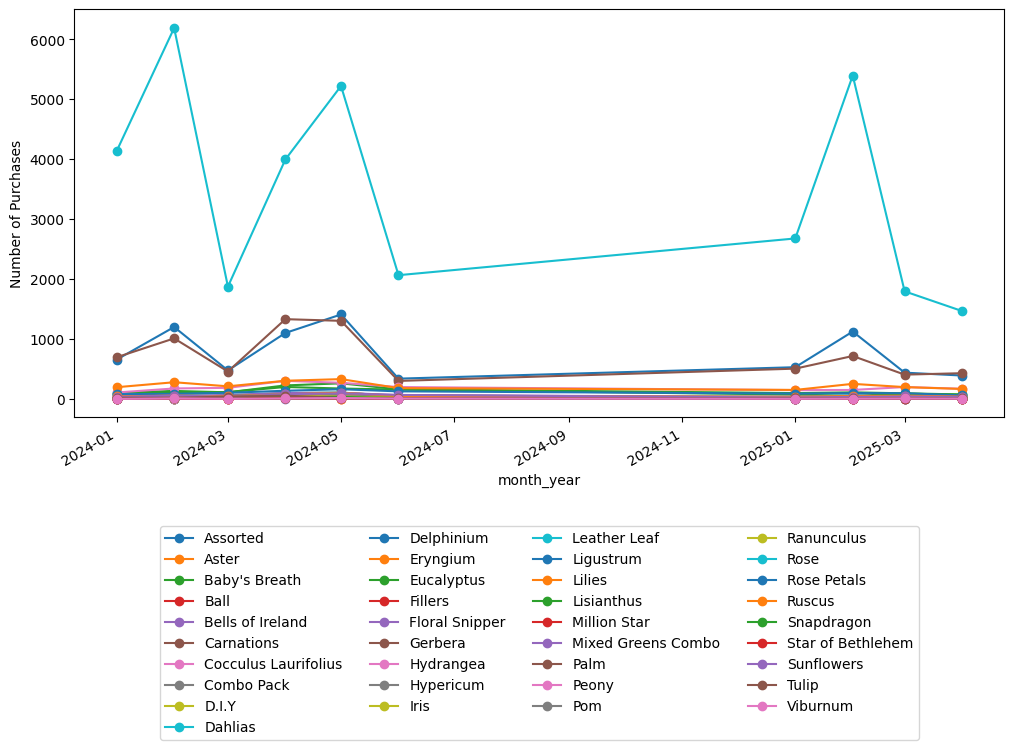

In [90]:
import matplotlib.pyplot as plt

ax = df_d2c.groupby(['month_year', 'Type']).size().unstack(fill_value=0).sort_index().plot(
    kind='line', marker='o', figsize=(12, 6)
)

# Add y-axis label
ax.set_ylabel("Number of Purchases")

# Move legend further down
ax.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, -0.25))

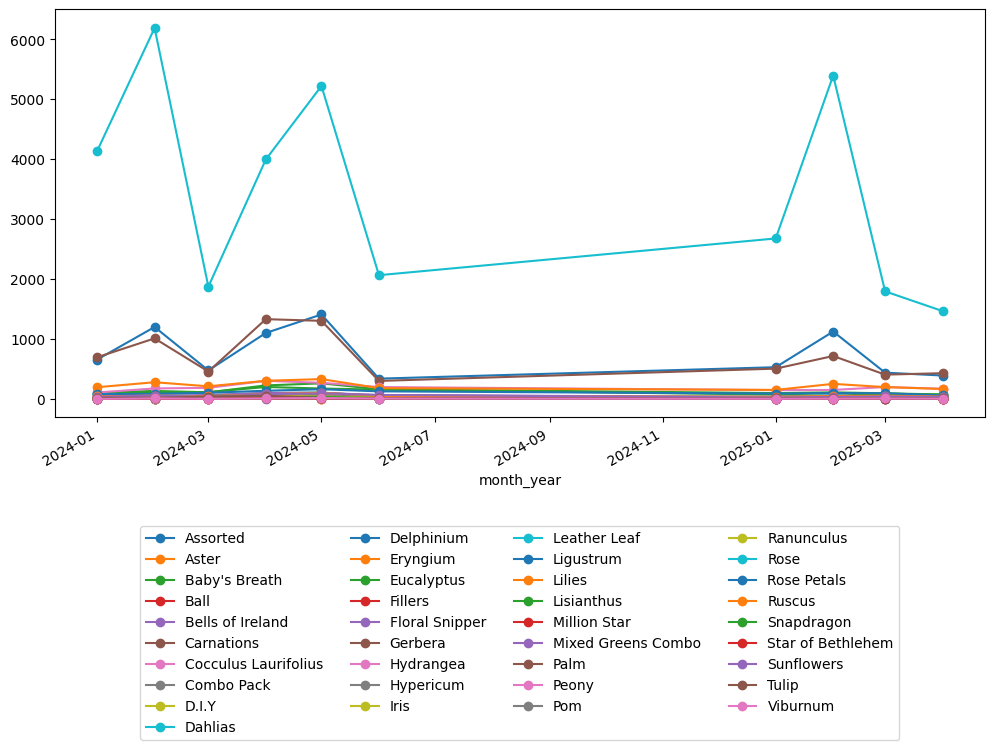

In [87]:
ax = df_d2c.groupby(['month_year', 'Type']).size().unstack(fill_value=0).sort_index().plot(
    kind='line', marker='o', figsize=(12, 6)
)

# Move legend further down
ax.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, -0.25))

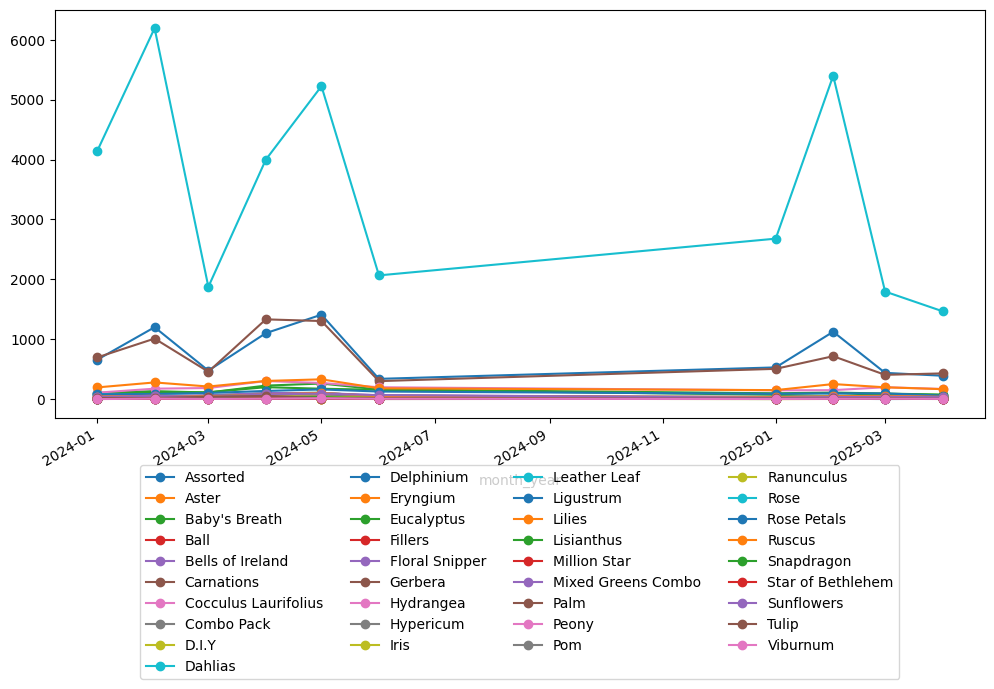

In [86]:
ax = df_d2c.groupby(['month_year', 'Type']).size().unstack(fill_value=0).sort_index().plot(
    kind='line', marker='o', figsize=(12, 6)
)

# Set legend to span across multiple columns (e.g., 4)
ax.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, -0.1))

<Axes: xlabel='month_year'>

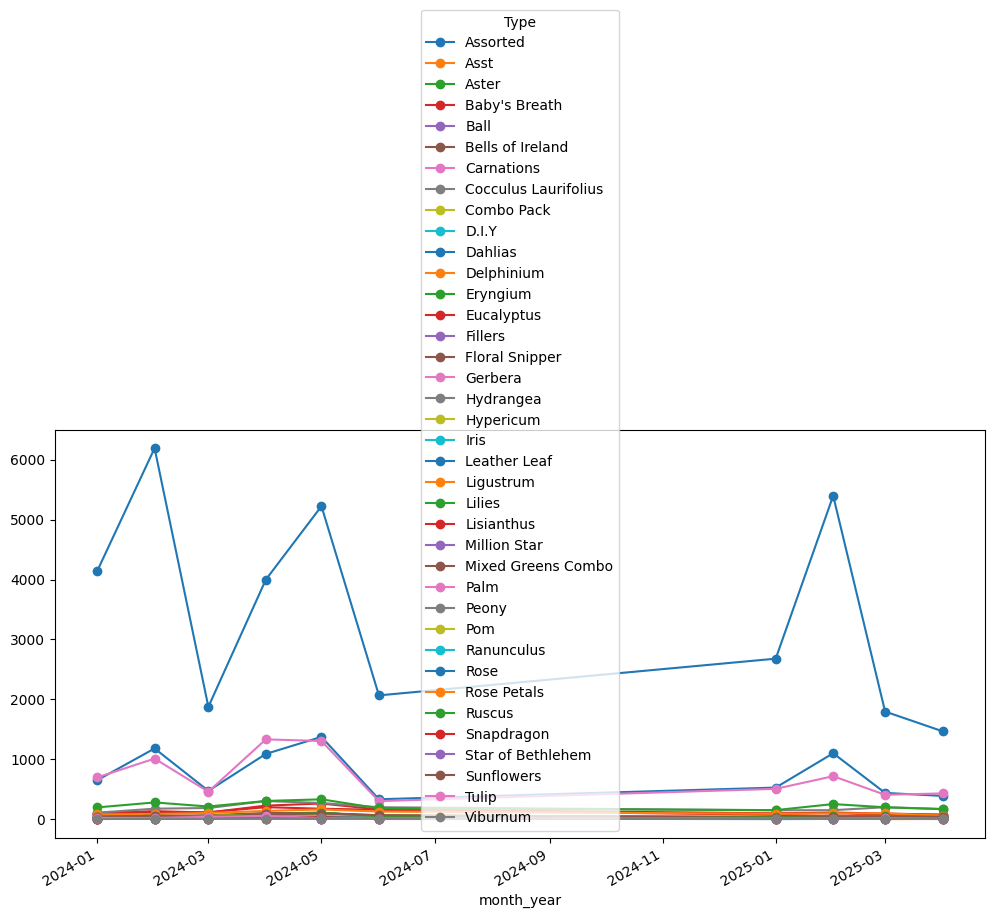

In [69]:
# Group, pivot, and plot as line chart
df_d2c.groupby(['month_year', 'Type']).size().unstack(fill_value=0).sort_index().plot(
    kind='line', marker='o', figsize=(12, 6)
)

In [ ]:
df_d2c.loc[df_d2c['Subtype'] == 'Hpink', 'Subtype'] = 'Hot Pink'
df_d2c

In [ ]:
df_d2c[df_d2c['Type']=='Rose'].groupby('Subtype')['order_id'].size().reset_index().sort_values(by='order_id', ascending=False)

Subtype  order_id
397                                                Red      7633
0                                                           5141
182                                            Freedom      2971
515                                              White      2013
166                                Designer Collection      1993
358                                               Pink      1777
530                                             Yellow       851
261                                           Hot Pink       667
455                                              Spray       592
341                                             Orange       471
83                                               Akito       462
294                                         Light Pink       417
508                                            Vendela       361
434                                           Seasonal       286
399                                     Red And Filles       281
106                                               Asst       281
473                                   Sugar Doll Stems       276
290                                           Lavender       256
113                                           Bi-Color       250
363                                 Pink Mondial Stems       236
311                                       Luciano Pink       226
383                                              Proud       224
315                                      Luciano Stems       205
98                                           Anastacia       181
472                                         Sugar Doll       175
154                                             D-Blue       169
238                                      Hermosa Stems       165
153                                            D-Black       155
408                                        Red Fillers       148
263                                Hot Pink Valentines       140
280                                              Hpink       139
357                                              Peach       135
489                                          Sweetness       127
464                                          Spray Red       126
390                                             Purple       120
281                                              Ivory       111
149                                         Cool Water       107
272                                       Hot Princess       106
460                                         Spray Pink       106
230                             Grandiose Bqt Pink Red       100
447                                        Solid White        99
378                                         Polar Star        96
405                                          Red Bunch        96
361                    Pink Floyd [Inlude Flower Food]        94
81         (red and different colors) (Gypo and Green)        88
400                               Red And Filles Bunch        88
65                                            (HB) Red        86
333                                         Multicolor        86
245                                    High And Bonita        85
92                                    Alpe Dhuez White        81
499                       Tiffany [Inlude Flower Food]        81
309                                 Luciano Light Pink        80
498                                            Tiffany        79
328                                            Mondial        75
329                                 Mother Pearl Stems        71
173                                             Escimo        69
162                                         D-Burgundy        69
392                                            Rainbow        66
437                                           Sexy Red        65
254                                       Hot Merengue        64
221                                          Gold Star        61
379              

<Axes: xlabel='month_year'>

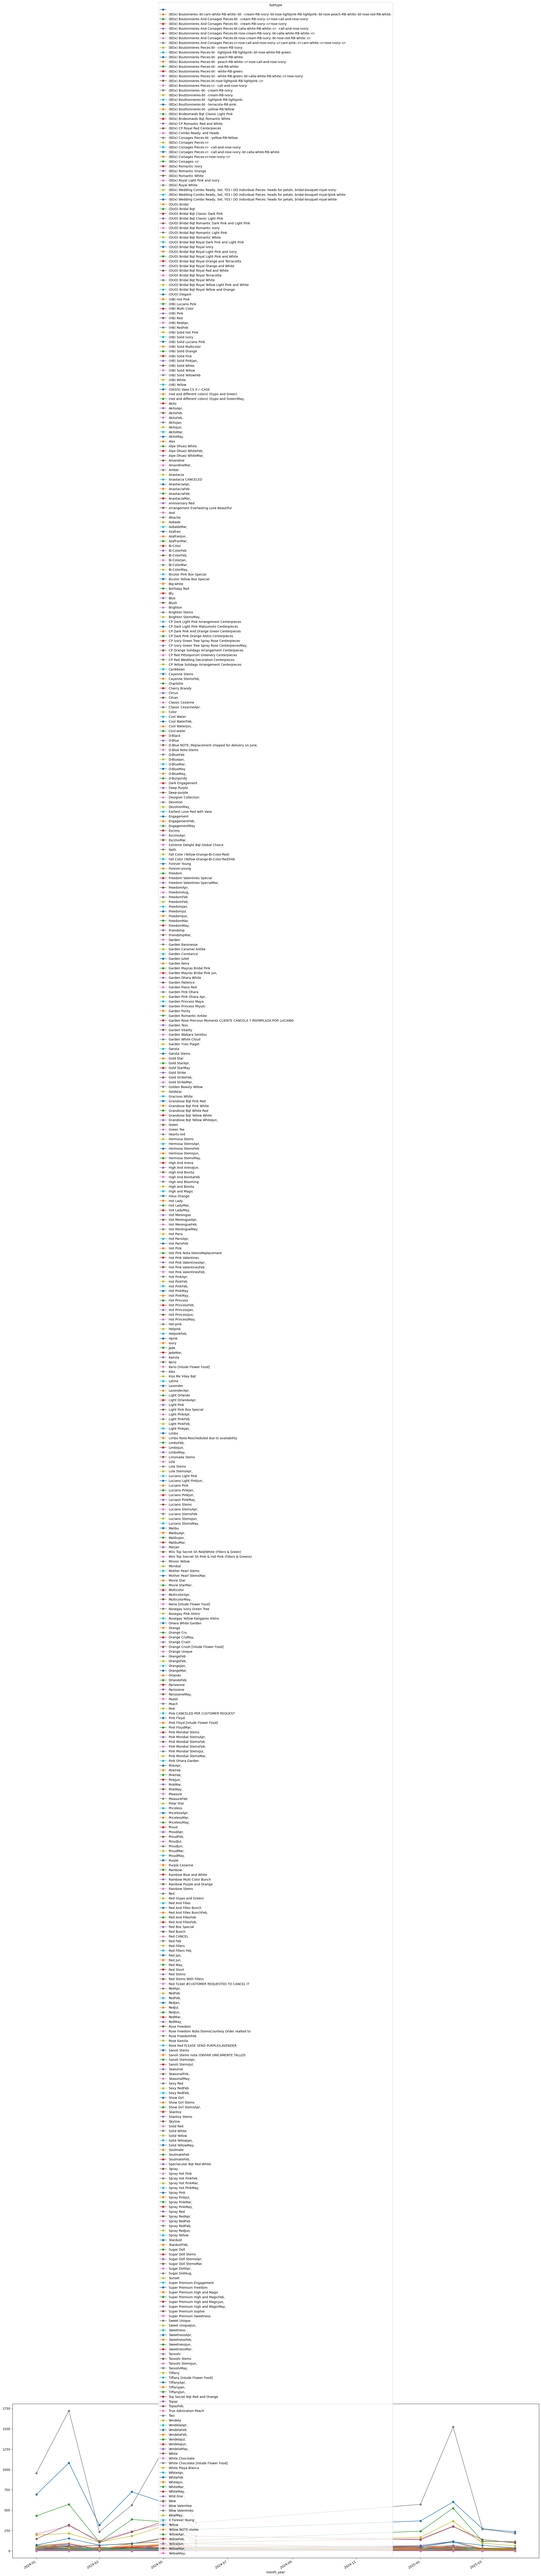

In [ ]:
df_d2c[df_d2c['Type']=='Rose'].groupby(['month_year', 'Subtype']).size().unstack(fill_value=0).sort_index().plot(
    kind='line', marker='o', figsize=(30, 10)
)

In [ ]:
len(df_d2c[(df_d2c['code']!='mm-others')&(df_d2c['Type'].isna()==True)])

4570

In [ ]:
df_d2c.groupby('code')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)[0:300]

code  order_id
1483                                  mm-others     15907
1890                                  qty-roses      3141
288                                    Canceled      2170
1555                     next-day-100-red-roses      2062
1885                             qty-carnations      1429
169                       50-next-day-red-roses      1222
312                          Replacement Coupon      1086
989                               flower-filler       696
1006             freedom-valentines-special-100       682
2057                              roses-red-100       646
1889                               qty-redroses       644
796                                   classy-50       642
165                  50-next-day-assorted-roses       605
1546                next-day-100-assorted-roses       587
1971                      rose-assorted-special       575
1765               pink-roses-assorted-next-day       562
232                          50-solid-red-roses       529
1003                         freedom-medium-100       414
168                      50-next-day-pink-roses       395
190                           50-roses-assorted       389
2517              white-roses-assorted-next-day       386
1198                   hydrangeas-blue-20-20-24       362
793                                  classy-100       361
170                     50-next-day-white-roses       349
2060                        roses-red-200-short       348
2050                             roses-pink-100       327
2064                            roses-white-100       325
2502                       white-carnations-100       316
1112                  gypso-perfecta-12-bunches       314
233                        50-solid-white-roses       303
2027                     rose-petals-white-2400       302
1576           next-day-50-roses-25-red-25-pink       298
541                     assorted-carnations-200       295
1288                             leather-leaf-6       290
2388                   vday-2-dozen-red-roses-f       288
1524                 mothers-day-carnations-100       271
1486                         mom-carnations-200       269
1891                             qty-whiteroses       266
2020                       rose-petals-red-2400       263
540                     assorted-carnations-100       258
1114                   gypso-perfecta-6-bunches       252
2387                     vday-2-dozen-red-roses       244
2356              valentines-day-carnations-100       241
1211                  hydrangeas-white-20-20-24       238
777                           charlotte-long-75       234
959                  eucalyptus-silver-dollar-5       233
2408                        vday-carnations-200       229
234                       50-solid-yellow-roses       216
177                          50-red-roses-short       215
2246                             sugar-doll-100       215
985                              floral-snipper       208
1545           next-day-100-assorted-carnations       207
2568                 your-choice-carnations-100       205
1577          next-day-50-roses-25-red-25-white       203
2503                       white-carnations-200       201
544                     assorted-carnations-std       193
175                        50-red-roses-freedom       192
2569           your-choice-color-carnations-200       190
1213                  hydrangeas-white-40-20-24       185
1115                             gypsophilia-30       182
1951                         red-carnations-100       182
2078                           ruscus-100-stems       181
983                fillers-combo-pack-6-bunches       180
80                    2-dozen-red-roses-fillers       180
957                 eucalyptus-silver-dollar-10       178
761         calla-open-cut-white-18-stems-24-26       176
1405                            mday-classy-100       176
1052              gerberas-60-your-choice-color       172
1291               leatherleaf-10-bunches

<ipython-input-23-b516db73f7e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d2c['order_date'] = pd.to_datetime(df_d2c['order_date'])
<ipython-input-23-b516db73f7e8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d2c['month_year'] = df_d2c['order_date'].dt.to_period('M').dt.to_timestamp()


<Axes: xlabel='month_year'>

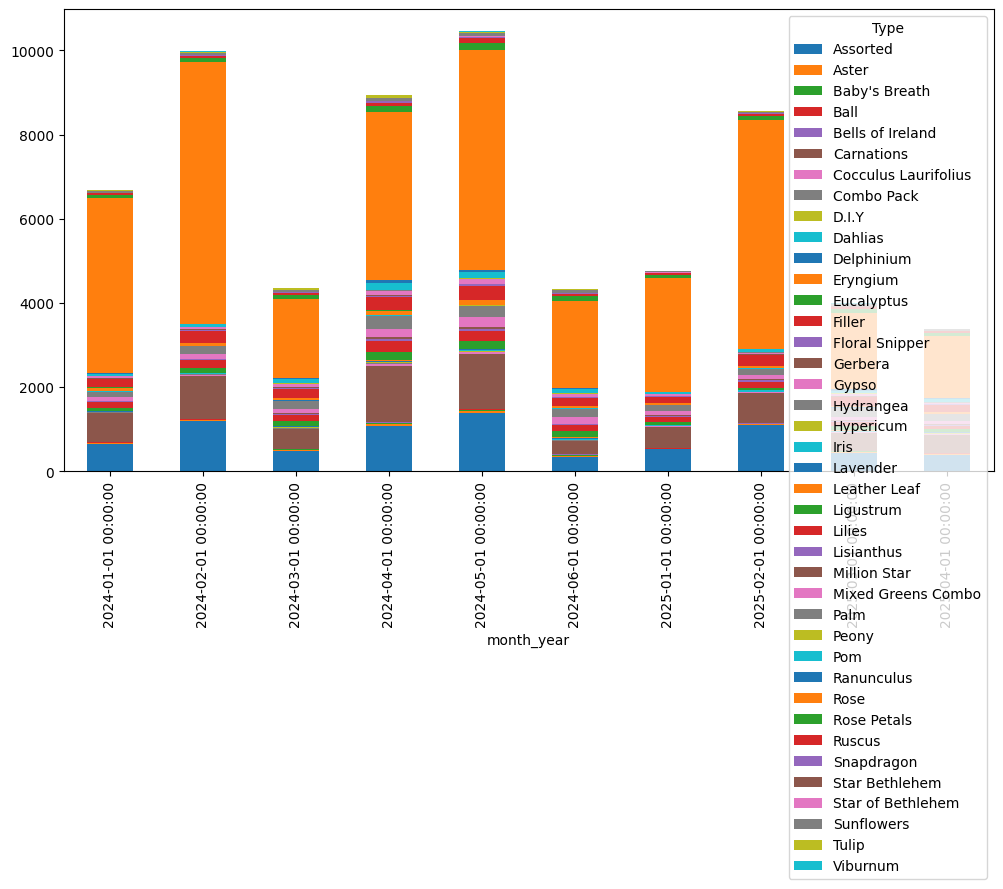

In [ ]:
# Step 1: Convert order_date to datetime
df_d2c['order_date'] = pd.to_datetime(df_d2c['order_date'])

# Step 2: Create a true datetime month-year column
df_d2c['month_year'] = df_d2c['order_date'].dt.to_period('M').dt.to_timestamp()

# Step 3: Group and plot
df_d2c.groupby(['month_year', 'Type']).size().unstack(fill_value=0).sort_index().plot(
    kind='bar', stacked=True, figsize=(12, 6)
)

<ipython-input-24-98a29dfa62c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d2c['order_date'] = pd.to_datetime(df_d2c['order_date'])
<ipython-input-24-98a29dfa62c2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_d2c['month_year'] = df_d2c['order_date'].dt.to_period('M').dt.to_timestamp()


<Axes: xlabel='month_year'>

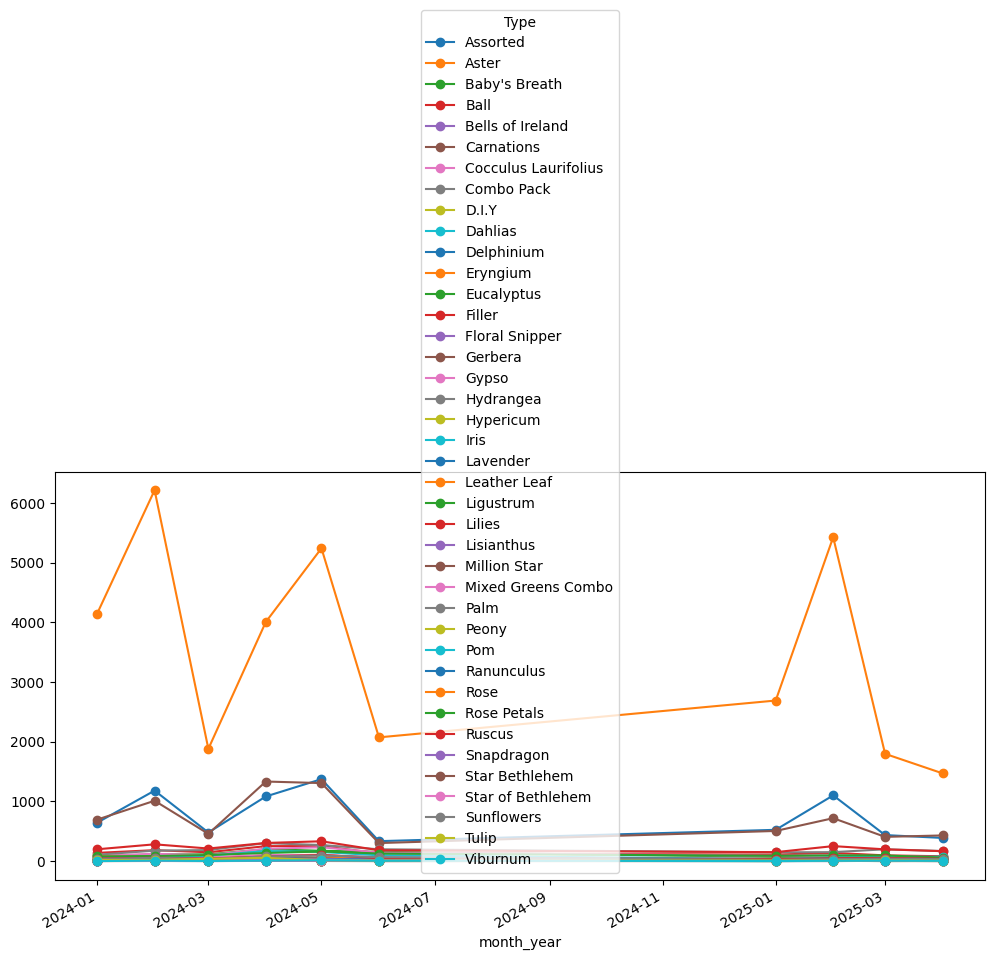

In [ ]:
# Ensure datetime
df_d2c['order_date'] = pd.to_datetime(df_d2c['order_date'])

# Create a month-year column for grouping
df_d2c['month_year'] = df_d2c['order_date'].dt.to_period('M').dt.to_timestamp()

# Group, pivot, and plot as line chart
df_d2c.groupby(['month_year', 'Type']).size().unstack(fill_value=0).sort_index().plot(
    kind='line', marker='o', figsize=(12, 6)
)

<Axes: title={'center': 'Monthly Order Count'}, xlabel='month_year'>

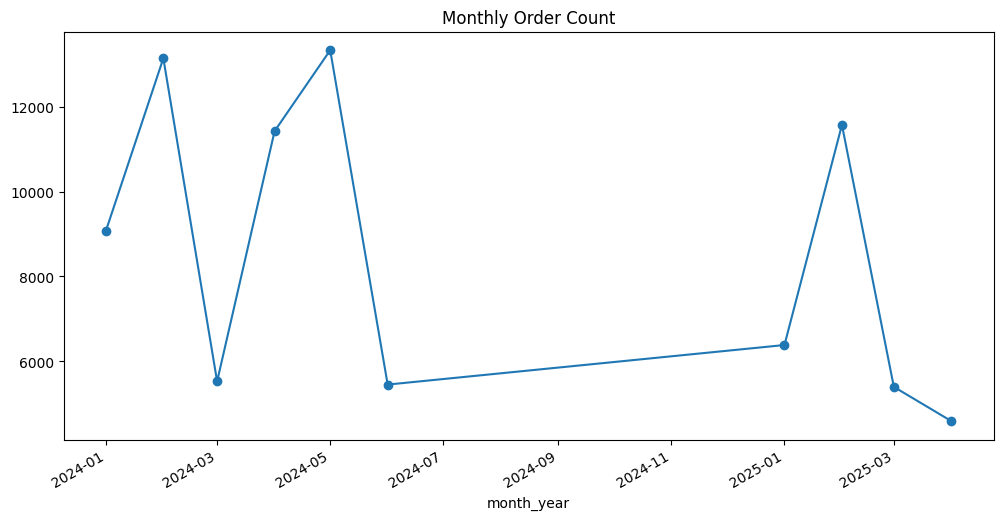

In [ ]:
# Group by month and count order_id
monthly_orders = df_d2c.groupby('month_year')['order_id'].count()

# Plot the line chart
monthly_orders.plot(kind='line', marker='o', figsize=(12, 6), title='Monthly Order Count')

<Axes: title={'center': 'Monthly Revenue'}, xlabel='month_year'>

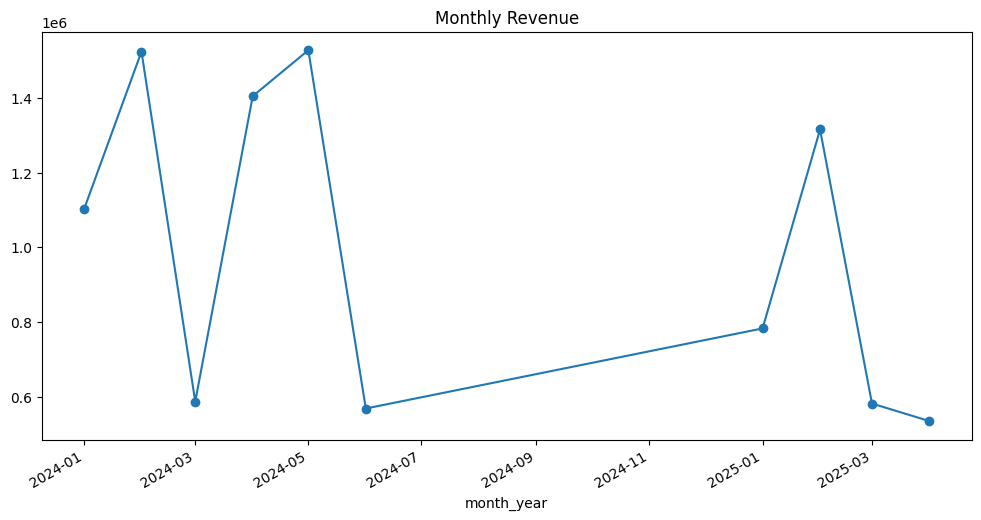

In [ ]:
# Group by month and sum the price
monthly_revenue = df_d2c.groupby('month_year')['price'].sum()

# Plot
monthly_revenue.plot(kind='line', marker='o', figsize=(12, 6), title='Monthly Revenue')

In [ ]:
df# Group, pivot, and plot as line chart
df_d2c.groupby(['month_year', 'order_id']).count().unstack(fill_value=0).sort_index().plot(
    kind='line', marker='o', figsize=(12, 6)
)

<Axes: xlabel='order_date'>

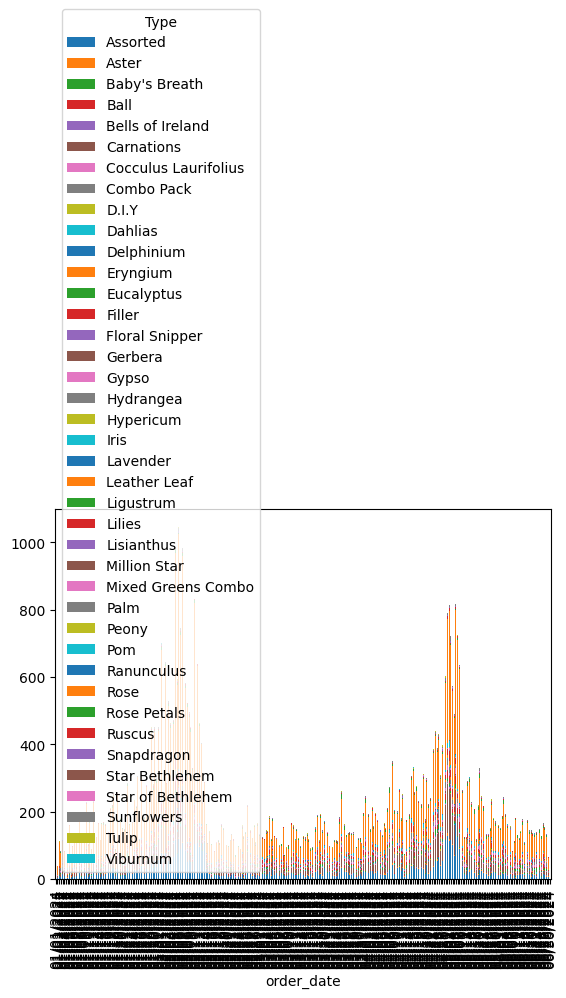

In [ ]:
df_d2c.groupby(['order_date', 'Type']).size().unstack(fill_value=0).plot(kind='bar', stacked=True)

In [ ]:
df_d2c.groupby('order_date')['Type'].count().plot(kind='bar')

In [ ]:
df_d2c[df_d2c['Product Name'].str.contains('Assorted', na=False)][['Product Name', 'Type', 'code']][0:100]

Product Name      Type  \
13                            Alstroemeria Fcy Assorted  Assorted   
174                                       Rose Assorted  Assorted   
184                                      Aster Assorted  Assorted   
378                                  Spray Fcy Assorted  Assorted   
422                                      Aster Assorted  Assorted   
435                                Spray Roses Assorted  Assorted   
470                                Spray Roses Assorted  Assorted   
499                                   Carn Sel Assorted  Assorted   
512      Rose Assorted (Different Colors, No Red Color)  Assorted   
516                                       Rose Assorted  Assorted   
539                                 Hydrangeas Assorted  Assorted   
591                                      Roses Assorted  Assorted   
594                                      Roses Assorted  Assorted   
601                                       Rose Assorted  Assorted   
668                         Assorted Premium Hydrangeas  Assorted   
720                                       Carn Assorted  Assorted   
725      Rose Assorted (Different Colors, No Red Color)  Assorted   
762               Spray Rose Assorted (Gypso and Green)  Assorted   
773                                       Carn Assorted  Assorted   
916                                      Roses Assorted  Assorted   
950                                 Hydrangeas Assorted  Assorted   
965   (DUO) Bridal Bqt Romantic Assorted Color Roses...  Assorted   
981                                       Carn Assorted  Assorted   
1080                                   Gerbera Assorted  Assorted   
1126                                     Roses Assorted  Assorted   
1137                                      Rose Assorted  Assorted   
1250                     Rose Assorted (Gypo and Green)  Assorted   
1255                                   Gerbera Assorted  Assorted   
1257                                      Rose Assorted  Assorted   
1421                                      Rose Assorted  Assorted   
1478                                   Gerbera Assorted  Assorted   
1669                                     Roses Assorted  Assorted   
1706                                      Rose Assorted  Assorted   
1731     Rose Assorted (Different Colors, No Red Color)  Assorted   
1737                                      Carn Assorted  Assorted   
1773                                      Rose Assorted  Assorted   
1795                                      Carn Assorted  Assorted   
1850                                     Roses Assorted  Assorted   
1853                                      Rose Assorted  Assorted   
1912                                      Rose Assorted  Assorted   
1973                                      Rose Assorted  Assorted   
1993                                   Gerbera Assorted  Assorted   
2010                        Assorted Premium Hydrangeas  Assorted   
2040                                Poms Daisy Assorted  Assorted   
2067                                      Rose Assorted  Assorted   
2113                                      Rose Assorted  Assorted   
2114                                     Roses Assorted  Assorted   
2133                                      Carn Assorted  Assorted   
2215                          Alstroemeria Fcy Assorted  Assorted   
2237                                Snapdragon Assorted  Assorted   
2252     Rose Assorted (Different Colors, No Red Color)  Assorted   
2314                          Alstroemeria Fcy Assorted  Assorted   
2317                                      Rose Assorted  Assorted   
2326                            Asiatic Lilies Assorted  Assorted   
2330                                Snapdragon Assorted  Assorted   
2344                                     Roses Assorted  Assorted   
2393                            Asiatic Lilies Assorted  Assorted   
2408                                     

In [ ]:
len(df_d2c.groupby('Type')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False))

40

In [ ]:
df_d2c[(df_d2c['sku']=='GLO002792') & (df_d2c['Type'].isna()==True)][['name', 'sku', 'Product Name', 'Type', 'Subtype', 'code']]

name        sku     Product Name  Type  \
165     (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
12324   (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
48213   (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
50762   (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
55587   (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
58315   (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
58334   (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
62948   (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
65328   (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
73536   (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
100043  (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
107531  (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
108712  (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
109101  (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
111607  (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
112171  (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
117141  (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
131945  (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
157024  (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   
168899  (OC) Hypericum Green 3 Bunches  GLO002792  Hypericum Green  <NA>   

       Subtype                        code  
165       <NA>  hypericum-flowers-green-30  
12324     <NA>  hypericum-flowers-green-30  
48213     <NA>  hypericum-flowers-green-30  
50762     <NA>  hypericum-flowers-green-30  
55587     <NA>  hypericum-flowers-green-30  
58315     <NA>  hypericum-flowers-green-30  
58334     <NA>  hypericum-flowers-green-30  
62948     <NA>  hypericum-flowers-green-30  
65328     <NA>  hypericum-flowers-green-30  
73536     <NA>  hypericum-flowers-green-30  
100043    <NA>  hypericum-flowers-green-30  
107531    <NA>  hypericum-flowers-green-30  
108712    <NA>  hypericum-flowers-green-30  
109101    <NA>  hypericum-flowers-green-30  
111607    <NA>  hypericum-flowers-green-30  
112171    <NA>  hypericum-flowers-green-30  
117141    <NA>  hypericum-flowers-green-30  
131945    <NA>  hypericum-flowers-green-30  
157024    <NA>  hypericum-flowers-green-30  
168899    <NA>  hypericum-flowers-green-30

In [ ]:
df_d2c[df_d2c['code'].str.contains('hypericum')][['name', 'sku', 'Product Name', 'Type', 'Subtype', 'code']]

name        sku  \
155                       (OC) Hypericum Cherry 3 Bunches  GLO002791   
165                        (OC) Hypericum Green 3 Bunches  GLO002792   
3181                   (QB) Hypericum Assorted 12 Bunches  GLO002784   
4149                 (HB) Hypericum Orange 24 BunchesFeb   GLO002798   
12324                      (OC) Hypericum Green 3 Bunches  GLO002792   
13751                     (OC) Hypericum Cherry 3 Bunches  GLO002791   
13752                     (OC) Hypericum Orange 6 Bunches  GLO002799   
14005                     (OC) Hypericum Orange 6 Bunches  GLO002799   
17036                     (OC) Hypericum Orange 3 Bunches  GLO002793   
22157                     (OC) Hypericum Cherry 3 Bunches  GLO002791   
25160                     (OC) Hypericum Cherry 6 Bunches  GLO002789   
41466                      (OC) Hypericum Green 6 Bunches  GLO002796   
48142                     (OC) Hypericum Orange 6 Bunches  GLO002799   
48213                      (OC) Hypericum Green 3 Bunches  GLO002792   
50762                      (OC) Hypericum Green 3 Bunches  GLO002792   
53164                     (OC) Hypericum Orange 3 Bunches  GLO002793   
55458                      (OC) Hypericum Green 6 Bunches  GLO002796   
55587                      (OC) Hypericum Green 3 Bunches  GLO002792   
58315                      (OC) Hypericum Green 3 Bunches  GLO002792   
58334                      (OC) Hypericum Green 3 Bunches  GLO002792   
59050       (OC) Hypericum Green 6 BunchesApr 13, 2024 -   GLO002796   
60061                     (OC) Hypericum Orange 6 Bunches  GLO002799   
62143                   (OC) Hypericum Assorted 6 Bunches  GLO002786   
62948                      (OC) Hypericum Green 3 Bunches  GLO002792   
65328                      (OC) Hypericum Green 3 Bunches  GLO002792   
66791                     (OC) Hypericum Orange 6 Bunches  GLO002799   
68059                      (OC) Hypericum Green 6 Bunches  GLO002796   
70534                    (QB) Hypericum Orange 12 Bunches  GLO002797   
72636                     (OC) Hypericum Cherry 6 Bunches  GLO002789   
73536                      (OC) Hypericum Green 3 Bunches  GLO002792   
78903                   (OC) Hypericum Assorted 6 Bunches  GLO002786   
80808                      (OC) Hypericum Green 6 Bunches  GLO002796   
81272                   (OC) Hypericum Assorted 6 Bunches  GLO002786   
84125                      (OC) Hypericum Green 6 Bunches  GLO002796   
93684                   (OC) Hypericum Assorted 6 Bunches  GLO002786   
94172                       (OC) Hypericum Asst 3 Bunches  GLO002790   
94518                     (OC) Hypericum Orange 6 Bunches  GLO002799   
94674                      (OC) Hypericum Green 6 Bunches  GLO002796   
100043                     (OC) Hypericum Green 3 Bunches  GLO002792   
100108                    (OC) Hypericum Orange 6 Bunches  GLO002799   
101324                    (HB) Hypericum Green 24 Bunches  GLO002795   
102301  (HB) CP Red Rose Hypericum Table Decoration 9 ...  GLO001938   
102307  (HB) CP Red Rose Hypericum Table Decoration 9 ...  GLO001938   
103895                     (OC) Hypericum Green 6 Bunches  GLO002796   
104138                     (OC) Hypericum Green 6 Bunches  GLO002796   
106278                     (OC) Hypericum Green 6 Bunches  GLO002796   
106861                     (OC) Hypericum Green 6 Bunches  GLO002796   
106927                     (OC) Hypericum Green 6 Bunches  GLO002796   
107531                     (OC) Hypericum Green 3 Bunches  GLO002792   
108712                     (OC) Hypericum Green 3 Bunches  GLO002792   
109101                     (OC) Hypericum Green 3 Bunches  GLO002792   
111607                     (OC) Hypericum Green 3 Bunches  GLO002792   
112029                     (OC) Hypericum Green 6 Bunches  GLO002796   
112171                     (OC) Hypericum Green 3 Bunches  GLO002792   
112953                     (OC) Hypericum Green 6 Bunches  GLO002796   
115742               

In [ ]:
df_na = df_d2c[df_d2c['Type'].isna()==True].groupby('sku')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)
df_na_path = '/content/drive/MyDrive/na_remaining2.xlsx'

# Save to Drive
df_na.to_excel(df_na_path, index=False)

In [ ]:
df_d2c.groupby('Type')['order_id'].count()

Type
Assorted                 1250
Carnations               8372
Cocculus Laurifolius      209
D.I.Y                     146
Delphinium                129
Eucalyptus               1123
Filler                   1634
Floral Snipper            309
Gerbera                   470
Gypso                    1271
Hydrangea                2067
Leather Leaf              616
Lilies                   1855
Lisianthus                229
Mixed Greens Combo        589
Pom                       860
Rose                    38282
Rose Petals              1136
Ruscus                    558
Snapdragon                337
Specialty Combo Pack      128
Sunflowers                501
Name: order_id, dtype: int64

In [ ]:
df_d2c[(df_d2c['name'].str.contains('(QB)', case=False, na=False))][['Product Name', 'Type', 'Subtype', 'price', 'code']][0:100]

<ipython-input-344-caae367b1160>:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_d2c[(df_d2c['name'].str.contains('(QB)', case=False, na=False))][['Product Name', 'Type', 'Subtype', 'price', 'code']][0:100]


Product Name                Type  \
27                               Rose Sugar Doll Stems                Rose   
30                                          Carn White          Carnations   
33                                      Rose Sweetness                Rose   
36                                          Rose White                Rose   
45                                                Rose                Rose   
48   Mixed Greens Combo : F-Bear-Grass:F-Eucalyptus...  Mixed Greens Combo   
52    Rose DC: blush:deep-purple:freedom:orange-crush:                Rose   
55                                                Rose                Rose   
63                                     Hydrangeas Blue           Hydrangea   
70                                        Leather Leaf        Leather Leaf   
77                                  Eucalyptus Cinerea          Eucalyptus   
80                                     Spray Rose Pink                Rose   
82                                   Spray Roses White                Rose   
111                                               Rose                Rose   
120                                         Rose White                Rose   
128                                Rose High and Magic                Rose   
130                                         Rose Ivory                Rose   
135                                           Rose Red                Rose   
137                               Rose Classic Cezanne                Rose   
144                               Carn Light Pink Pack          Carnations   
160                                               Rose                Rose   
163                                               Rose                Rose   
173                                           Rose Red                Rose   
178                                    Rose Light Pink                Rose   
209                          Oriental Lilies Stargazer              Lilies   
211                                       Rose Freedom                Rose   
221                                           Rose Red                Rose   
230                                           Rose Red                Rose   
251                          Oriental Lilies Stargazer              Lilies   
260                          Oriental Lilies Stargazer              Lilies   
263                                         Rose White                Rose   
267                                   Rose Red Fillers                Rose   
269  Mini Top Srecret Sh Pink & Hot Pink Rose (Fill...                Rose   
272   Rose (red and different colors) (Gypo and Green)                Rose   
283                              Rose Alpe Dhuez White                Rose   
290                                           Rose Red                Rose   
296                                  Spray Roses White                Rose   
302                                           Rose Red                Rose   
305                                           Rose Red                Rose   
307                                       Rose Freedom                Rose   
320                      Tropical Paradise Arrangement                <NA>   
334                                          Rose Pink                Rose   
346                                           Rose Red                Rose   
349                                           Rose Red                Rose   
354                                Asiatic Lilies Pink              Lilies   
361                                       Rose Freedom                Rose   
368                     Rose DC: mondial:pink-mondial:                Rose   
371                                          Rose Pink                Rose   
373                                       Rose D-Black                Rose   
374                       Garden Roses Romantic Antike                Rose   
375                                Rose High And Arena          

In [ ]:
df_d2c[(df_d2c['Product Name'].str.contains('Eucalyptus', case=False, na=False)) & (df_d2c['Type'].isna()==True)][['Product Name', 'Type', 'Subtype', 'price', 'code']]

Product Name  Type Subtype  \
69                                             Eucalyptus  <NA>    <NA>   
77                                     Eucalyptus Cinerea  <NA>    <NA>   
715                                            Eucalyptus  <NA>    <NA>   
716                              Eucalyptus Silver Dollar  <NA>    <NA>   
889                              Eucalyptus Silver Dollar  <NA>    <NA>   
920                              Eucalyptus Silver Dollar  <NA>    <NA>   
1059                                           Eucalyptus  <NA>    <NA>   
1104                             Eucalyptus Silver Dollar  <NA>    <NA>   
1399                             Eucalyptus Silver Dollar  <NA>    <NA>   
1527                                           Eucalyptus  <NA>    <NA>   
1528                                Eucalyptus Parvifolia  <NA>    <NA>   
1577                                Eucalyptus Parvifolia  <NA>    <NA>   
1578                             Eucalyptus Silver Dollar  <NA>    <NA>   
1770                             Eucalyptus Silver Dollar  <NA>    <NA>   
1783                             Eucalyptus Silver Dollar  <NA>    <NA>   
2037                             Eucalyptus Silver Dollar  <NA>    <NA>   
2676                                Eucalyptus Parvifolia  <NA>    <NA>   
2714    Matsumoto Hot Pink F-Eucalyptus:F-Leather-Leaf...  <NA>    <NA>   
2715    Matsumoto Red F-Eucalyptus:F-Leather-Leaf:F-Li...  <NA>    <NA>   
2719                                Eucalyptus Parvifolia  <NA>    <NA>   
2730    Oriental Lilies Stargazer F-Eucalyptus:F-Leath...  <NA>    <NA>   
2741                                           Eucalyptus  <NA>    <NA>   
2742                                Eucalyptus Parvifolia  <NA>    <NA>   
3264                                           Eucalyptus  <NA>    <NA>   
3455                                           Eucalyptus  <NA>    <NA>   
3764                             Eucalyptus Silver Dollar  <NA>    <NA>   
3815                                Eucalyptus Parvifolia  <NA>    <NA>   
4213                             Eucalyptus Silver Dollar  <NA>    <NA>   
4347                             Eucalyptus Silver Dollar  <NA>    <NA>   
5092                             Eucalyptus Silver Dollar  <NA>    <NA>   
5278                                Eucalyptus Parvifolia  <NA>    <NA>   
5787                             Eucalyptus Silver Dollar  <NA>    <NA>   
5806                                           Eucalyptus  <NA>    <NA>   
5967                                           Eucalyptus  <NA>    <NA>   
6164                                   Eucalyptus Cinerea  <NA>    <NA>   
6165                             Eucalyptus Silver Dollar  <NA>    <NA>   
6558                                           Eucalyptus  <NA>    <NA>   
6965                                           Eucalyptus  <NA>    <NA>   
7159                                   Eucalyptus Cinerea  <NA>    <NA>   
7197                             Eucalyptus Silver Dollar  <NA>    <NA>   
7459                                           Eucalyptus  <NA>    <NA>   
7509                             Eucalyptus Silver Dollar  <NA>    <NA>   
7697                                           Eucalyptus  <NA>    <NA>   
8297                                           Eucalyptus  <NA>    <NA>   
8638                                           Eucalyptus  <NA>    <NA>   
8720                                Eucalyptus Parvifolia  <NA>    <NA>   
8721                             Eucalyptus Silver Dollar  <NA>    <NA>   
9484                             Eucalyptus Silver Dollar  <NA>    <NA>   
9489                                Eucalyptus Parvifolia  <NA>    <NA>   
9639                                           Eucalyptus  <NA>    <NA>   
9719                             Eucalyptus Silver Dollar  <NA>    <NA>   
9755                             Eucalyptus Silver Dollar  <NA>    <NA>   
9759                                   Eucalyptus Cinerea  <NA>    <NA

In [ ]:
df_d2c[df_d2c['code'].str.contains('-choice', na=False)][['Product Name', 'Type', 'Subtype', 'price', 'code']][0:200]

Product Name       Type  \
52      Rose DC: blush:deep-purple:freedom:orange-crush:       Rose   
74     Alstroemeria Fcy Your Choice-Bi-Color:-Pink:-W...       <NA>   
83     Rose DC Engagement:Rosita-Vendela:Sugar Doll:V...       Rose   
89                            Rose DC: pleasure:freedom:       Rose   
270    Roses DC: (Gypso and Green) Bi-Color:Hot-Pink:...   Assorted   
356    Rose DC brighton:deep-purple:mondial:pink-mond...       Rose   
368                       Rose DC: mondial:pink-mondial:       Rose   
384             Your Choice Hydrangeas light-pink:white:  Hydrangea   
408                                 Rose DC: Engagement:       Rose   
410                                Gerbera Solid-Orange:       <NA>   
412                                Gerbera Solid-Orange:       <NA>   
413                                Gerbera Solid-Orange:       <NA>   
414                                Gerbera Solid-Orange:       <NA>   
468                            Rose DC: luciano:vendela:       Rose   
479       Snapdragon Your Choice Stems-White-Cream-Snap:       <NA>   
515                           Rose DC: blush:movie-star:       Rose   
552                         Carn DC Green:purple:yellow:       <NA>   
571                       Rose DC: deep-purple:pleasure:       Rose   
710    Snapdragon Your Choice Stems-Pink-Snap:-Burgun...       <NA>   
741                                         Rose Rainbow       Rose   
744                           Carn DC burgundy:pink:red:       <NA>   
935    Rose DC: blush:high-magic:movie-star:orange-cr...       Rose   
1172                    Rose DC: high-bonita:sugar-doll:       Rose   
1192           Rose DC (Gypso and Green) Pink:White:Red:   Assorted   
1202   Orchids Your Choice Stems Peach-Jinda-Sweet:Pi...       <NA>   
1268                            Rose DC: citran:orlando:       Rose   
1286   Babys Breath Tinted Choice Black Baby's Breath...       <NA>   
1307                           Rose DC: luciano:vendela:       Rose   
1343                       Rose DC: brighton:engagement:       Rose   
1349         Roses DC: (Gypso and Green) Bi-Color:Ivory:   Assorted   
1368                                        Rose Rainbow       Rose   
1470   Roses DC: (Gypso and Green) Bi-Color:Hot-Pink:...   Assorted   
1758                Rose DC: Blush:Freedom:Sweet Unique:       Rose   
1834                                        Rose Rainbow       Rose   
1849                                 Carn DC red:yellow:       <NA>   
1871                                        Rose Rainbow       Rose   
2032   Rose DC: deep-purple:freedom:pink-mondial:vend...       Rose   
2156   Roses DC pleasure:freedom:high-bonita:pink-floyd:       <NA>   
2194                  Carn Fcy DC Green:pink:red:yellow:       <NA>   
2228                      Carn Fcy DC burgundy:pink:red:       <NA>   
2331   Rose DC blush:brighton:deep-purple:freedom:hig...       Rose   
2414   Rose DC: Hot Paris:Livia:Pink Floyd:Sweet Unique:       Rose   
2451   Rose DC deep-purple:freedom:high-magic:mondial...       Rose   
2452   Roses DC blush:citran:freedom:hot-princess:pol...       <NA>   
2453                                   Roses DC freedom:       <NA>   
2559                                        Rose Rainbow       Rose   
2582                                        Rose Rainbow       Rose   
2662                  Rose DC freedom:luciano:anastacia:       Rose   
2729   Alstro Fcy DC:-Bi-Color:-Pink:-Red:F-Ligustrum...       <NA>   
2760   Rose DC blush:cool-water:freedom:escimo:high-b...       Rose   
2787   Rose DC: brighton:cool-water:deep-purple:pleas...       Rose   
2838       Rose DC: engagement:freedom:hot-lady:vendela:       Rose   
2971                     Rose DC: cool-water:goldstrike:       Rose   
3013                                        Rose Rainbow       Rose   
3036                     Rose DC: brighton:orange-crush:       Rose   
3124                                        Rose Rainbow       Rose 

In [ ]:
df_d2c[df_d2c['sku']=='GLO006437'][['Product Name', 'Type', 'Subtype', 'price']]

Product Name  Type            Subtype  price
13044   Garden Rose Pink Ohara  Rose  Garden Pink Ohara    155
15077   Garden Rose Pink Ohara  Rose  Garden Pink Ohara    155
16948   Garden Rose Pink Ohara  Rose  Garden Pink Ohara    207
64464   Garden Rose Pink Ohara  Rose  Garden Pink Ohara    168
87632   Garden Rose Pink Ohara  Rose  Garden Pink Ohara    158
113772  Garden Rose Pink Ohara  Rose  Garden Pink Ohara    158

In [ ]:
df_d2c.groupby('Type')['order_id'].count()

Type
Assorted                 1372
Carnations               8372
D.I.Y                     491
Eucalyptus               1123
Fillers                   344
Floral Snipper            309
Gypso                    1271
Hydrangea                2067
Leather Leaf              616
Mixed Greens Combo        589
Rose                    32074
Rose Petals              1136
Specialty Combo Pack      128
Name: order_id, dtype: int64

In [ ]:
df_d2c.groupby('code')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)[0:100]

code  order_id
1483                                  mm-others     15907
1890                                  qty-roses      3141
288                                    Canceled      2170
1555                     next-day-100-red-roses      2062
1885                             qty-carnations      1429
169                       50-next-day-red-roses      1222
312                          Replacement Coupon      1086
989                               flower-filler       696
1006             freedom-valentines-special-100       682
2057                              roses-red-100       646
1889                               qty-redroses       644
796                                   classy-50       642
165                  50-next-day-assorted-roses       605
1546                next-day-100-assorted-roses       587
1971                      rose-assorted-special       575
1765               pink-roses-assorted-next-day       562
232                          50-solid-red-roses       529
1003                         freedom-medium-100       414
168                      50-next-day-pink-roses       395
190                           50-roses-assorted       389
2517              white-roses-assorted-next-day       386
1198                   hydrangeas-blue-20-20-24       362
793                                  classy-100       361
170                     50-next-day-white-roses       349
2060                        roses-red-200-short       348
2050                             roses-pink-100       327
2064                            roses-white-100       325
2502                       white-carnations-100       316
1112                  gypso-perfecta-12-bunches       314
233                        50-solid-white-roses       303
2027                     rose-petals-white-2400       302
1576           next-day-50-roses-25-red-25-pink       298
541                     assorted-carnations-200       295
1288                             leather-leaf-6       290
2388                   vday-2-dozen-red-roses-f       288
1524                 mothers-day-carnations-100       271
1486                         mom-carnations-200       269
1891                             qty-whiteroses       266
2020                       rose-petals-red-2400       263
540                     assorted-carnations-100       258
1114                   gypso-perfecta-6-bunches       252
2387                     vday-2-dozen-red-roses       244
2356              valentines-day-carnations-100       241
1211                  hydrangeas-white-20-20-24       238
777                           charlotte-long-75       234
959                  eucalyptus-silver-dollar-5       233
2408                        vday-carnations-200       229
234                       50-solid-yellow-roses       216
177                          50-red-roses-short       215
2246                             sugar-doll-100       215
985                              floral-snipper       208
1545           next-day-100-assorted-carnations       207
2568                 your-choice-carnations-100       205
1577          next-day-50-roses-25-red-25-white       203
2503                       white-carnations-200       201
544                     assorted-carnations-std       193
175                        50-red-roses-freedom       192
2569           your-choice-color-carnations-200       190
1213                  hydrangeas-white-40-20-24       185
1115                             gypsophilia-30       182
1951                         red-carnations-100       182
2078                           ruscus-100-stems       181
983                fillers-combo-pack-6-bunches       180
80                    2-dozen-red-roses-fillers       180
957                 eucalyptus-silver-dollar-10       178
761         calla-open-cut-white-18-stems-24-26       176
1405                            mday-classy-100       176
1052              gerberas-60-your-choice-color       172
1291               leatherleaf-10-bunches

In [ ]:
df_d2c[df_d2c['sku'] == 'GLO000917'][['name', 'Product Name', 'Type', 'Subtype', 'code']]

name           Product Name    Type  \
8588    (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
23112   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
27595   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
39434   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
49373   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
59612   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
61415   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
62275   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
73332   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
75108   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
75364   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
78587   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
93872   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
98083   (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
102465  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
103675  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
104731  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
105261  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
105930  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
119808  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
128239  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
148992  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
159126  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
160200  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
160222  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
168169  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
168860  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   
170870  (OC) Asiatic Lilies Orange 2 Bunches  Asiatic Lilies Orange  Lilies   

               Subtype                             code  
8588    Asiatic Orange  asiatic-lillies-orange-20-stems  
23112   Asiatic Orange  asiatic-lillies-orange-20-stems  
27595   Asiatic Orange  asiatic-lillies-orange-20-stems  
39434   Asiatic Orange  asiatic-lillies-orange-20-stems  
49373   Asiatic Orange  asiatic-lillies-orange-20-stems  
59612   Asiatic Orange  asiatic-lillies-orange-20-stems  
61415   Asiatic Orange  asiatic-lillies-orange-20-stems  
62275   Asiatic Orange  asiatic-lillies-orange-20-stems  
73332   Asiatic Orange  asiatic-lillies-orange-20-stems  
75108   Asiatic Orange  asiatic-lillies-orange-20-stems  
75364   Asiatic Orange  asiatic-lillies-orange-20-stems  
78587   Asiatic Orange  asiatic-lillies-orange-20-stems  
93872   Asiatic Orange  asiatic-lillies-orange-20-stems  
98083   Asiatic Orange  asiatic-lillies-orange-20-stems  
102465  Asiatic Orange  asiatic-lillies-orange-20-stems  
103675  Asiatic Orange  asiatic-lillies-orange-20-stems  
104731  Asiatic Orange  asiatic-lillies-orange-20-stems  
105261  Asiatic Orange  asiatic-lillies-orange-20-stems  
105930  Asiatic Orange  asiatic-lillies-orange-20-stems  
119808  Asiatic Orange        asiatic-lillies-orange-20  
128239  Asiatic Orange        asiatic-lillies-orange-20  
148992  Asiatic Orange        asiatic-lillies-orange-20  
159126  Asiatic Orange        asiatic-lillies-orange-20  
160200  Asiatic Orange        asiatic-lillies-orange-20  
160222  Asiatic Orange        asiatic-lillies-orange-20  
168169  Asiatic Orange        asiatic-lillies-orange-20  
168860  Asiatic Orange        asiatic-lillies-orange-20  
170870  Asiatic Orange        asiatic-lillies-orange-20

In [ ]:
df_d2c[df_d2c['Type']=='Hydrangea'].groupby('sku').agg({'name':'nunique', 'order_id':'count'}).reset_index().sort_values(by=['name', 'order_id'], ascending=False)[0:100]

sku  name  order_id
12  GLO002761    20        24
23  GLO002773    16        33
20  GLO002769    10       361
30  GLO002780     8       238
24  GLO002774     6         9
21  GLO002771     5       136
17  GLO002766     5        39
18  GLO002767     4       163
43  GLO003335     3        58
40  GLO003019     3        27
0   GLO000963     3        20
13  GLO002762     3         3
28  GLO002778     2       108
44  GLO003336     2        73
25  GLO002775     2        36
15  GLO002764     2        34
37  GLO003006     2        33
4   GLO002574     2        25
41  GLO003020     2        21
9   GLO002736     2        17
10  GLO002737     2        13
39  GLO003008     2        12
48  GLO004485     2        10
5   GLO002575     2         8
31  GLO002781     2         7
35  GLO002959     2         6
36  GLO002960     2         4
19  GLO002768     2         3
22  GLO002772     2         3
51  GLO004580     2         3
14  GLO002763     2         2
32  GLO002782     1       183
16  GLO002765     1        66
45  GLO003338     1        40
38  GLO003007     1        37
26  GLO002776     1        31
46  GLO004483     1        25
3   GLO002573     1        22
47  GLO004484     1        22
27  GLO002777     1        14
1   GLO000964     1        12
34  GLO002958     1        12
49  GLO004578     1        11
6   GLO002599     1        10
50  GLO004579     1         9
11  GLO002738     1         8
33  GLO002865     1         7
2   GLO000965     1         6
42  GLO003021     1         6
7   GLO002600     1         4
8   GLO002601     1         4
29  GLO002779     1         1
52  GLO004925     1         1

In [ ]:
df_d2c[df_d2c['Product Name'].str.contains('Gypso', na=False)].groupby('sku').agg({'name':'nunique', 'order_id':'count'}).reset_index().sort_values(by=['name', 'order_id'], ascending=False)[0:100]

sku  name  order_id
48  GLO003364    88       100
47  GLO003363    66        80
44  GLO003360    55        64
45  GLO003361    42        59
49  GLO003365    42        44
60  GLO004711    27        31
76  GLO005794    25        25
67  GLO005085    23        24
68  GLO005086    23        23
59  GLO004709    21        28
31  GLO002166    21        24
46  GLO003362    16        16
30  GLO002164    12        13
38  GLO002609     9       314
15  GLO000177     7       180
32  GLO002168     7         7
16  GLO000179     5        73
14  GLO000175     5        38
5   GLO000026     5        26
41  GLO002612     4       182
6   GLO000028     4        69
17  GLO000181     4        62
77  GLO005797     4         5
51  GLO003563     3       104
56  GLO004679     3        96
55  GLO003600     3        45
10  GLO000167     3        41
53  GLO003565     3        37
8   GLO000032     3        35
69  GLO005363     3        34
7   GLO000030     3        33
1   GLO000018     3        31
3   GLO000022     3        31
40  GLO002611     2       251
33  GLO002457     2       110
39  GLO002610     2        72
54  GLO003599     2        72
12  GLO000171     2        40
36  GLO002606     2        38
61  GLO004734     2        17
13  GLO000173     2        16
23  GLO000258     2        15
27  GLO000262     2        12
9   GLO000165     2        10
0   GLO000016     2         6
72  GLO005773     2         2
73  GLO005776     2         2
74  GLO005778     2         2
37  GLO002607     1        93
71  GLO005440     1        83
34  GLO002604     1        60
43  GLO003312     1        28
35  GLO002605     1        20
19  GLO000254     1        19
26  GLO000261     1        19
57  GLO004683     1        17
4   GLO000024     1        14
22  GLO000257     1        13
21  GLO000256     1        12
70  GLO005437     1        12
58  GLO004684     1        11
42  GLO003311     1         9
18  GLO000252     1         8
11  GLO000169     1         5
66  GLO004890     1         5
25  GLO000260     1         3
52  GLO003564     1         3
20  GLO000255     1         2
63  GLO004872     1         2
2   GLO000020     1         1
24  GLO000259     1         1
28  GLO001396     1         1
29  GLO002162     1         1
50  GLO003460     1         1
62  GLO004736     1         1
64  GLO004880     1         1
65  GLO004886     1         1
75  GLO005779     1         1

Ok I want to create a column called 'Type' and 'Subtype' and here is the order of operation of the logic. If it includes "And Filles" or " Fillers", then its a 'Filler' type and the subtype is everything before it. If the string contains string contains 'Rose ' or ' Rose' then the 'Type' is rose and then the subtype is everything after it and before it. If it contains ' Roses' then it's everything before it. If it includes 'Rose Petals ' then the type is 'Rose Petals' the subtype is everything after that.  

In [ ]:
df_d2c[0:100]

NameError: name 'df_d2c' is not defined

In [ ]:
df_d2c['Type']

In [ ]:
df_d2c[df_d2c['Product Name'].str.contains('Rose', na=False)]

In [ ]:
df_d2c[df_d2c['Product Name'].str.contains('Rose', na=False)].groupby('Product Name')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)[0:100]

Product Name  order_id
1388                                           Rose Red      7588
1545                                              Roses      3259
1114                                       Rose Freedom      3018
282                                       Rose Assorted      1881
1518                                         Rose White      1615
1344                                          Rose Pink      1493
1537                                        Rose Yellow       739
1550                                     Roses Assorted       587
283      Rose Assorted (Different Colors, No Red Color)       585
1170                                      Rose Hot Pink       580
257                                          Rose Akito       462
1206                                    Rose Light Pink       417
1510                                       Rose Vendela       361
1245                                        Rose Orange       355
610                                  Rose DC: Red, Pink       349
1837                                        White Roses       305
1333                           Rose Petals White Colors       302
1438                                      Rose Seasonal       286
1394                                Rose Red And Filles       281
1322                             Rose Petals Red Colors       280
1460                              Rose Sugar Doll Stems       276
1800                                  Spray Roses White       262
1202                                      Rose Lavender       255
1222                                  Rose Luciano Pink       253
309                                       Rose Bi-Color       250
617                                 Rose DC: Red, White       248
1357                            Rose Pink Mondial Stems       236
1374                                         Rose Proud       224
1657                                      Roses Freedom       207
1226                                 Rose Luciano Stems       205
1787                               Spray Roses Assorted       193
249                                          Pink Roses       187
160                                  Asst Roses Fillers       185
276                                      Rose Anastacia       181
606                            Rose DC: Hot pink, White       176
1457                                    Rose Sugar Doll       175
1742  Roses red X (Gypso And Greens) (Gypso And Greens)       175
334                                         Rose D-Blue       169
1146                                 Rose Hermosa Stems       165
333                                        Rose D-Black       155
1410                                   Rose Red Fillers       148
1332                                  Rose Petals White       147
1565                                   Roses Cool Water       144
1177                           Rose Hot Pink Valentines       140
1096                  Rose Dozens Red (Gypso and Green)       137
1781                                     Spray Rose Red       126
1741                                        Roses red X       125
1473                                     Rose Sweetness       125
1072             Rose Dozens Assorted (Gypso and Green)       124
1153                               Rose High And Bonita       122
1798                                   Spray Roses Pink       122
1381                                        Rose Purple       120
1262                                         Rose Peach       118
329                                     Rose Cool Water       107
1777                                    Spray Rose Pink       106
1186                                  Rose Hot Princess       102
1194                                         Rose Ivory       102
1369                                    Rose Polar Star        96
1399                                     Rose Red Bunch        96
626                                Rose DC: Yellow, Red        89
1353             

In [ ]:
df_d2c.groupby('Product Name')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)[0:200]

Product Name  order_id
3400                                           Rose Red      7588
3557                                              Roses      3259
3126                                       Rose Freedom      3018
2294                                      Rose Assorted      1881
3530                                         Rose White      1615
3356                                          Rose Pink      1493
924                                          Carnations      1428
626                                       Carn Assorted      1063
1323                                      Flower Filler       963
625                                                Carn       814
3549                                        Rose Yellow       739
1509                                     Gypso Perfecta       710
1541                                    Hydrangeas Blue       649
3562                                     Roses Assorted       587
2295     Rose Assorted (Different Colors, No Red Color)       585
3182                                      Rose Hot Pink       580
1613                                       Leather Leaf       505
900                                          Carn White       504
995                            Eucalyptus Silver Dollar       475
2269                                         Rose Akito       462
3218                                    Rose Light Pink       417
606                                  Calla Lilies White       362
3522                                       Rose Vendela       361
3257                                        Rose Orange       355
2622                                 Rose DC: Red, Pink       349
842                                            Carn Red       322
820                                     Carn Light Pink       321
1320                                     Floral Snipper       309
4229                                        White Roses       305
3345                           Rose Petals White Colors       302
1574                                   Hydrangeas White       301
1502                                              Gypso       296
987                                          Eucalyptus       288
3450                                      Rose Seasonal       286
892                                 Carn Valentine Pack       286
3406                                Rose Red And Filles       281
3334                             Rose Petals Red Colors       280
3472                              Rose Sugar Doll Stems       276
828                                      Carn Moms Pack       263
4111                                  Spray Roses White       262
3214                                      Rose Lavender       255
3234                                  Rose Luciano Pink       253
906                                     Carn White Pack       252
2321                                      Rose Bi-Color       250
2629                                Rose DC: Red, White       248
3788                                       Ruscus Green       241
3784                                     Ruscus Flowers       240
3369                            Rose Pink Mondial Stems       236
991                               Eucalyptus Parvifolia       231
1575                             Hydrangeas White Stems       230
845                                       Carn Red Pack       230
3386                                         Rose Proud       224
1507                            Gypso Perf Pearls Ginga       210
938                                Cocculus Laurifolius       208
3669                                      Roses Freedom       207
4154                         Sunflowers Brown Centerium       205
3238                                 Rose Luciano Stems       205
1374                                   Gerbera Assorted       199
4098                               Spray Roses Assorted       193
2127                          Oriental Lilies Stargazer       190
2153             

In [ ]:
df_d2c.groupby('name')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)[0:100]

name  order_id
6154                                   DISCOUNT 5% Off       7031
6096                                  DISCOUNT 10% OFF       5076
6417                                     Order canceled      2170
7593  Rose Sht Red (QB) [Include Flower Food] (OM) v...      1479
5214                              (QB) Rose Med Freedom      1036
7587  Rose Sht Red (OC) [Include Flower Food] (OM) v...       889
5421   (QB) Rose Sht Red 4 Bunches vase:None vase-qty:0       860
6317                                      Flower Filler       685
3047  (OC) Rose Sht Freedom 2 Bunches vase:None vase...       639
5418                        (QB) Rose Sht Red 4 Bunches       595
7592  Rose Sht Red (QB) [Include Flower Food] (OM) v...       562
5363  (QB) Rose Sht Assorted (4 Different Colors, No...       517
7505  Rose Sht Assorted (QB) [Include Flower Food] (...       501
7502  Rose Sht Assorted (OC) [Include Flower Food] (...       494
7856               zinrelo_reward_dd251 $50 OFF COUPON        452
7580  Rose Sht Pink (QB) [Include Flower Food] (OM) ...       445
4730                             (QB) Rose Long Freedom       435
3144   (OC) Rose Sht Red 2 Bunches vase:None vase-qty:0       421
6127                                  DISCOUNT 15% Off        398
4270                     (QB) Gypso Perfecta 12 Bunches       388
3207                  (OC) Roses Sht Assorted 2 Bunches       385
4281                               (QB) Hydrangeas Blue       353
7611  Rose Sht White (QB) [Include Flower Food] (OM)...       353
1239                   (HB) Roses Red 200 Sht 8 Bunches       334
7586  Rose Sht Red (OC) [Include Flower Food] (OM) v...       320
7578  Rose Sht Pink (OC) [Include Flower Food] (OM) ...       317
6315                                     Floral Snipper       309
1931                      (OC) Carn Std White 4 Bunches       309
7608  Rose Sht White (OC) [Include Flower Food] (OM)...       301
1526                 (OC) 3500 Rose Petals White Colors       298
1157                   (HB) Rose Sht Freedom 10 Bunches       296
3763                   (QB) Carn Std Assorted 8 Bunches       288
6138                                  DISCOUNT 20% Off        288
2359                        (OC) Leather Leaf 6 Bunches       284
2021     (OC) Dozen Long Red Roses And Filles 2 Bunches       281
3188  (OC) Rose Sht White 2 Bunches vase:None vase-q...       280
3141                        (OC) Rose Sht Red 2 Bunches       274
1514                   (OC) 3500 Rose Petals Red Colors       272
1912                  (OC) Carn Std Moms Pack 4 Bunches       263
3908               (QB) Carn Std Mothers Pack 8 Bunches       262
1793                   (OC) Carn Std Assorted 4 Bunches       256
6087                        DISCOUNT $5 off next order        255
2304                      (OC) Gypso Perfecta 6 Bunches       251
2017  (OC) Dozen Long Red Roses 2 Bunches vase:None ...       242
3412                        (OC) Ruscus Green 6 Bunches       241
1924             (OC) Carn Std Valentine Pack 4 Bunches       233
2054                    (OC) Eucalyptus Silver Dollar 5       232
4295                     (QB) Hydrangeas White 20 Stems       230
7529  Rose Sht DC: Red 1, Pink 1 (OC) [Include Flowe...       229
5442  (QB) Rose Sht White 4 Bunches vase:None vase-q...       219
3922                   (QB) Carn Std Val Pack 8 Bunches       218
5341                 (QB) Rose Med Sugar Doll 100 Stems       213
3393                       (OC) Roses Sht Red 2 Bunches       211
3356                   (OC) Roses Sht Freedom 2 Bunches       207
3199  (OC) Rose Sht Yellow 2 Bunches vase:None vase-...       201
3929                 (QB) Carn Std White Pack 8 Bunches       197
3046                    (OC) Rose Sht Freedom 2 Bunches       195
5649  Carn Std Assorted (OC) [Include Flower Food] (...       194
6092           DISCOUNT $50 Off Coupon for 1000 points        192
399                   (HB) Carn Std Assorted 16 Bunches       185
620                      

In [ ]:
df_d2c['name'].nunique()

7866

In [ ]:
df_d2c['Product Name'].nunique()

7455

In [ ]:
df_d2c.groupby('Product Name')['order_id'].count().reset_index().sort_values(by='order_id', ascending=False)[0:100]

Product Name  order_id
6023                                   DISCOUNT 5% Off       7031
5965                                  DISCOUNT 10% OFF       5076
6286                                     Order canceled      2170
7456  Rose Red (QB) [Include Flower Food] (OM) vase:...      1579
5045                                  (QB) Rose Freedom      1471
7450  Rose Red (OC) [Include Flower Food] (OM) vase:...       889
5234       (QB) Rose Red 4 Bunches vase:None vase-qty:0       860
6186                                      Flower Filler       685
3002   (OC) Rose Freedom 2 Bunches vase:None vase-qty:0       639
7455  Rose Red (QB) [Include Flower Food] (OM) vase:...       606
5231                            (QB) Rose Red 4 Bunches       595
7348  Rose Assorted (QB) [Include Flower Food] (OM) ...       575
4575  (QB) Rose Assorted (4 Different Colors, No Red...       517
7345  Rose Assorted (OC) [Include Flower Food] (OM) ...       494
7713               zinrelo_reward_dd251 $50 OFF COUPON        452
7442  Rose Pink (QB) [Include Flower Food] (OM) vase...       445
3100       (OC) Rose Red 2 Bunches vase:None vase-qty:0       421
5996                                  DISCOUNT 15% Off        398
4222                     (QB) Gypso Perfecta 12 Bunches       388
3163                      (OC) Roses Assorted 2 Bunches       385
7474  Rose White (QB) [Include Flower Food] (OM) vas...       353
4233                               (QB) Hydrangeas Blue       353
1206                       (HB) Roses Red 200 8 Bunches       334
7449  Rose Red (OC) [Include Flower Food] (OM) vase:...       320
7440  Rose Pink (OC) [Include Flower Food] (OM) vase...       317
1887                          (OC) Carn White 4 Bunches       309
6184                                     Floral Snipper       309
7471  Rose White (OC) [Include Flower Food] (OM) vas...       301
1482                 (OC) 3500 Rose Petals White Colors       298
1022                       (HB) Rose Freedom 10 Bunches       296
3715                       (QB) Carn Assorted 8 Bunches       288
6007                                  DISCOUNT 20% Off        288
2315                        (OC) Leather Leaf 6 Bunches       284
1977          (OC) Dozen Red Roses And Filles 2 Bunches       281
3144     (OC) Rose White 2 Bunches vase:None vase-qty:0       280
3097                            (OC) Rose Red 2 Bunches       274
1470                   (OC) 3500 Rose Petals Red Colors       272
1868                      (OC) Carn Moms Pack 4 Bunches       263
3860                   (QB) Carn Mothers Pack 8 Bunches       262
1749                       (OC) Carn Assorted 4 Bunches       256
5956                        DISCOUNT $5 off next order        255
2260                      (OC) Gypso Perfecta 6 Bunches       251
1021                                  (HB) Rose Freedom       251
1973  (OC) Dozen Red Roses 2 Bunches vase:None vase-...       242
3368                        (OC) Ruscus Green 6 Bunches       241
1880                 (OC) Carn Valentine Pack 4 Bunches       233
2010                    (OC) Eucalyptus Silver Dollar 5       232
4247                     (QB) Hydrangeas White 20 Stems       230
7379  Rose DC: Red 1, Pink 1 (OC) [Include Flower Fo...       229
5313     (QB) Rose White 4 Bunches vase:None vase-qty:0       219
3874                       (QB) Carn Val Pack 8 Bunches       218
5275                     (QB) Rose Sugar Doll 100 Stems       213
3349                           (OC) Roses Red 2 Bunches       211
3312                       (OC) Roses Freedom 2 Bunches       207
4573                                 (QB) Rose Assorted       205
4555                                    (QB) Rose Akito       201
3155    (OC) Rose Yellow 2 Bunches vase:None vase-qty:0       201
3881                     (QB) Carn White Pack 8 Bunches       197
3001                        (OC) Rose Freedom 2 Bunches       195
5517  Carn Assorted (OC) [Include Flower Food] (OM) ...       194
5961           DI

In [ ]:
df_d2c['Length'] =
df_d2c['Product Name'] = df_d2c['name']